In [2]:
#
# Created on 4/15/2021
#
# @author Seyed Mostafa Mousavi Kahaki
#
# Email: mousavikahaki@gmail.com
#
import numpy as np
import tensorflow as tf
import segmentation_models as sm
import os, random, sys
import pandas as pd
import tqdm
# import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.losses import binary_crossentropy
from skimage.morphology import label

import warnings
warnings.filterwarnings('ignore')


C:\Users\Seyed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Seyed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Seyed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Seyed\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

Segmentation Models: using `keras` framework.


In [6]:
Backbone_model = 'resnet34'

IMG_HEIGHT = 256
IMG_WIDTH = 256
N_CHANEL = 3

Batch_size = 8
Epochs = 10
Verbose = 1

TrainPath = '../Data/stage1_train/'
TestPath = '../Data/stage1_test/'

model_name = 'Unet_'+Backbone_model

In [7]:
def get_train_data(train_path):
    ids_train = next(os.walk(train_path))[1]
    n_train_img = len(ids_train)
    x_train = np.zeros((n_train_img, IMG_HEIGHT, IMG_WIDTH, N_CHANEL), dtype=np.uint8)
    y_train = np.zeros((n_train_img, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    # for i, idx in tqdm_notebook(enumerate(ids_train), total=len(ids_train)):
    for i, idx in enumerate(ids_train):
        im_path = train_path + idx
        im = imread(im_path + '/images/' + idx + '.png')[:, :, :N_CHANEL]
        im = resize(im, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        x_train[i] = im

        label_max = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        ids_labels = next(os.walk(im_path + '/masks/'))[2]
        for label_file in ids_labels:
            label = imread(im_path + '/masks/' + label_file)
            label = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            label = np.expand_dims(label, axis=-1)
            label_max = np.maximum(label_max, label)

        y_train[i] = label_max

    return x_train, y_train


def get_test_data(test_path):
    ids_test = next(os.walk(test_path))[1]
    n_test_img = len(ids_test)
    x_test = np.zeros((n_test_img, IMG_HEIGHT, IMG_WIDTH, N_CHANEL), dtype=np.uint8)

    sizes_test = []
    # for i, idx in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    for i, idx in enumerate(ids_test):
        im_path = test_path + idx
        im = imread(im_path + '/images/' + idx + '.png')
        im = resize(im, (IMG_WIDTH, IMG_HEIGHT), mode='constant', preserve_range=True)
        sizes_test.append([im.shape[0], im.shape[1]])
        x_test[i] = im[:, :, :N_CHANEL]

    return x_test, sizes_test


def visualize_random_train(x,y):
    # Visualize Random Train Data
    ix = random.randint(0, len(x))
    has_mask = y[ix].max() > 0  # salt indicator

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))

    ax1.imshow(x[ix, ..., 0], cmap='gray', interpolation='bilinear')
    if has_mask:  # if salt
        # draw a boundary(contour) in the original image separating salt and non-salt areas
        ax1.contour(y[ix].squeeze(), colors='c', linewidths=5, levels=[0.5])
    ax1.set_title('Original')

    ax2.imshow(y[ix].squeeze(), cmap='gray', interpolation='bilinear')
    ax2.set_title('Label')


# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[0].set_title('Original')

    ax[1].imshow(y[ix].squeeze(), cmap='gray')
    ax[1].set_title('Label')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1, cmap='gray')
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[3].set_title('Predicted binary');


In [8]:
X_train, Y_train = get_train_data(TrainPath)

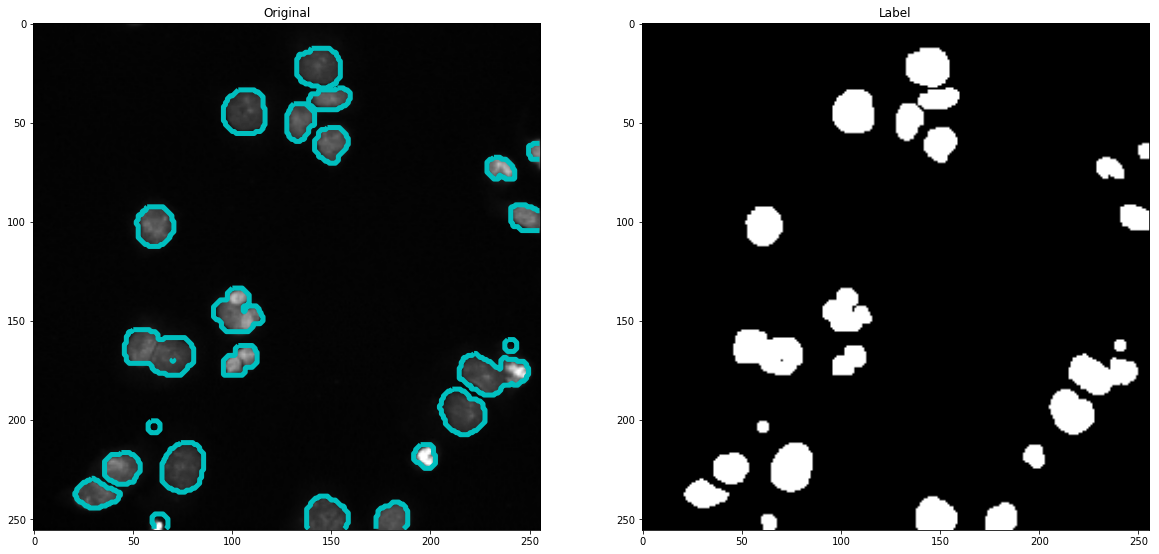

In [6]:
visualize_random_train(X_train,Y_train)

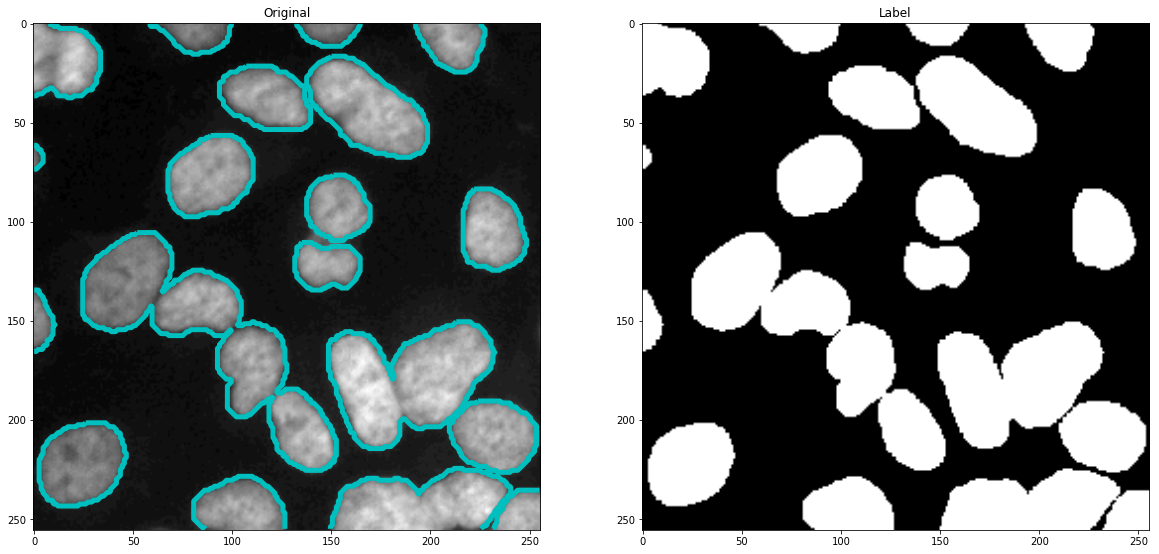

In [23]:
visualize_random_train(X_train,Y_train)

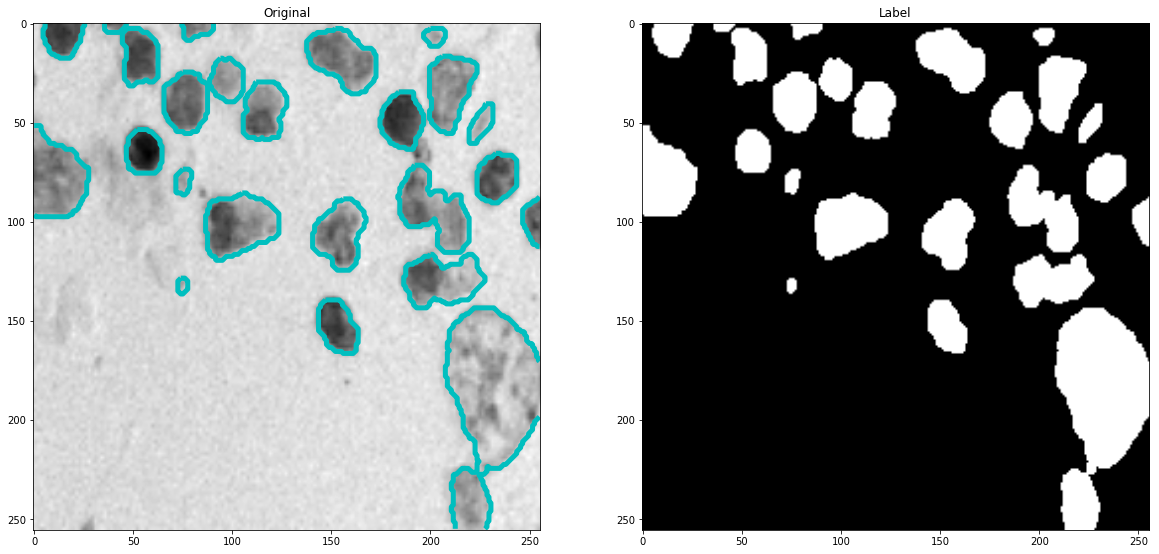

In [24]:
visualize_random_train(X_train,Y_train)

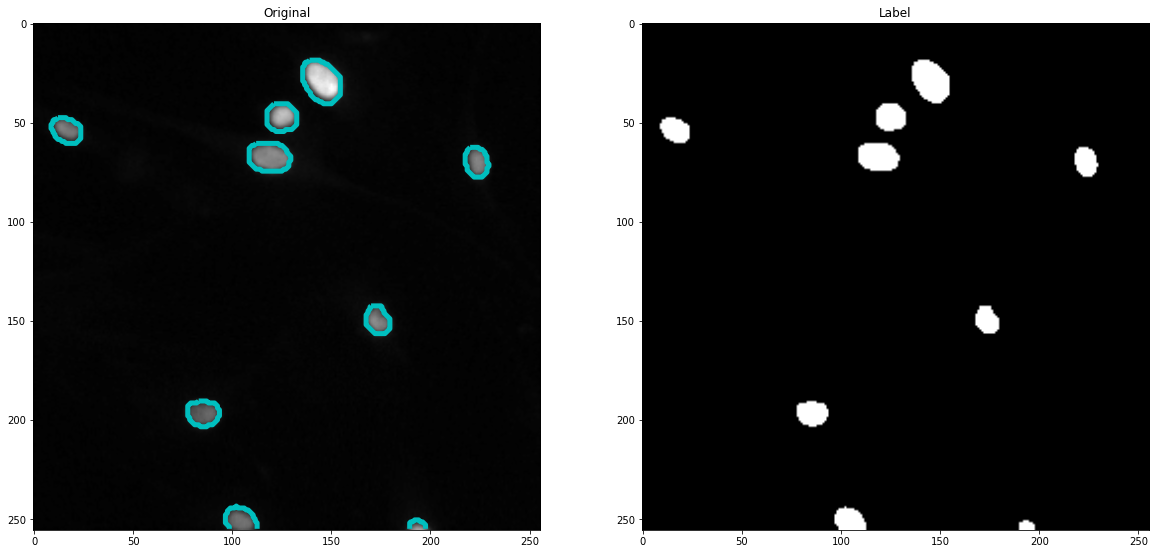

In [25]:
visualize_random_train(X_train,Y_train)

In [7]:
# Pre_process images
pre_process_fn = sm.get_preprocessing(Backbone_model)
X_train = pre_process_fn(X_train)

In [8]:
# X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [9]:
model = sm.Unet(Backbone_model,encoder_weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.compile(optimizer='adam',loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

In [11]:
print(model.summary())
# plot_model(model, to_file=model_name+'.png', show_shapes=True, show_layer_names=True)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 3 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

stage3_unit1_bn2 (BatchNormaliz (None, None, None, 2 1024        stage3_unit1_conv1[0][0]         
__________________________________________________________________________________________________
stage3_unit1_relu2 (Activation) (None, None, None, 2 0           stage3_unit1_bn2[0][0]           
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, None, None, 2 0           stage3_unit1_relu2[0][0]         
__________________________________________________________________________________________________
stage3_unit1_conv2 (Conv2D)     (None, None, None, 2 589824      zero_padding2d_18[0][0]          
__________________________________________________________________________________________________
stage3_unit1_sc (Conv2D)        (None, None, None, 2 32768       stage3_unit1_relu1[0][0]         
__________________________________________________________________________________________________
add_8 (Add

add_16 (Add)                    (None, None, None, 5 0           stage4_unit3_conv2[0][0]         
                                                                 add_15[0][0]                     
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, None, None, 5 2048        add_16[0][0]                     
__________________________________________________________________________________________________
relu1 (Activation)              (None, None, None, 5 0           bn1[0][0]                        
__________________________________________________________________________________________________
decoder_stage0_upsampling (UpSa (None, None, None, 5 0           relu1[0][0]                      
__________________________________________________________________________________________________
decoder_stage0_concat (Concaten (None, None, None, 7 0           decoder_stage0_upsampling[0][0]  
          

In [12]:
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

In [46]:
history = model.fit(X_train,
                    Y_train,
                    batch_size=2,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_val,Y_val))

Train on 536 samples, validate on 134 samples
Epoch 1/100


352/536 [==================>...........] - ETA: 7:25 - loss: 0.1806 - iou_score: 0.890 - ETA: 7:08 - loss: 0.1724 - iou_score: 0.880 - ETA: 7:02 - loss: 0.2599 - iou_score: 0.830 - ETA: 7:19 - loss: 0.2409 - iou_score: 0.842 - ETA: 7:18 - loss: 0.2630 - iou_score: 0.821 - ETA: 7:13 - loss: 0.3055 - iou_score: 0.793 - ETA: 7:05 - loss: 0.3007 - iou_score: 0.799 - ETA: 7:08 - loss: 0.2864 - iou_score: 0.806 - ETA: 7:08 - loss: 0.3018 - iou_score: 0.792 - ETA: 7:00 - loss: 0.2890 - iou_score: 0.800 - ETA: 6:57 - loss: 0.2785 - iou_score: 0.803 - ETA: 6:54 - loss: 0.2729 - iou_score: 0.804 - ETA: 6:51 - loss: 0.2768 - iou_score: 0.802 - ETA: 6:50 - loss: 0.2657 - iou_score: 0.810 - ETA: 6:48 - loss: 0.2574 - iou_score: 0.815 - ETA: 6:47 - loss: 0.2502 - iou_score: 0.819 - ETA: 6:46 - loss: 0.2511 - iou_score: 0.821 - ETA: 6:44 - loss: 0.2604 - iou_score: 0.817 - ETA: 6:46 - loss: 0.2524 - iou_score: 0.822 - ETA: 6:43 - loss: 0.2465 - iou_score: 0.826 - ETA: 6:42 - loss: 0.2436 - iou_score:

356/536 [==================>...........] - ETA: 6:53 - loss: 0.1991 - iou_score: 0.844 - ETA: 6:43 - loss: 0.2361 - iou_score: 0.825 - ETA: 6:47 - loss: 0.2196 - iou_score: 0.843 - ETA: 6:38 - loss: 0.2699 - iou_score: 0.823 - ETA: 6:39 - loss: 0.2542 - iou_score: 0.826 - ETA: 6:37 - loss: 0.2582 - iou_score: 0.811 - ETA: 6:36 - loss: 0.2560 - iou_score: 0.813 - ETA: 6:35 - loss: 0.2640 - iou_score: 0.809 - ETA: 6:35 - loss: 0.2515 - iou_score: 0.816 - ETA: 6:34 - loss: 0.2541 - iou_score: 0.813 - ETA: 6:31 - loss: 0.2453 - iou_score: 0.817 - ETA: 6:28 - loss: 0.2601 - iou_score: 0.809 - ETA: 6:25 - loss: 0.2557 - iou_score: 0.811 - ETA: 6:21 - loss: 0.2614 - iou_score: 0.809 - ETA: 6:22 - loss: 0.2564 - iou_score: 0.812 - ETA: 6:19 - loss: 0.2473 - iou_score: 0.818 - ETA: 6:18 - loss: 0.2442 - iou_score: 0.820 - ETA: 6:16 - loss: 0.2571 - iou_score: 0.814 - ETA: 6:15 - loss: 0.2539 - iou_score: 0.816 - ETA: 6:14 - loss: 0.2830 - iou_score: 0.797 - ETA: 6:12 - loss: 0.2884 - iou_score:

536/536 [==============================] - ETA: 2:16 - loss: 0.2985 - iou_score: 0.793 - ETA: 2:15 - loss: 0.2976 - iou_score: 0.794 - ETA: 2:13 - loss: 0.2970 - iou_score: 0.794 - ETA: 2:12 - loss: 0.2962 - iou_score: 0.795 - ETA: 2:10 - loss: 0.2958 - iou_score: 0.795 - ETA: 2:09 - loss: 0.2955 - iou_score: 0.795 - ETA: 2:07 - loss: 0.2948 - iou_score: 0.795 - ETA: 2:05 - loss: 0.2941 - iou_score: 0.795 - ETA: 2:04 - loss: 0.2935 - iou_score: 0.796 - ETA: 2:02 - loss: 0.2928 - iou_score: 0.796 - ETA: 2:01 - loss: 0.2921 - iou_score: 0.797 - ETA: 1:59 - loss: 0.2937 - iou_score: 0.796 - ETA: 1:58 - loss: 0.2936 - iou_score: 0.796 - ETA: 1:56 - loss: 0.2933 - iou_score: 0.796 - ETA: 1:55 - loss: 0.2935 - iou_score: 0.796 - ETA: 1:53 - loss: 0.2934 - iou_score: 0.795 - ETA: 1:52 - loss: 0.2925 - iou_score: 0.796 - ETA: 1:50 - loss: 0.2935 - iou_score: 0.796 - ETA: 1:49 - loss: 0.2939 - iou_score: 0.795 - ETA: 1:47 - loss: 0.2955 - iou_score: 0.794 - ETA: 1:46 - loss: 0.3015 - iou_score:

356/536 [==================>...........] - ETA: 6:44 - loss: 0.2137 - iou_score: 0.825 - ETA: 6:55 - loss: 0.2529 - iou_score: 0.798 - ETA: 6:56 - loss: 0.3210 - iou_score: 0.799 - ETA: 6:51 - loss: 0.2871 - iou_score: 0.815 - ETA: 6:58 - loss: 0.2829 - iou_score: 0.813 - ETA: 6:57 - loss: 0.2583 - iou_score: 0.830 - ETA: 6:53 - loss: 0.2610 - iou_score: 0.823 - ETA: 6:48 - loss: 0.2547 - iou_score: 0.820 - ETA: 6:48 - loss: 0.2509 - iou_score: 0.818 - ETA: 6:49 - loss: 0.2595 - iou_score: 0.812 - ETA: 6:45 - loss: 0.2809 - iou_score: 0.801 - ETA: 6:43 - loss: 0.2996 - iou_score: 0.798 - ETA: 6:43 - loss: 0.2951 - iou_score: 0.800 - ETA: 6:42 - loss: 0.2942 - iou_score: 0.798 - ETA: 6:40 - loss: 0.2981 - iou_score: 0.789 - ETA: 6:40 - loss: 0.3232 - iou_score: 0.772 - ETA: 6:39 - loss: 0.3194 - iou_score: 0.775 - ETA: 6:37 - loss: 0.3216 - iou_score: 0.772 - ETA: 6:36 - loss: 0.3160 - iou_score: 0.777 - ETA: 6:34 - loss: 0.3213 - iou_score: 0.777 - ETA: 6:32 - loss: 0.3124 - iou_score:

356/536 [==================>...........] - ETA: 6:31 - loss: 0.1883 - iou_score: 0.840 - ETA: 6:27 - loss: 0.2230 - iou_score: 0.841 - ETA: 6:21 - loss: 0.2746 - iou_score: 0.800 - ETA: 6:17 - loss: 0.2695 - iou_score: 0.801 - ETA: 6:17 - loss: 0.2431 - iou_score: 0.821 - ETA: 6:19 - loss: 0.2739 - iou_score: 0.800 - ETA: 6:18 - loss: 0.2712 - iou_score: 0.798 - ETA: 6:14 - loss: 0.2518 - iou_score: 0.813 - ETA: 6:12 - loss: 0.2648 - iou_score: 0.805 - ETA: 6:11 - loss: 0.2767 - iou_score: 0.802 - ETA: 6:12 - loss: 0.2688 - iou_score: 0.808 - ETA: 6:09 - loss: 0.2690 - iou_score: 0.808 - ETA: 6:09 - loss: 0.2641 - iou_score: 0.810 - ETA: 6:07 - loss: 0.2609 - iou_score: 0.813 - ETA: 6:07 - loss: 0.2576 - iou_score: 0.817 - ETA: 6:07 - loss: 0.2549 - iou_score: 0.816 - ETA: 6:06 - loss: 0.2587 - iou_score: 0.810 - ETA: 6:04 - loss: 0.2511 - iou_score: 0.815 - ETA: 6:02 - loss: 0.2585 - iou_score: 0.812 - ETA: 6:01 - loss: 0.2541 - iou_score: 0.816 - ETA: 6:00 - loss: 0.2521 - iou_score:

536/536 [==============================] - ETA: 2:19 - loss: 0.2818 - iou_score: 0.805 - ETA: 2:18 - loss: 0.2827 - iou_score: 0.805 - ETA: 2:16 - loss: 0.2840 - iou_score: 0.804 - ETA: 2:15 - loss: 0.2834 - iou_score: 0.804 - ETA: 2:13 - loss: 0.2834 - iou_score: 0.804 - ETA: 2:12 - loss: 0.2840 - iou_score: 0.804 - ETA: 2:10 - loss: 0.2830 - iou_score: 0.805 - ETA: 2:08 - loss: 0.2827 - iou_score: 0.805 - ETA: 2:07 - loss: 0.2822 - iou_score: 0.805 - ETA: 2:05 - loss: 0.2840 - iou_score: 0.804 - ETA: 2:04 - loss: 0.2846 - iou_score: 0.803 - ETA: 2:02 - loss: 0.2843 - iou_score: 0.804 - ETA: 2:01 - loss: 0.2851 - iou_score: 0.803 - ETA: 1:59 - loss: 0.2852 - iou_score: 0.803 - ETA: 1:57 - loss: 0.2852 - iou_score: 0.803 - ETA: 1:56 - loss: 0.2843 - iou_score: 0.803 - ETA: 1:54 - loss: 0.2851 - iou_score: 0.803 - ETA: 1:53 - loss: 0.2856 - iou_score: 0.802 - ETA: 1:51 - loss: 0.2859 - iou_score: 0.802 - ETA: 1:50 - loss: 0.2862 - iou_score: 0.802 - ETA: 1:48 - loss: 0.2853 - iou_score:

356/536 [==================>...........] - ETA: 6:23 - loss: 0.1161 - iou_score: 0.911 - ETA: 6:21 - loss: 0.1340 - iou_score: 0.902 - ETA: 6:31 - loss: 0.1861 - iou_score: 0.862 - ETA: 6:29 - loss: 0.2148 - iou_score: 0.843 - ETA: 6:38 - loss: 0.2245 - iou_score: 0.843 - ETA: 6:33 - loss: 0.2308 - iou_score: 0.837 - ETA: 6:29 - loss: 0.2234 - iou_score: 0.839 - ETA: 6:26 - loss: 0.2419 - iou_score: 0.827 - ETA: 6:23 - loss: 0.2732 - iou_score: 0.803 - ETA: 6:22 - loss: 0.2651 - iou_score: 0.810 - ETA: 6:23 - loss: 0.2924 - iou_score: 0.799 - ETA: 6:21 - loss: 0.2801 - iou_score: 0.804 - ETA: 6:23 - loss: 0.2766 - iou_score: 0.809 - ETA: 6:21 - loss: 0.2685 - iou_score: 0.813 - ETA: 6:20 - loss: 0.2712 - iou_score: 0.815 - ETA: 6:18 - loss: 0.2875 - iou_score: 0.805 - ETA: 6:16 - loss: 0.2865 - iou_score: 0.808 - ETA: 6:16 - loss: 0.2839 - iou_score: 0.809 - ETA: 6:16 - loss: 0.2897 - iou_score: 0.804 - ETA: 6:15 - loss: 0.2890 - iou_score: 0.804 - ETA: 6:15 - loss: 0.2977 - iou_score:

356/536 [==================>...........] - ETA: 7:18 - loss: 0.3976 - iou_score: 0.742 - ETA: 6:49 - loss: 0.3883 - iou_score: 0.720 - ETA: 6:38 - loss: 0.3091 - iou_score: 0.773 - ETA: 6:41 - loss: 0.2692 - iou_score: 0.802 - ETA: 6:44 - loss: 0.3057 - iou_score: 0.764 - ETA: 6:43 - loss: 0.2760 - iou_score: 0.787 - ETA: 6:40 - loss: 0.2658 - iou_score: 0.797 - ETA: 6:39 - loss: 0.2622 - iou_score: 0.794 - ETA: 6:36 - loss: 0.2620 - iou_score: 0.794 - ETA: 6:36 - loss: 0.2652 - iou_score: 0.798 - ETA: 6:36 - loss: 0.2550 - iou_score: 0.803 - ETA: 6:37 - loss: 0.2466 - iou_score: 0.810 - ETA: 6:36 - loss: 0.2441 - iou_score: 0.812 - ETA: 6:36 - loss: 0.2476 - iou_score: 0.812 - ETA: 6:36 - loss: 0.2520 - iou_score: 0.812 - ETA: 6:35 - loss: 0.2652 - iou_score: 0.804 - ETA: 6:33 - loss: 0.2589 - iou_score: 0.808 - ETA: 6:32 - loss: 0.2734 - iou_score: 0.802 - ETA: 6:30 - loss: 0.2732 - iou_score: 0.803 - ETA: 6:31 - loss: 0.2650 - iou_score: 0.809 - ETA: 6:27 - loss: 0.2859 - iou_score:

536/536 [==============================] - ETA: 2:17 - loss: 0.2750 - iou_score: 0.812 - ETA: 2:16 - loss: 0.2744 - iou_score: 0.812 - ETA: 2:14 - loss: 0.2752 - iou_score: 0.812 - ETA: 2:12 - loss: 0.2750 - iou_score: 0.812 - ETA: 2:11 - loss: 0.2792 - iou_score: 0.810 - ETA: 2:09 - loss: 0.2787 - iou_score: 0.810 - ETA: 2:08 - loss: 0.2781 - iou_score: 0.810 - ETA: 2:06 - loss: 0.2781 - iou_score: 0.810 - ETA: 2:05 - loss: 0.2788 - iou_score: 0.809 - ETA: 2:03 - loss: 0.2780 - iou_score: 0.809 - ETA: 2:01 - loss: 0.2782 - iou_score: 0.809 - ETA: 2:00 - loss: 0.2793 - iou_score: 0.809 - ETA: 1:58 - loss: 0.2788 - iou_score: 0.809 - ETA: 1:57 - loss: 0.2792 - iou_score: 0.809 - ETA: 1:55 - loss: 0.2793 - iou_score: 0.809 - ETA: 1:54 - loss: 0.2801 - iou_score: 0.808 - ETA: 1:52 - loss: 0.2800 - iou_score: 0.808 - ETA: 1:51 - loss: 0.2798 - iou_score: 0.808 - ETA: 1:49 - loss: 0.2798 - iou_score: 0.808 - ETA: 1:48 - loss: 0.2805 - iou_score: 0.808 - ETA: 1:46 - loss: 0.2799 - iou_score:

356/536 [==================>...........] - ETA: 7:30 - loss: 0.1590 - iou_score: 0.850 - ETA: 7:07 - loss: 0.1516 - iou_score: 0.867 - ETA: 7:26 - loss: 0.2641 - iou_score: 0.805 - ETA: 7:37 - loss: 0.2506 - iou_score: 0.813 - ETA: 7:32 - loss: 0.2553 - iou_score: 0.815 - ETA: 7:27 - loss: 0.2920 - iou_score: 0.792 - ETA: 7:25 - loss: 0.2809 - iou_score: 0.802 - ETA: 7:19 - loss: 0.2710 - iou_score: 0.809 - ETA: 7:15 - loss: 0.2708 - iou_score: 0.812 - ETA: 7:09 - loss: 0.2690 - iou_score: 0.808 - ETA: 7:07 - loss: 0.2796 - iou_score: 0.799 - ETA: 7:10 - loss: 0.2666 - iou_score: 0.807 - ETA: 7:07 - loss: 0.2719 - iou_score: 0.806 - ETA: 7:05 - loss: 0.2714 - iou_score: 0.804 - ETA: 7:01 - loss: 0.2781 - iou_score: 0.800 - ETA: 6:57 - loss: 0.2834 - iou_score: 0.795 - ETA: 6:54 - loss: 0.2814 - iou_score: 0.796 - ETA: 6:50 - loss: 0.2883 - iou_score: 0.793 - ETA: 6:46 - loss: 0.3019 - iou_score: 0.790 - ETA: 6:45 - loss: 0.2951 - iou_score: 0.793 - ETA: 6:42 - loss: 0.2970 - iou_score:

356/536 [==================>...........] - ETA: 3:31 - loss: 0.2760 - iou_score: 0.807 - ETA: 3:45 - loss: 0.2983 - iou_score: 0.797 - ETA: 3:37 - loss: 0.2395 - iou_score: 0.835 - ETA: 3:31 - loss: 0.2180 - iou_score: 0.849 - ETA: 3:31 - loss: 0.2383 - iou_score: 0.838 - ETA: 3:31 - loss: 0.2389 - iou_score: 0.832 - ETA: 3:27 - loss: 0.2548 - iou_score: 0.830 - ETA: 3:25 - loss: 0.2699 - iou_score: 0.823 - ETA: 3:24 - loss: 0.2646 - iou_score: 0.823 - ETA: 3:21 - loss: 0.2930 - iou_score: 0.802 - ETA: 3:19 - loss: 0.2782 - iou_score: 0.809 - ETA: 3:17 - loss: 0.2644 - iou_score: 0.818 - ETA: 3:16 - loss: 0.2725 - iou_score: 0.815 - ETA: 3:15 - loss: 0.2704 - iou_score: 0.815 - ETA: 3:14 - loss: 0.2649 - iou_score: 0.818 - ETA: 3:12 - loss: 0.2694 - iou_score: 0.815 - ETA: 3:11 - loss: 0.2598 - iou_score: 0.821 - ETA: 3:10 - loss: 0.2507 - iou_score: 0.827 - ETA: 3:11 - loss: 0.2512 - iou_score: 0.827 - ETA: 3:10 - loss: 0.2487 - iou_score: 0.829 - ETA: 3:09 - loss: 0.2420 - iou_score:

536/536 [==============================] - ETA: 1:08 - loss: 0.2743 - iou_score: 0.812 - ETA: 1:07 - loss: 0.2740 - iou_score: 0.812 - ETA: 1:06 - loss: 0.2736 - iou_score: 0.812 - ETA: 1:05 - loss: 0.2744 - iou_score: 0.812 - ETA: 1:05 - loss: 0.2753 - iou_score: 0.812 - ETA: 1:04 - loss: 0.2751 - iou_score: 0.812 - ETA: 1:03 - loss: 0.2743 - iou_score: 0.812 - ETA: 1:02 - loss: 0.2743 - iou_score: 0.812 - ETA: 1:01 - loss: 0.2736 - iou_score: 0.812 - ETA: 1:01 - loss: 0.2745 - iou_score: 0.812 - ETA: 1:00 - loss: 0.2739 - iou_score: 0.812 - ETA: 59s - loss: 0.2739 - iou_score: 0.812 - ETA: 58s - loss: 0.2735 - iou_score: 0.81 - ETA: 58s - loss: 0.2733 - iou_score: 0.81 - ETA: 57s - loss: 0.2732 - iou_score: 0.81 - ETA: 56s - loss: 0.2733 - iou_score: 0.81 - ETA: 55s - loss: 0.2729 - iou_score: 0.81 - ETA: 55s - loss: 0.2729 - iou_score: 0.81 - ETA: 54s - loss: 0.2724 - iou_score: 0.81 - ETA: 53s - loss: 0.2764 - iou_score: 0.81 - ETA: 52s - loss: 0.2760 - iou_score: 0.81 - ETA: 52s -

356/536 [==================>...........] - ETA: 3:27 - loss: 0.2177 - iou_score: 0.841 - ETA: 3:15 - loss: 0.2478 - iou_score: 0.805 - ETA: 3:11 - loss: 0.2795 - iou_score: 0.796 - ETA: 3:13 - loss: 0.2693 - iou_score: 0.804 - ETA: 3:09 - loss: 0.3183 - iou_score: 0.748 - ETA: 3:07 - loss: 0.3261 - iou_score: 0.743 - ETA: 3:07 - loss: 0.3057 - iou_score: 0.761 - ETA: 3:06 - loss: 0.2822 - iou_score: 0.778 - ETA: 3:06 - loss: 0.2874 - iou_score: 0.779 - ETA: 3:04 - loss: 0.2819 - iou_score: 0.781 - ETA: 3:03 - loss: 0.2722 - iou_score: 0.788 - ETA: 3:02 - loss: 0.2626 - iou_score: 0.794 - ETA: 3:01 - loss: 0.2540 - iou_score: 0.802 - ETA: 3:00 - loss: 0.2442 - iou_score: 0.810 - ETA: 2:59 - loss: 0.2514 - iou_score: 0.807 - ETA: 2:57 - loss: 0.2514 - iou_score: 0.808 - ETA: 2:56 - loss: 0.2566 - iou_score: 0.807 - ETA: 2:54 - loss: 0.2574 - iou_score: 0.806 - ETA: 2:54 - loss: 0.2514 - iou_score: 0.812 - ETA: 2:53 - loss: 0.2556 - iou_score: 0.807 - ETA: 2:52 - loss: 0.2537 - iou_score:

356/536 [==================>...........] - ETA: 2:52 - loss: 0.5600 - iou_score: 0.643 - ETA: 2:55 - loss: 0.4214 - iou_score: 0.739 - ETA: 2:55 - loss: 0.3186 - iou_score: 0.800 - ETA: 2:49 - loss: 0.2730 - iou_score: 0.826 - ETA: 2:48 - loss: 0.2900 - iou_score: 0.809 - ETA: 2:44 - loss: 0.2898 - iou_score: 0.811 - ETA: 2:42 - loss: 0.2797 - iou_score: 0.816 - ETA: 2:42 - loss: 0.2663 - iou_score: 0.820 - ETA: 2:41 - loss: 0.2568 - iou_score: 0.825 - ETA: 2:41 - loss: 0.2416 - iou_score: 0.833 - ETA: 2:41 - loss: 0.2513 - iou_score: 0.825 - ETA: 2:41 - loss: 0.2464 - iou_score: 0.825 - ETA: 2:39 - loss: 0.2376 - iou_score: 0.832 - ETA: 2:38 - loss: 0.2391 - iou_score: 0.830 - ETA: 2:38 - loss: 0.2332 - iou_score: 0.834 - ETA: 2:37 - loss: 0.2339 - iou_score: 0.833 - ETA: 2:36 - loss: 0.2407 - iou_score: 0.827 - ETA: 2:35 - loss: 0.2331 - iou_score: 0.832 - ETA: 2:34 - loss: 0.2350 - iou_score: 0.831 - ETA: 2:32 - loss: 0.2377 - iou_score: 0.830 - ETA: 2:31 - loss: 0.2329 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.2722 - iou_score: 0.81 - ETA: 56s - loss: 0.2720 - iou_score: 0.81 - ETA: 56s - loss: 0.2716 - iou_score: 0.81 - ETA: 55s - loss: 0.2707 - iou_score: 0.81 - ETA: 54s - loss: 0.2715 - iou_score: 0.81 - ETA: 54s - loss: 0.2714 - iou_score: 0.81 - ETA: 53s - loss: 0.2709 - iou_score: 0.81 - ETA: 52s - loss: 0.2708 - iou_score: 0.81 - ETA: 52s - loss: 0.2705 - iou_score: 0.81 - ETA: 51s - loss: 0.2706 - iou_score: 0.81 - ETA: 50s - loss: 0.2708 - iou_score: 0.81 - ETA: 50s - loss: 0.2699 - iou_score: 0.81 - ETA: 49s - loss: 0.2702 - iou_score: 0.81 - ETA: 48s - loss: 0.2712 - iou_score: 0.81 - ETA: 48s - loss: 0.2711 - iou_score: 0.81 - ETA: 47s - loss: 0.2709 - iou_score: 0.81 - ETA: 47s - loss: 0.2707 - iou_score: 0.81 - ETA: 46s - loss: 0.2713 - iou_score: 0.81 - ETA: 45s - loss: 0.2713 - iou_score: 0.81 - ETA: 45s - loss: 0.2709 - iou_score: 0.81 - ETA: 44s - loss: 0.2709 - iou_score: 0.81 - ETA: 43s - loss: 0.2703 - iou_sco

356/536 [==================>...........] - ETA: 2:51 - loss: 0.2879 - iou_score: 0.828 - ETA: 2:49 - loss: 0.1920 - iou_score: 0.878 - ETA: 2:46 - loss: 0.2040 - iou_score: 0.856 - ETA: 2:47 - loss: 0.2248 - iou_score: 0.843 - ETA: 2:47 - loss: 0.2651 - iou_score: 0.814 - ETA: 2:47 - loss: 0.2475 - iou_score: 0.825 - ETA: 2:47 - loss: 0.2564 - iou_score: 0.817 - ETA: 2:47 - loss: 0.2582 - iou_score: 0.810 - ETA: 2:47 - loss: 0.2725 - iou_score: 0.803 - ETA: 2:48 - loss: 0.2765 - iou_score: 0.803 - ETA: 2:47 - loss: 0.2611 - iou_score: 0.814 - ETA: 2:47 - loss: 0.2621 - iou_score: 0.809 - ETA: 2:46 - loss: 0.2492 - iou_score: 0.817 - ETA: 2:45 - loss: 0.2509 - iou_score: 0.815 - ETA: 2:44 - loss: 0.2431 - iou_score: 0.821 - ETA: 2:42 - loss: 0.2415 - iou_score: 0.824 - ETA: 2:40 - loss: 0.2543 - iou_score: 0.820 - ETA: 2:39 - loss: 0.2483 - iou_score: 0.824 - ETA: 2:39 - loss: 0.2453 - iou_score: 0.825 - ETA: 2:38 - loss: 0.2442 - iou_score: 0.826 - ETA: 2:38 - loss: 0.2539 - iou_score:

356/536 [==================>...........] - ETA: 3:04 - loss: 0.2783 - iou_score: 0.842 - ETA: 3:00 - loss: 0.2232 - iou_score: 0.866 - ETA: 2:59 - loss: 0.2037 - iou_score: 0.864 - ETA: 2:57 - loss: 0.1793 - iou_score: 0.879 - ETA: 2:55 - loss: 0.1987 - iou_score: 0.866 - ETA: 2:53 - loss: 0.1941 - iou_score: 0.863 - ETA: 2:50 - loss: 0.1794 - iou_score: 0.872 - ETA: 2:49 - loss: 0.2070 - iou_score: 0.860 - ETA: 2:45 - loss: 0.2110 - iou_score: 0.857 - ETA: 2:43 - loss: 0.2280 - iou_score: 0.847 - ETA: 2:41 - loss: 0.2234 - iou_score: 0.848 - ETA: 2:40 - loss: 0.2153 - iou_score: 0.854 - ETA: 2:39 - loss: 0.2171 - iou_score: 0.850 - ETA: 2:39 - loss: 0.2245 - iou_score: 0.848 - ETA: 2:38 - loss: 0.2404 - iou_score: 0.843 - ETA: 2:37 - loss: 0.2418 - iou_score: 0.842 - ETA: 2:37 - loss: 0.2422 - iou_score: 0.842 - ETA: 2:37 - loss: 0.2378 - iou_score: 0.843 - ETA: 2:36 - loss: 0.2404 - iou_score: 0.840 - ETA: 2:36 - loss: 0.2418 - iou_score: 0.840 - ETA: 2:36 - loss: 0.2384 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.2569 - iou_score: 0.82 - ETA: 56s - loss: 0.2569 - iou_score: 0.82 - ETA: 56s - loss: 0.2568 - iou_score: 0.82 - ETA: 55s - loss: 0.2567 - iou_score: 0.82 - ETA: 55s - loss: 0.2561 - iou_score: 0.82 - ETA: 54s - loss: 0.2622 - iou_score: 0.81 - ETA: 53s - loss: 0.2620 - iou_score: 0.81 - ETA: 53s - loss: 0.2617 - iou_score: 0.81 - ETA: 52s - loss: 0.2628 - iou_score: 0.81 - ETA: 51s - loss: 0.2627 - iou_score: 0.81 - ETA: 51s - loss: 0.2620 - iou_score: 0.81 - ETA: 50s - loss: 0.2615 - iou_score: 0.81 - ETA: 49s - loss: 0.2608 - iou_score: 0.82 - ETA: 49s - loss: 0.2601 - iou_score: 0.82 - ETA: 48s - loss: 0.2596 - iou_score: 0.82 - ETA: 47s - loss: 0.2593 - iou_score: 0.82 - ETA: 47s - loss: 0.2592 - iou_score: 0.82 - ETA: 46s - loss: 0.2594 - iou_score: 0.82 - ETA: 46s - loss: 0.2595 - iou_score: 0.82 - ETA: 45s - loss: 0.2593 - iou_score: 0.82 - ETA: 44s - loss: 0.2592 - iou_score: 0.82 - ETA: 44s - loss: 0.2597 - iou_sco

356/536 [==================>...........] - ETA: 2:29 - loss: 0.2330 - iou_score: 0.806 - ETA: 2:35 - loss: 0.3400 - iou_score: 0.783 - ETA: 2:35 - loss: 0.3415 - iou_score: 0.785 - ETA: 2:32 - loss: 0.3193 - iou_score: 0.801 - ETA: 2:35 - loss: 0.2904 - iou_score: 0.816 - ETA: 2:36 - loss: 0.2822 - iou_score: 0.819 - ETA: 2:36 - loss: 0.2630 - iou_score: 0.828 - ETA: 2:36 - loss: 0.2592 - iou_score: 0.829 - ETA: 2:37 - loss: 0.2453 - iou_score: 0.837 - ETA: 2:38 - loss: 0.2368 - iou_score: 0.842 - ETA: 2:38 - loss: 0.2475 - iou_score: 0.835 - ETA: 2:38 - loss: 0.2346 - iou_score: 0.842 - ETA: 2:39 - loss: 0.2467 - iou_score: 0.828 - ETA: 2:39 - loss: 0.2376 - iou_score: 0.834 - ETA: 2:38 - loss: 0.2444 - iou_score: 0.830 - ETA: 2:38 - loss: 0.2562 - iou_score: 0.825 - ETA: 2:38 - loss: 0.2580 - iou_score: 0.823 - ETA: 2:37 - loss: 0.2570 - iou_score: 0.824 - ETA: 2:36 - loss: 0.2568 - iou_score: 0.823 - ETA: 2:36 - loss: 0.2517 - iou_score: 0.825 - ETA: 2:36 - loss: 0.2524 - iou_score:

356/536 [==================>...........] - ETA: 2:55 - loss: 0.1406 - iou_score: 0.889 - ETA: 2:50 - loss: 0.2020 - iou_score: 0.845 - ETA: 2:54 - loss: 0.2507 - iou_score: 0.816 - ETA: 3:01 - loss: 0.2712 - iou_score: 0.802 - ETA: 3:03 - loss: 0.2437 - iou_score: 0.823 - ETA: 3:05 - loss: 0.2264 - iou_score: 0.836 - ETA: 3:03 - loss: 0.2357 - iou_score: 0.827 - ETA: 3:01 - loss: 0.2541 - iou_score: 0.821 - ETA: 2:58 - loss: 0.2472 - iou_score: 0.827 - ETA: 2:57 - loss: 0.2421 - iou_score: 0.829 - ETA: 2:57 - loss: 0.2432 - iou_score: 0.829 - ETA: 2:56 - loss: 0.2319 - iou_score: 0.837 - ETA: 2:53 - loss: 0.2510 - iou_score: 0.827 - ETA: 2:51 - loss: 0.2486 - iou_score: 0.828 - ETA: 2:50 - loss: 0.2519 - iou_score: 0.825 - ETA: 2:49 - loss: 0.2459 - iou_score: 0.830 - ETA: 2:49 - loss: 0.2427 - iou_score: 0.832 - ETA: 2:48 - loss: 0.2385 - iou_score: 0.834 - ETA: 2:47 - loss: 0.2505 - iou_score: 0.827 - ETA: 2:46 - loss: 0.2562 - iou_score: 0.825 - ETA: 2:46 - loss: 0.2638 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.2715 - iou_score: 0.81 - ETA: 57s - loss: 0.2721 - iou_score: 0.81 - ETA: 56s - loss: 0.2719 - iou_score: 0.81 - ETA: 55s - loss: 0.2717 - iou_score: 0.81 - ETA: 55s - loss: 0.2718 - iou_score: 0.81 - ETA: 54s - loss: 0.2709 - iou_score: 0.81 - ETA: 53s - loss: 0.2706 - iou_score: 0.81 - ETA: 53s - loss: 0.2713 - iou_score: 0.81 - ETA: 52s - loss: 0.2718 - iou_score: 0.81 - ETA: 52s - loss: 0.2720 - iou_score: 0.81 - ETA: 51s - loss: 0.2716 - iou_score: 0.81 - ETA: 50s - loss: 0.2727 - iou_score: 0.81 - ETA: 50s - loss: 0.2729 - iou_score: 0.81 - ETA: 49s - loss: 0.2721 - iou_score: 0.81 - ETA: 48s - loss: 0.2732 - iou_score: 0.81 - ETA: 48s - loss: 0.2724 - iou_score: 0.81 - ETA: 47s - loss: 0.2726 - iou_score: 0.81 - ETA: 46s - loss: 0.2720 - iou_score: 0.81 - ETA: 46s - loss: 0.2720 - iou_score: 0.81 - ETA: 45s - loss: 0.2718 - iou_score: 0.81 - ETA: 44s - loss: 0.2711 - iou_score: 0.81 - ETA: 44s - loss: 0.2711 - iou_sco

356/536 [==================>...........] - ETA: 2:57 - loss: 0.1308 - iou_score: 0.909 - ETA: 2:56 - loss: 0.1811 - iou_score: 0.875 - ETA: 2:56 - loss: 0.2200 - iou_score: 0.846 - ETA: 2:54 - loss: 0.3357 - iou_score: 0.735 - ETA: 2:52 - loss: 0.3229 - iou_score: 0.753 - ETA: 2:50 - loss: 0.3232 - iou_score: 0.760 - ETA: 2:50 - loss: 0.3704 - iou_score: 0.741 - ETA: 2:49 - loss: 0.3371 - iou_score: 0.763 - ETA: 2:48 - loss: 0.3173 - iou_score: 0.775 - ETA: 2:48 - loss: 0.3115 - iou_score: 0.778 - ETA: 2:48 - loss: 0.2996 - iou_score: 0.786 - ETA: 2:49 - loss: 0.2852 - iou_score: 0.796 - ETA: 2:47 - loss: 0.2898 - iou_score: 0.792 - ETA: 2:46 - loss: 0.2876 - iou_score: 0.792 - ETA: 2:45 - loss: 0.2834 - iou_score: 0.796 - ETA: 2:44 - loss: 0.2852 - iou_score: 0.793 - ETA: 2:43 - loss: 0.2840 - iou_score: 0.794 - ETA: 2:42 - loss: 0.2962 - iou_score: 0.786 - ETA: 2:41 - loss: 0.2975 - iou_score: 0.787 - ETA: 2:40 - loss: 0.2889 - iou_score: 0.793 - ETA: 2:40 - loss: 0.2859 - iou_score:

356/536 [==================>...........] - ETA: 2:45 - loss: 0.1516 - iou_score: 0.893 - ETA: 2:38 - loss: 0.1641 - iou_score: 0.887 - ETA: 2:38 - loss: 0.2074 - iou_score: 0.850 - ETA: 2:39 - loss: 0.2553 - iou_score: 0.800 - ETA: 2:42 - loss: 0.2627 - iou_score: 0.799 - ETA: 2:43 - loss: 0.2507 - iou_score: 0.808 - ETA: 2:42 - loss: 0.2639 - iou_score: 0.810 - ETA: 2:41 - loss: 0.2484 - iou_score: 0.818 - ETA: 2:42 - loss: 0.2449 - iou_score: 0.819 - ETA: 2:43 - loss: 0.2355 - iou_score: 0.825 - ETA: 2:43 - loss: 0.2365 - iou_score: 0.823 - ETA: 2:44 - loss: 0.2361 - iou_score: 0.824 - ETA: 2:44 - loss: 0.2309 - iou_score: 0.826 - ETA: 2:45 - loss: 0.2338 - iou_score: 0.825 - ETA: 2:45 - loss: 0.2350 - iou_score: 0.822 - ETA: 2:44 - loss: 0.2529 - iou_score: 0.805 - ETA: 2:43 - loss: 0.2473 - iou_score: 0.810 - ETA: 2:42 - loss: 0.2427 - iou_score: 0.815 - ETA: 2:42 - loss: 0.2435 - iou_score: 0.815 - ETA: 2:41 - loss: 0.2389 - iou_score: 0.819 - ETA: 2:41 - loss: 0.2583 - iou_score:

536/536 [==============================] - ETA: 58s - loss: 0.2721 - iou_score: 0.81 - ETA: 57s - loss: 0.2723 - iou_score: 0.81 - ETA: 57s - loss: 0.2724 - iou_score: 0.81 - ETA: 56s - loss: 0.2717 - iou_score: 0.81 - ETA: 55s - loss: 0.2726 - iou_score: 0.81 - ETA: 55s - loss: 0.2728 - iou_score: 0.81 - ETA: 54s - loss: 0.2794 - iou_score: 0.80 - ETA: 53s - loss: 0.2801 - iou_score: 0.80 - ETA: 53s - loss: 0.2792 - iou_score: 0.80 - ETA: 52s - loss: 0.2784 - iou_score: 0.80 - ETA: 51s - loss: 0.2797 - iou_score: 0.80 - ETA: 51s - loss: 0.2806 - iou_score: 0.80 - ETA: 50s - loss: 0.2811 - iou_score: 0.80 - ETA: 49s - loss: 0.2818 - iou_score: 0.80 - ETA: 49s - loss: 0.2816 - iou_score: 0.80 - ETA: 48s - loss: 0.2814 - iou_score: 0.80 - ETA: 47s - loss: 0.2810 - iou_score: 0.80 - ETA: 47s - loss: 0.2804 - iou_score: 0.80 - ETA: 46s - loss: 0.2796 - iou_score: 0.80 - ETA: 45s - loss: 0.2795 - iou_score: 0.80 - ETA: 45s - loss: 0.2796 - iou_score: 0.80 - ETA: 44s - loss: 0.2807 - iou_sco

356/536 [==================>...........] - ETA: 2:56 - loss: 0.3530 - iou_score: 0.700 - ETA: 2:52 - loss: 0.2495 - iou_score: 0.802 - ETA: 2:51 - loss: 0.2576 - iou_score: 0.791 - ETA: 2:52 - loss: 0.2608 - iou_score: 0.805 - ETA: 2:51 - loss: 0.2615 - iou_score: 0.812 - ETA: 2:50 - loss: 0.2627 - iou_score: 0.815 - ETA: 2:48 - loss: 0.2489 - iou_score: 0.824 - ETA: 2:46 - loss: 0.2333 - iou_score: 0.835 - ETA: 2:46 - loss: 0.2373 - iou_score: 0.828 - ETA: 2:45 - loss: 0.2282 - iou_score: 0.833 - ETA: 2:44 - loss: 0.2208 - iou_score: 0.839 - ETA: 2:44 - loss: 0.2135 - iou_score: 0.843 - ETA: 2:43 - loss: 0.2041 - iou_score: 0.850 - ETA: 2:42 - loss: 0.1995 - iou_score: 0.853 - ETA: 2:42 - loss: 0.2103 - iou_score: 0.849 - ETA: 2:41 - loss: 0.2099 - iou_score: 0.848 - ETA: 2:41 - loss: 0.2092 - iou_score: 0.850 - ETA: 2:40 - loss: 0.2169 - iou_score: 0.845 - ETA: 2:39 - loss: 0.2308 - iou_score: 0.838 - ETA: 2:39 - loss: 0.2338 - iou_score: 0.835 - ETA: 2:39 - loss: 0.2357 - iou_score:

356/536 [==================>...........] - ETA: 2:53 - loss: 0.6658 - iou_score: 0.710 - ETA: 2:54 - loss: 0.3767 - iou_score: 0.823 - ETA: 2:52 - loss: 0.2928 - iou_score: 0.846 - ETA: 2:52 - loss: 0.2601 - iou_score: 0.858 - ETA: 2:51 - loss: 0.2818 - iou_score: 0.842 - ETA: 2:50 - loss: 0.2577 - iou_score: 0.851 - ETA: 2:49 - loss: 0.2853 - iou_score: 0.829 - ETA: 2:49 - loss: 0.2862 - iou_score: 0.827 - ETA: 2:48 - loss: 0.2725 - iou_score: 0.833 - ETA: 2:48 - loss: 0.2578 - iou_score: 0.838 - ETA: 2:48 - loss: 0.2580 - iou_score: 0.838 - ETA: 2:46 - loss: 0.2628 - iou_score: 0.829 - ETA: 2:46 - loss: 0.2505 - iou_score: 0.836 - ETA: 2:45 - loss: 0.2453 - iou_score: 0.838 - ETA: 2:44 - loss: 0.2475 - iou_score: 0.835 - ETA: 2:44 - loss: 0.2597 - iou_score: 0.828 - ETA: 2:43 - loss: 0.2539 - iou_score: 0.831 - ETA: 2:42 - loss: 0.2507 - iou_score: 0.831 - ETA: 2:42 - loss: 0.2455 - iou_score: 0.834 - ETA: 2:41 - loss: 0.2425 - iou_score: 0.836 - ETA: 2:41 - loss: 0.2396 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2595 - iou_score: 0.82 - ETA: 56s - loss: 0.2591 - iou_score: 0.82 - ETA: 55s - loss: 0.2584 - iou_score: 0.82 - ETA: 54s - loss: 0.2575 - iou_score: 0.82 - ETA: 54s - loss: 0.2576 - iou_score: 0.82 - ETA: 53s - loss: 0.2582 - iou_score: 0.82 - ETA: 53s - loss: 0.2583 - iou_score: 0.82 - ETA: 52s - loss: 0.2587 - iou_score: 0.82 - ETA: 51s - loss: 0.2598 - iou_score: 0.82 - ETA: 51s - loss: 0.2590 - iou_score: 0.82 - ETA: 50s - loss: 0.2581 - iou_score: 0.82 - ETA: 49s - loss: 0.2597 - iou_score: 0.82 - ETA: 49s - loss: 0.2603 - iou_score: 0.82 - ETA: 48s - loss: 0.2614 - iou_score: 0.82 - ETA: 47s - loss: 0.2612 - iou_score: 0.82 - ETA: 47s - loss: 0.2616 - iou_score: 0.82 - ETA: 46s - loss: 0.2616 - iou_score: 0.82 - ETA: 45s - loss: 0.2623 - iou_score: 0.81 - ETA: 45s - loss: 0.2621 - iou_score: 0.81 - ETA: 44s - loss: 0.2617 - iou_score: 0.82 - ETA: 44s - loss: 0.2612 - iou_score: 0.82 - ETA: 43s - loss: 0.2610 - iou_sco

356/536 [==================>...........] - ETA: 2:44 - loss: 0.2294 - iou_score: 0.861 - ETA: 2:41 - loss: 0.1709 - iou_score: 0.883 - ETA: 2:40 - loss: 0.1552 - iou_score: 0.889 - ETA: 2:40 - loss: 0.1735 - iou_score: 0.875 - ETA: 2:41 - loss: 0.1740 - iou_score: 0.870 - ETA: 2:40 - loss: 0.1876 - iou_score: 0.862 - ETA: 2:38 - loss: 0.2258 - iou_score: 0.847 - ETA: 2:37 - loss: 0.2160 - iou_score: 0.851 - ETA: 2:35 - loss: 0.2175 - iou_score: 0.850 - ETA: 2:34 - loss: 0.2458 - iou_score: 0.832 - ETA: 2:33 - loss: 0.2372 - iou_score: 0.835 - ETA: 2:31 - loss: 0.2301 - iou_score: 0.841 - ETA: 2:30 - loss: 0.2314 - iou_score: 0.838 - ETA: 2:30 - loss: 0.2418 - iou_score: 0.836 - ETA: 2:30 - loss: 0.2363 - iou_score: 0.838 - ETA: 2:30 - loss: 0.2280 - iou_score: 0.843 - ETA: 2:29 - loss: 0.2210 - iou_score: 0.848 - ETA: 2:28 - loss: 0.2279 - iou_score: 0.844 - ETA: 2:27 - loss: 0.2395 - iou_score: 0.840 - ETA: 2:26 - loss: 0.2408 - iou_score: 0.840 - ETA: 2:25 - loss: 0.2425 - iou_score:

356/536 [==================>...........] - ETA: 2:57 - loss: 0.1239 - iou_score: 0.904 - ETA: 2:55 - loss: 0.2046 - iou_score: 0.858 - ETA: 2:51 - loss: 0.3006 - iou_score: 0.808 - ETA: 2:50 - loss: 0.2554 - iou_score: 0.833 - ETA: 2:51 - loss: 0.3003 - iou_score: 0.808 - ETA: 2:49 - loss: 0.2703 - iou_score: 0.825 - ETA: 2:48 - loss: 0.2815 - iou_score: 0.818 - ETA: 2:47 - loss: 0.2621 - iou_score: 0.829 - ETA: 2:46 - loss: 0.2767 - iou_score: 0.821 - ETA: 2:45 - loss: 0.2907 - iou_score: 0.813 - ETA: 2:45 - loss: 0.2804 - iou_score: 0.819 - ETA: 2:44 - loss: 0.2699 - iou_score: 0.824 - ETA: 2:44 - loss: 0.2680 - iou_score: 0.821 - ETA: 2:44 - loss: 0.2570 - iou_score: 0.828 - ETA: 2:43 - loss: 0.2630 - iou_score: 0.823 - ETA: 2:44 - loss: 0.2631 - iou_score: 0.824 - ETA: 2:44 - loss: 0.2614 - iou_score: 0.824 - ETA: 2:43 - loss: 0.2549 - iou_score: 0.828 - ETA: 2:43 - loss: 0.2596 - iou_score: 0.825 - ETA: 2:44 - loss: 0.2580 - iou_score: 0.826 - ETA: 2:44 - loss: 0.2515 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2639 - iou_score: 0.81 - ETA: 56s - loss: 0.2648 - iou_score: 0.81 - ETA: 55s - loss: 0.2645 - iou_score: 0.81 - ETA: 55s - loss: 0.2639 - iou_score: 0.81 - ETA: 54s - loss: 0.2638 - iou_score: 0.81 - ETA: 53s - loss: 0.2635 - iou_score: 0.81 - ETA: 53s - loss: 0.2630 - iou_score: 0.81 - ETA: 52s - loss: 0.2625 - iou_score: 0.81 - ETA: 51s - loss: 0.2628 - iou_score: 0.81 - ETA: 51s - loss: 0.2630 - iou_score: 0.81 - ETA: 50s - loss: 0.2634 - iou_score: 0.81 - ETA: 49s - loss: 0.2646 - iou_score: 0.81 - ETA: 49s - loss: 0.2642 - iou_score: 0.81 - ETA: 48s - loss: 0.2650 - iou_score: 0.81 - ETA: 47s - loss: 0.2644 - iou_score: 0.81 - ETA: 47s - loss: 0.2639 - iou_score: 0.81 - ETA: 46s - loss: 0.2639 - iou_score: 0.81 - ETA: 45s - loss: 0.2634 - iou_score: 0.81 - ETA: 45s - loss: 0.2627 - iou_score: 0.81 - ETA: 44s - loss: 0.2628 - iou_score: 0.81 - ETA: 43s - loss: 0.2624 - iou_score: 0.81 - ETA: 43s - loss: 0.2632 - iou_sco

356/536 [==================>...........] - ETA: 2:33 - loss: 0.4123 - iou_score: 0.724 - ETA: 2:32 - loss: 0.3782 - iou_score: 0.699 - ETA: 2:38 - loss: 0.3034 - iou_score: 0.753 - ETA: 2:37 - loss: 0.3175 - iou_score: 0.752 - ETA: 2:39 - loss: 0.3180 - iou_score: 0.758 - ETA: 2:41 - loss: 0.3238 - iou_score: 0.760 - ETA: 2:42 - loss: 0.3469 - iou_score: 0.753 - ETA: 2:43 - loss: 0.3545 - iou_score: 0.754 - ETA: 2:43 - loss: 0.3367 - iou_score: 0.765 - ETA: 2:42 - loss: 0.3312 - iou_score: 0.769 - ETA: 2:40 - loss: 0.3129 - iou_score: 0.781 - ETA: 2:38 - loss: 0.2991 - iou_score: 0.789 - ETA: 2:37 - loss: 0.2965 - iou_score: 0.789 - ETA: 2:36 - loss: 0.2979 - iou_score: 0.785 - ETA: 2:35 - loss: 0.2925 - iou_score: 0.789 - ETA: 2:35 - loss: 0.2975 - iou_score: 0.789 - ETA: 2:34 - loss: 0.2924 - iou_score: 0.791 - ETA: 2:34 - loss: 0.2851 - iou_score: 0.796 - ETA: 2:33 - loss: 0.2782 - iou_score: 0.802 - ETA: 2:33 - loss: 0.2784 - iou_score: 0.802 - ETA: 2:33 - loss: 0.2705 - iou_score:

356/536 [==================>...........] - ETA: 2:45 - loss: 0.2172 - iou_score: 0.817 - ETA: 2:41 - loss: 0.1796 - iou_score: 0.855 - ETA: 2:35 - loss: 0.1644 - iou_score: 0.871 - ETA: 2:33 - loss: 0.1697 - iou_score: 0.867 - ETA: 2:33 - loss: 0.1613 - iou_score: 0.875 - ETA: 2:33 - loss: 0.1832 - iou_score: 0.865 - ETA: 2:32 - loss: 0.1839 - iou_score: 0.864 - ETA: 2:31 - loss: 0.1714 - iou_score: 0.872 - ETA: 2:32 - loss: 0.1670 - iou_score: 0.875 - ETA: 2:34 - loss: 0.1842 - iou_score: 0.866 - ETA: 2:33 - loss: 0.1792 - iou_score: 0.867 - ETA: 2:33 - loss: 0.1793 - iou_score: 0.868 - ETA: 2:34 - loss: 0.1983 - iou_score: 0.855 - ETA: 2:34 - loss: 0.1929 - iou_score: 0.859 - ETA: 2:34 - loss: 0.1889 - iou_score: 0.862 - ETA: 2:34 - loss: 0.1944 - iou_score: 0.856 - ETA: 2:34 - loss: 0.2034 - iou_score: 0.850 - ETA: 2:33 - loss: 0.2077 - iou_score: 0.848 - ETA: 2:33 - loss: 0.2027 - iou_score: 0.851 - ETA: 2:33 - loss: 0.2134 - iou_score: 0.844 - ETA: 2:33 - loss: 0.2143 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2555 - iou_score: 0.82 - ETA: 55s - loss: 0.2602 - iou_score: 0.82 - ETA: 54s - loss: 0.2598 - iou_score: 0.82 - ETA: 54s - loss: 0.2602 - iou_score: 0.82 - ETA: 53s - loss: 0.2613 - iou_score: 0.81 - ETA: 52s - loss: 0.2605 - iou_score: 0.81 - ETA: 52s - loss: 0.2597 - iou_score: 0.82 - ETA: 51s - loss: 0.2591 - iou_score: 0.82 - ETA: 51s - loss: 0.2583 - iou_score: 0.82 - ETA: 50s - loss: 0.2582 - iou_score: 0.82 - ETA: 49s - loss: 0.2576 - iou_score: 0.82 - ETA: 49s - loss: 0.2570 - iou_score: 0.82 - ETA: 48s - loss: 0.2567 - iou_score: 0.82 - ETA: 47s - loss: 0.2574 - iou_score: 0.82 - ETA: 47s - loss: 0.2575 - iou_score: 0.82 - ETA: 46s - loss: 0.2575 - iou_score: 0.82 - ETA: 46s - loss: 0.2581 - iou_score: 0.82 - ETA: 45s - loss: 0.2574 - iou_score: 0.82 - ETA: 44s - loss: 0.2596 - iou_score: 0.82 - ETA: 44s - loss: 0.2591 - iou_score: 0.82 - ETA: 43s - loss: 0.2586 - iou_score: 0.82 - ETA: 42s - loss: 0.2586 - iou_sco

356/536 [==================>...........] - ETA: 3:03 - loss: 0.2564 - iou_score: 0.826 - ETA: 3:02 - loss: 0.2085 - iou_score: 0.842 - ETA: 3:01 - loss: 0.1971 - iou_score: 0.858 - ETA: 3:00 - loss: 0.2448 - iou_score: 0.843 - ETA: 2:54 - loss: 0.2466 - iou_score: 0.841 - ETA: 2:54 - loss: 0.2352 - iou_score: 0.847 - ETA: 2:51 - loss: 0.2349 - iou_score: 0.848 - ETA: 2:51 - loss: 0.2340 - iou_score: 0.842 - ETA: 2:49 - loss: 0.2392 - iou_score: 0.838 - ETA: 2:48 - loss: 0.2343 - iou_score: 0.837 - ETA: 2:47 - loss: 0.2286 - iou_score: 0.842 - ETA: 2:46 - loss: 0.2305 - iou_score: 0.836 - ETA: 2:46 - loss: 0.2316 - iou_score: 0.834 - ETA: 2:45 - loss: 0.2330 - iou_score: 0.834 - ETA: 2:45 - loss: 0.2347 - iou_score: 0.833 - ETA: 2:44 - loss: 0.2266 - iou_score: 0.838 - ETA: 2:44 - loss: 0.2225 - iou_score: 0.842 - ETA: 2:43 - loss: 0.2447 - iou_score: 0.836 - ETA: 2:42 - loss: 0.2390 - iou_score: 0.839 - ETA: 2:42 - loss: 0.2323 - iou_score: 0.843 - ETA: 2:41 - loss: 0.2407 - iou_score:

356/536 [==================>...........] - ETA: 2:42 - loss: 0.2597 - iou_score: 0.788 - ETA: 2:44 - loss: 0.2407 - iou_score: 0.820 - ETA: 2:53 - loss: 0.2890 - iou_score: 0.794 - ETA: 2:54 - loss: 0.2752 - iou_score: 0.794 - ETA: 2:49 - loss: 0.2740 - iou_score: 0.793 - ETA: 2:47 - loss: 0.2845 - iou_score: 0.794 - ETA: 2:47 - loss: 0.2634 - iou_score: 0.811 - ETA: 2:46 - loss: 0.2675 - iou_score: 0.812 - ETA: 2:45 - loss: 0.2540 - iou_score: 0.819 - ETA: 2:44 - loss: 0.2524 - iou_score: 0.820 - ETA: 2:43 - loss: 0.2503 - iou_score: 0.821 - ETA: 2:42 - loss: 0.2422 - iou_score: 0.824 - ETA: 2:40 - loss: 0.2357 - iou_score: 0.828 - ETA: 2:40 - loss: 0.2390 - iou_score: 0.829 - ETA: 2:39 - loss: 0.2401 - iou_score: 0.829 - ETA: 2:37 - loss: 0.2418 - iou_score: 0.825 - ETA: 2:37 - loss: 0.2446 - iou_score: 0.823 - ETA: 2:36 - loss: 0.2380 - iou_score: 0.828 - ETA: 2:36 - loss: 0.2315 - iou_score: 0.833 - ETA: 2:35 - loss: 0.2406 - iou_score: 0.830 - ETA: 2:34 - loss: 0.2424 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2358 - iou_score: 0.83 - ETA: 56s - loss: 0.2364 - iou_score: 0.83 - ETA: 55s - loss: 0.2364 - iou_score: 0.83 - ETA: 55s - loss: 0.2367 - iou_score: 0.83 - ETA: 54s - loss: 0.2370 - iou_score: 0.83 - ETA: 53s - loss: 0.2372 - iou_score: 0.83 - ETA: 53s - loss: 0.2369 - iou_score: 0.83 - ETA: 52s - loss: 0.2369 - iou_score: 0.83 - ETA: 51s - loss: 0.2372 - iou_score: 0.83 - ETA: 51s - loss: 0.2365 - iou_score: 0.83 - ETA: 50s - loss: 0.2358 - iou_score: 0.83 - ETA: 49s - loss: 0.2351 - iou_score: 0.83 - ETA: 49s - loss: 0.2353 - iou_score: 0.83 - ETA: 48s - loss: 0.2360 - iou_score: 0.83 - ETA: 48s - loss: 0.2366 - iou_score: 0.83 - ETA: 47s - loss: 0.2378 - iou_score: 0.83 - ETA: 46s - loss: 0.2373 - iou_score: 0.83 - ETA: 46s - loss: 0.2372 - iou_score: 0.83 - ETA: 45s - loss: 0.2371 - iou_score: 0.83 - ETA: 44s - loss: 0.2387 - iou_score: 0.83 - ETA: 44s - loss: 0.2394 - iou_score: 0.83 - ETA: 43s - loss: 0.2389 - iou_sco

356/536 [==================>...........] - ETA: 2:42 - loss: 0.2400 - iou_score: 0.833 - ETA: 2:40 - loss: 0.2157 - iou_score: 0.841 - ETA: 2:41 - loss: 0.2525 - iou_score: 0.822 - ETA: 2:41 - loss: 0.2606 - iou_score: 0.814 - ETA: 2:40 - loss: 0.2678 - iou_score: 0.811 - ETA: 2:39 - loss: 0.2651 - iou_score: 0.814 - ETA: 2:37 - loss: 0.2522 - iou_score: 0.820 - ETA: 2:37 - loss: 0.2402 - iou_score: 0.829 - ETA: 2:36 - loss: 0.2555 - iou_score: 0.818 - ETA: 2:35 - loss: 0.2516 - iou_score: 0.820 - ETA: 2:33 - loss: 0.2435 - iou_score: 0.823 - ETA: 2:33 - loss: 0.2457 - iou_score: 0.817 - ETA: 2:32 - loss: 0.2438 - iou_score: 0.820 - ETA: 2:31 - loss: 0.2424 - iou_score: 0.819 - ETA: 2:30 - loss: 0.2417 - iou_score: 0.820 - ETA: 2:30 - loss: 0.2329 - iou_score: 0.827 - ETA: 2:30 - loss: 0.2258 - iou_score: 0.832 - ETA: 2:30 - loss: 0.2246 - iou_score: 0.832 - ETA: 2:29 - loss: 0.2238 - iou_score: 0.833 - ETA: 2:27 - loss: 0.2216 - iou_score: 0.833 - ETA: 2:27 - loss: 0.2272 - iou_score:

356/536 [==================>...........] - ETA: 2:36 - loss: 0.2908 - iou_score: 0.787 - ETA: 2:45 - loss: 0.3772 - iou_score: 0.739 - ETA: 2:46 - loss: 0.3990 - iou_score: 0.724 - ETA: 2:47 - loss: 0.3335 - iou_score: 0.766 - ETA: 2:47 - loss: 0.2911 - iou_score: 0.796 - ETA: 2:47 - loss: 0.3289 - iou_score: 0.784 - ETA: 2:47 - loss: 0.2990 - iou_score: 0.801 - ETA: 2:47 - loss: 0.2800 - iou_score: 0.809 - ETA: 2:47 - loss: 0.2658 - iou_score: 0.817 - ETA: 2:46 - loss: 0.2498 - iou_score: 0.827 - ETA: 2:46 - loss: 0.2511 - iou_score: 0.824 - ETA: 2:46 - loss: 0.2484 - iou_score: 0.827 - ETA: 2:45 - loss: 0.2395 - iou_score: 0.833 - ETA: 2:43 - loss: 0.2317 - iou_score: 0.838 - ETA: 2:43 - loss: 0.2244 - iou_score: 0.842 - ETA: 2:43 - loss: 0.2181 - iou_score: 0.846 - ETA: 2:43 - loss: 0.2130 - iou_score: 0.850 - ETA: 2:43 - loss: 0.2092 - iou_score: 0.851 - ETA: 2:43 - loss: 0.2071 - iou_score: 0.852 - ETA: 2:44 - loss: 0.2128 - iou_score: 0.849 - ETA: 2:44 - loss: 0.2077 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.2478 - iou_score: 0.83 - ETA: 57s - loss: 0.2493 - iou_score: 0.82 - ETA: 56s - loss: 0.2484 - iou_score: 0.82 - ETA: 55s - loss: 0.2484 - iou_score: 0.82 - ETA: 55s - loss: 0.2477 - iou_score: 0.83 - ETA: 54s - loss: 0.2480 - iou_score: 0.82 - ETA: 53s - loss: 0.2482 - iou_score: 0.83 - ETA: 53s - loss: 0.2479 - iou_score: 0.82 - ETA: 52s - loss: 0.2472 - iou_score: 0.83 - ETA: 51s - loss: 0.2485 - iou_score: 0.82 - ETA: 51s - loss: 0.2494 - iou_score: 0.82 - ETA: 50s - loss: 0.2487 - iou_score: 0.82 - ETA: 49s - loss: 0.2491 - iou_score: 0.82 - ETA: 49s - loss: 0.2490 - iou_score: 0.82 - ETA: 48s - loss: 0.2486 - iou_score: 0.82 - ETA: 47s - loss: 0.2478 - iou_score: 0.82 - ETA: 47s - loss: 0.2474 - iou_score: 0.82 - ETA: 46s - loss: 0.2523 - iou_score: 0.82 - ETA: 45s - loss: 0.2520 - iou_score: 0.82 - ETA: 45s - loss: 0.2515 - iou_score: 0.82 - ETA: 44s - loss: 0.2523 - iou_score: 0.82 - ETA: 44s - loss: 0.2523 - iou_sco

356/536 [==================>...........] - ETA: 2:55 - loss: 0.2269 - iou_score: 0.860 - ETA: 2:46 - loss: 0.1856 - iou_score: 0.865 - ETA: 2:42 - loss: 0.1763 - iou_score: 0.866 - ETA: 2:40 - loss: 0.1581 - iou_score: 0.876 - ETA: 2:38 - loss: 0.1908 - iou_score: 0.871 - ETA: 2:38 - loss: 0.2205 - iou_score: 0.858 - ETA: 2:38 - loss: 0.2095 - iou_score: 0.861 - ETA: 2:37 - loss: 0.2342 - iou_score: 0.848 - ETA: 2:37 - loss: 0.2201 - iou_score: 0.857 - ETA: 2:37 - loss: 0.2171 - iou_score: 0.855 - ETA: 2:36 - loss: 0.2381 - iou_score: 0.841 - ETA: 2:36 - loss: 0.2338 - iou_score: 0.841 - ETA: 2:35 - loss: 0.2271 - iou_score: 0.845 - ETA: 2:35 - loss: 0.2253 - iou_score: 0.846 - ETA: 2:34 - loss: 0.2339 - iou_score: 0.843 - ETA: 2:33 - loss: 0.2270 - iou_score: 0.846 - ETA: 2:33 - loss: 0.2251 - iou_score: 0.846 - ETA: 2:33 - loss: 0.2190 - iou_score: 0.850 - ETA: 2:32 - loss: 0.2133 - iou_score: 0.854 - ETA: 2:32 - loss: 0.2079 - iou_score: 0.858 - ETA: 2:31 - loss: 0.2033 - iou_score:

356/536 [==================>...........] - ETA: 2:46 - loss: 0.2417 - iou_score: 0.813 - ETA: 2:48 - loss: 0.1758 - iou_score: 0.862 - ETA: 2:48 - loss: 0.1798 - iou_score: 0.869 - ETA: 2:47 - loss: 0.1832 - iou_score: 0.867 - ETA: 2:48 - loss: 0.1977 - iou_score: 0.865 - ETA: 2:48 - loss: 0.1874 - iou_score: 0.875 - ETA: 2:49 - loss: 0.1950 - iou_score: 0.873 - ETA: 2:46 - loss: 0.1939 - iou_score: 0.870 - ETA: 2:46 - loss: 0.1884 - iou_score: 0.872 - ETA: 2:46 - loss: 0.1921 - iou_score: 0.870 - ETA: 2:46 - loss: 0.1846 - iou_score: 0.875 - ETA: 2:44 - loss: 0.2034 - iou_score: 0.868 - ETA: 2:42 - loss: 0.2235 - iou_score: 0.854 - ETA: 2:39 - loss: 0.2251 - iou_score: 0.850 - ETA: 2:38 - loss: 0.2256 - iou_score: 0.850 - ETA: 2:37 - loss: 0.2266 - iou_score: 0.848 - ETA: 2:37 - loss: 0.2233 - iou_score: 0.849 - ETA: 2:36 - loss: 0.2229 - iou_score: 0.848 - ETA: 2:35 - loss: 0.2426 - iou_score: 0.835 - ETA: 2:34 - loss: 0.2363 - iou_score: 0.839 - ETA: 2:34 - loss: 0.2474 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2488 - iou_score: 0.82 - ETA: 55s - loss: 0.2480 - iou_score: 0.82 - ETA: 55s - loss: 0.2473 - iou_score: 0.82 - ETA: 54s - loss: 0.2474 - iou_score: 0.82 - ETA: 53s - loss: 0.2484 - iou_score: 0.82 - ETA: 53s - loss: 0.2485 - iou_score: 0.82 - ETA: 52s - loss: 0.2487 - iou_score: 0.82 - ETA: 51s - loss: 0.2512 - iou_score: 0.82 - ETA: 51s - loss: 0.2507 - iou_score: 0.82 - ETA: 50s - loss: 0.2511 - iou_score: 0.82 - ETA: 50s - loss: 0.2511 - iou_score: 0.82 - ETA: 49s - loss: 0.2508 - iou_score: 0.82 - ETA: 48s - loss: 0.2505 - iou_score: 0.82 - ETA: 48s - loss: 0.2497 - iou_score: 0.82 - ETA: 47s - loss: 0.2499 - iou_score: 0.82 - ETA: 46s - loss: 0.2495 - iou_score: 0.82 - ETA: 46s - loss: 0.2501 - iou_score: 0.82 - ETA: 45s - loss: 0.2501 - iou_score: 0.82 - ETA: 44s - loss: 0.2509 - iou_score: 0.82 - ETA: 44s - loss: 0.2504 - iou_score: 0.82 - ETA: 43s - loss: 0.2503 - iou_score: 0.82 - ETA: 43s - loss: 0.2498 - iou_sco

356/536 [==================>...........] - ETA: 2:52 - loss: 0.1469 - iou_score: 0.893 - ETA: 2:52 - loss: 0.1995 - iou_score: 0.858 - ETA: 2:52 - loss: 0.1714 - iou_score: 0.873 - ETA: 2:51 - loss: 0.1944 - iou_score: 0.854 - ETA: 2:56 - loss: 0.1874 - iou_score: 0.855 - ETA: 2:58 - loss: 0.1947 - iou_score: 0.844 - ETA: 2:57 - loss: 0.1881 - iou_score: 0.850 - ETA: 2:56 - loss: 0.2069 - iou_score: 0.836 - ETA: 2:58 - loss: 0.2124 - iou_score: 0.835 - ETA: 3:00 - loss: 0.2463 - iou_score: 0.822 - ETA: 3:01 - loss: 0.2482 - iou_score: 0.821 - ETA: 3:00 - loss: 0.2384 - iou_score: 0.828 - ETA: 2:59 - loss: 0.2287 - iou_score: 0.835 - ETA: 2:58 - loss: 0.2298 - iou_score: 0.833 - ETA: 2:56 - loss: 0.2356 - iou_score: 0.827 - ETA: 2:55 - loss: 0.2292 - iou_score: 0.832 - ETA: 2:56 - loss: 0.2274 - iou_score: 0.832 - ETA: 2:55 - loss: 0.2289 - iou_score: 0.830 - ETA: 2:53 - loss: 0.2246 - iou_score: 0.833 - ETA: 2:52 - loss: 0.2224 - iou_score: 0.836 - ETA: 2:51 - loss: 0.2172 - iou_score:

356/536 [==================>...........] - ETA: 2:32 - loss: 0.1930 - iou_score: 0.826 - ETA: 2:42 - loss: 0.1707 - iou_score: 0.863 - ETA: 2:47 - loss: 0.1872 - iou_score: 0.854 - ETA: 2:47 - loss: 0.1713 - iou_score: 0.862 - ETA: 2:45 - loss: 0.1716 - iou_score: 0.860 - ETA: 2:45 - loss: 0.1775 - iou_score: 0.861 - ETA: 2:45 - loss: 0.1982 - iou_score: 0.852 - ETA: 2:45 - loss: 0.3576 - iou_score: 0.769 - ETA: 2:43 - loss: 0.3346 - iou_score: 0.779 - ETA: 2:41 - loss: 0.3402 - iou_score: 0.778 - ETA: 2:41 - loss: 0.3375 - iou_score: 0.777 - ETA: 2:42 - loss: 0.3184 - iou_score: 0.788 - ETA: 2:41 - loss: 0.3193 - iou_score: 0.788 - ETA: 2:40 - loss: 0.3046 - iou_score: 0.797 - ETA: 2:40 - loss: 0.3047 - iou_score: 0.796 - ETA: 2:40 - loss: 0.2949 - iou_score: 0.801 - ETA: 2:39 - loss: 0.2951 - iou_score: 0.800 - ETA: 2:39 - loss: 0.3064 - iou_score: 0.796 - ETA: 2:38 - loss: 0.2962 - iou_score: 0.802 - ETA: 2:37 - loss: 0.2893 - iou_score: 0.805 - ETA: 2:36 - loss: 0.2809 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.2413 - iou_score: 0.83 - ETA: 56s - loss: 0.2415 - iou_score: 0.83 - ETA: 56s - loss: 0.2414 - iou_score: 0.83 - ETA: 55s - loss: 0.2418 - iou_score: 0.83 - ETA: 54s - loss: 0.2421 - iou_score: 0.83 - ETA: 54s - loss: 0.2422 - iou_score: 0.83 - ETA: 53s - loss: 0.2416 - iou_score: 0.83 - ETA: 52s - loss: 0.2422 - iou_score: 0.83 - ETA: 52s - loss: 0.2414 - iou_score: 0.83 - ETA: 51s - loss: 0.2412 - iou_score: 0.83 - ETA: 51s - loss: 0.2413 - iou_score: 0.83 - ETA: 50s - loss: 0.2412 - iou_score: 0.83 - ETA: 49s - loss: 0.2410 - iou_score: 0.83 - ETA: 49s - loss: 0.2403 - iou_score: 0.83 - ETA: 48s - loss: 0.2397 - iou_score: 0.83 - ETA: 47s - loss: 0.2390 - iou_score: 0.83 - ETA: 47s - loss: 0.2395 - iou_score: 0.83 - ETA: 46s - loss: 0.2399 - iou_score: 0.83 - ETA: 45s - loss: 0.2393 - iou_score: 0.83 - ETA: 45s - loss: 0.2389 - iou_score: 0.83 - ETA: 44s - loss: 0.2385 - iou_score: 0.83 - ETA: 43s - loss: 0.2379 - iou_sco

356/536 [==================>...........] - ETA: 2:39 - loss: 0.1899 - iou_score: 0.872 - ETA: 2:44 - loss: 0.1781 - iou_score: 0.869 - ETA: 2:47 - loss: 0.1706 - iou_score: 0.875 - ETA: 2:50 - loss: 0.1503 - iou_score: 0.888 - ETA: 2:53 - loss: 0.1502 - iou_score: 0.887 - ETA: 2:54 - loss: 0.2003 - iou_score: 0.856 - ETA: 2:53 - loss: 0.1957 - iou_score: 0.858 - ETA: 2:50 - loss: 0.2115 - iou_score: 0.848 - ETA: 2:49 - loss: 0.2124 - iou_score: 0.850 - ETA: 2:47 - loss: 0.2171 - iou_score: 0.846 - ETA: 2:45 - loss: 0.2215 - iou_score: 0.842 - ETA: 2:44 - loss: 0.2463 - iou_score: 0.833 - ETA: 2:43 - loss: 0.2364 - iou_score: 0.839 - ETA: 2:43 - loss: 0.2267 - iou_score: 0.845 - ETA: 2:42 - loss: 0.2272 - iou_score: 0.846 - ETA: 2:43 - loss: 0.2244 - iou_score: 0.848 - ETA: 2:42 - loss: 0.2262 - iou_score: 0.845 - ETA: 2:42 - loss: 0.2206 - iou_score: 0.849 - ETA: 2:42 - loss: 0.2136 - iou_score: 0.853 - ETA: 2:41 - loss: 0.2101 - iou_score: 0.856 - ETA: 2:41 - loss: 0.2123 - iou_score:

356/536 [==================>...........] - ETA: 2:38 - loss: 0.0917 - iou_score: 0.915 - ETA: 2:41 - loss: 0.1791 - iou_score: 0.868 - ETA: 2:43 - loss: 0.3323 - iou_score: 0.810 - ETA: 2:43 - loss: 0.3060 - iou_score: 0.815 - ETA: 2:43 - loss: 0.2686 - iou_score: 0.836 - ETA: 2:44 - loss: 0.2537 - iou_score: 0.840 - ETA: 2:45 - loss: 0.2360 - iou_score: 0.848 - ETA: 2:45 - loss: 0.2207 - iou_score: 0.857 - ETA: 2:45 - loss: 0.2187 - iou_score: 0.858 - ETA: 2:46 - loss: 0.2148 - iou_score: 0.861 - ETA: 2:46 - loss: 0.2188 - iou_score: 0.858 - ETA: 2:45 - loss: 0.2176 - iou_score: 0.855 - ETA: 2:45 - loss: 0.2154 - iou_score: 0.854 - ETA: 2:46 - loss: 0.2208 - iou_score: 0.850 - ETA: 2:45 - loss: 0.2228 - iou_score: 0.850 - ETA: 2:45 - loss: 0.2170 - iou_score: 0.854 - ETA: 2:45 - loss: 0.2121 - iou_score: 0.857 - ETA: 2:45 - loss: 0.2079 - iou_score: 0.858 - ETA: 2:45 - loss: 0.2307 - iou_score: 0.851 - ETA: 2:44 - loss: 0.2335 - iou_score: 0.847 - ETA: 2:44 - loss: 0.2407 - iou_score:

536/536 [==============================] - ETA: 1:00 - loss: 0.2519 - iou_score: 0.826 - ETA: 1:00 - loss: 0.2509 - iou_score: 0.827 - ETA: 59s - loss: 0.2510 - iou_score: 0.827 - ETA: 58s - loss: 0.2514 - iou_score: 0.82 - ETA: 58s - loss: 0.2513 - iou_score: 0.82 - ETA: 57s - loss: 0.2515 - iou_score: 0.82 - ETA: 56s - loss: 0.2522 - iou_score: 0.82 - ETA: 56s - loss: 0.2516 - iou_score: 0.82 - ETA: 55s - loss: 0.2518 - iou_score: 0.82 - ETA: 54s - loss: 0.2522 - iou_score: 0.82 - ETA: 54s - loss: 0.2533 - iou_score: 0.82 - ETA: 53s - loss: 0.2532 - iou_score: 0.82 - ETA: 52s - loss: 0.2527 - iou_score: 0.82 - ETA: 52s - loss: 0.2521 - iou_score: 0.82 - ETA: 51s - loss: 0.2517 - iou_score: 0.82 - ETA: 50s - loss: 0.2522 - iou_score: 0.82 - ETA: 50s - loss: 0.2519 - iou_score: 0.82 - ETA: 49s - loss: 0.2513 - iou_score: 0.82 - ETA: 48s - loss: 0.2512 - iou_score: 0.82 - ETA: 48s - loss: 0.2507 - iou_score: 0.82 - ETA: 47s - loss: 0.2503 - iou_score: 0.82 - ETA: 46s - loss: 0.2502 - io

356/536 [==================>...........] - ETA: 3:08 - loss: 0.1895 - iou_score: 0.852 - ETA: 3:04 - loss: 0.2275 - iou_score: 0.840 - ETA: 2:56 - loss: 0.2046 - iou_score: 0.846 - ETA: 2:57 - loss: 0.2057 - iou_score: 0.848 - ETA: 2:56 - loss: 0.2185 - iou_score: 0.843 - ETA: 2:55 - loss: 0.1992 - iou_score: 0.858 - ETA: 2:55 - loss: 0.1904 - iou_score: 0.861 - ETA: 2:56 - loss: 0.1914 - iou_score: 0.862 - ETA: 2:56 - loss: 0.2017 - iou_score: 0.858 - ETA: 2:56 - loss: 0.2153 - iou_score: 0.850 - ETA: 2:55 - loss: 0.2279 - iou_score: 0.847 - ETA: 2:54 - loss: 0.2161 - iou_score: 0.855 - ETA: 2:55 - loss: 0.2077 - iou_score: 0.861 - ETA: 2:55 - loss: 0.2035 - iou_score: 0.864 - ETA: 2:54 - loss: 0.2120 - iou_score: 0.857 - ETA: 2:53 - loss: 0.2114 - iou_score: 0.857 - ETA: 2:51 - loss: 0.2156 - iou_score: 0.853 - ETA: 2:50 - loss: 0.2249 - iou_score: 0.848 - ETA: 2:49 - loss: 0.2261 - iou_score: 0.846 - ETA: 2:48 - loss: 0.2252 - iou_score: 0.844 - ETA: 2:47 - loss: 0.2225 - iou_score:

356/536 [==================>...........] - ETA: 3:04 - loss: 0.2296 - iou_score: 0.849 - ETA: 3:20 - loss: 0.2668 - iou_score: 0.818 - ETA: 3:12 - loss: 0.2800 - iou_score: 0.804 - ETA: 3:10 - loss: 0.2657 - iou_score: 0.801 - ETA: 3:12 - loss: 0.2348 - iou_score: 0.823 - ETA: 3:09 - loss: 0.2742 - iou_score: 0.809 - ETA: 3:08 - loss: 0.2685 - iou_score: 0.815 - ETA: 3:05 - loss: 0.2538 - iou_score: 0.821 - ETA: 3:04 - loss: 0.2481 - iou_score: 0.823 - ETA: 3:03 - loss: 0.2371 - iou_score: 0.828 - ETA: 3:01 - loss: 0.2309 - iou_score: 0.831 - ETA: 3:01 - loss: 0.2204 - iou_score: 0.838 - ETA: 3:00 - loss: 0.2118 - iou_score: 0.845 - ETA: 2:59 - loss: 0.2058 - iou_score: 0.849 - ETA: 2:58 - loss: 0.2090 - iou_score: 0.846 - ETA: 2:56 - loss: 0.2030 - iou_score: 0.850 - ETA: 2:54 - loss: 0.2008 - iou_score: 0.852 - ETA: 2:53 - loss: 0.2001 - iou_score: 0.853 - ETA: 2:51 - loss: 0.2094 - iou_score: 0.850 - ETA: 2:50 - loss: 0.2128 - iou_score: 0.847 - ETA: 2:49 - loss: 0.2137 - iou_score:

536/536 [==============================] - ETA: 1:01 - loss: 0.2497 - iou_score: 0.826 - ETA: 1:00 - loss: 0.2491 - iou_score: 0.826 - ETA: 59s - loss: 0.2493 - iou_score: 0.826 - ETA: 59s - loss: 0.2496 - iou_score: 0.82 - ETA: 58s - loss: 0.2497 - iou_score: 0.82 - ETA: 57s - loss: 0.2557 - iou_score: 0.82 - ETA: 56s - loss: 0.2559 - iou_score: 0.82 - ETA: 56s - loss: 0.2554 - iou_score: 0.82 - ETA: 55s - loss: 0.2548 - iou_score: 0.82 - ETA: 54s - loss: 0.2542 - iou_score: 0.82 - ETA: 54s - loss: 0.2550 - iou_score: 0.82 - ETA: 53s - loss: 0.2546 - iou_score: 0.82 - ETA: 52s - loss: 0.2540 - iou_score: 0.82 - ETA: 52s - loss: 0.2537 - iou_score: 0.82 - ETA: 51s - loss: 0.2535 - iou_score: 0.82 - ETA: 50s - loss: 0.2533 - iou_score: 0.82 - ETA: 50s - loss: 0.2538 - iou_score: 0.82 - ETA: 49s - loss: 0.2542 - iou_score: 0.82 - ETA: 48s - loss: 0.2548 - iou_score: 0.82 - ETA: 48s - loss: 0.2541 - iou_score: 0.82 - ETA: 47s - loss: 0.2561 - iou_score: 0.82 - ETA: 46s - loss: 0.2559 - io

356/536 [==================>...........] - ETA: 3:13 - loss: 0.2318 - iou_score: 0.844 - ETA: 3:17 - loss: 0.2382 - iou_score: 0.838 - ETA: 3:14 - loss: 0.2059 - iou_score: 0.859 - ETA: 3:07 - loss: 0.2002 - iou_score: 0.861 - ETA: 3:07 - loss: 0.1908 - iou_score: 0.867 - ETA: 3:03 - loss: 0.1872 - iou_score: 0.865 - ETA: 2:59 - loss: 0.1730 - iou_score: 0.875 - ETA: 2:56 - loss: 0.1726 - iou_score: 0.873 - ETA: 2:54 - loss: 0.1814 - iou_score: 0.869 - ETA: 2:53 - loss: 0.1750 - iou_score: 0.873 - ETA: 2:52 - loss: 0.1823 - iou_score: 0.866 - ETA: 2:51 - loss: 0.2087 - iou_score: 0.854 - ETA: 2:49 - loss: 0.2215 - iou_score: 0.846 - ETA: 2:48 - loss: 0.2198 - iou_score: 0.847 - ETA: 2:47 - loss: 0.2107 - iou_score: 0.853 - ETA: 2:46 - loss: 0.2098 - iou_score: 0.854 - ETA: 2:45 - loss: 0.2035 - iou_score: 0.859 - ETA: 2:44 - loss: 0.2028 - iou_score: 0.860 - ETA: 2:43 - loss: 0.2093 - iou_score: 0.854 - ETA: 2:42 - loss: 0.2038 - iou_score: 0.859 - ETA: 2:41 - loss: 0.2025 - iou_score:

356/536 [==================>...........] - ETA: 2:59 - loss: 0.1161 - iou_score: 0.910 - ETA: 2:57 - loss: 0.1407 - iou_score: 0.893 - ETA: 3:01 - loss: 0.1577 - iou_score: 0.872 - ETA: 2:55 - loss: 0.1454 - iou_score: 0.883 - ETA: 2:52 - loss: 0.1464 - iou_score: 0.881 - ETA: 2:53 - loss: 0.2066 - iou_score: 0.852 - ETA: 2:51 - loss: 0.1964 - iou_score: 0.860 - ETA: 2:51 - loss: 0.1861 - iou_score: 0.865 - ETA: 2:51 - loss: 0.2004 - iou_score: 0.860 - ETA: 2:50 - loss: 0.2114 - iou_score: 0.855 - ETA: 2:50 - loss: 0.2047 - iou_score: 0.856 - ETA: 2:50 - loss: 0.2185 - iou_score: 0.846 - ETA: 2:50 - loss: 0.2108 - iou_score: 0.851 - ETA: 2:51 - loss: 0.2042 - iou_score: 0.856 - ETA: 2:51 - loss: 0.2166 - iou_score: 0.851 - ETA: 2:50 - loss: 0.2280 - iou_score: 0.844 - ETA: 2:49 - loss: 0.2401 - iou_score: 0.838 - ETA: 2:48 - loss: 0.2341 - iou_score: 0.842 - ETA: 2:49 - loss: 0.2322 - iou_score: 0.842 - ETA: 2:49 - loss: 0.2428 - iou_score: 0.834 - ETA: 2:48 - loss: 0.2373 - iou_score:

536/536 [==============================] - ETA: 1:00 - loss: 0.2597 - iou_score: 0.819 - ETA: 59s - loss: 0.2592 - iou_score: 0.819 - ETA: 58s - loss: 0.2601 - iou_score: 0.81 - ETA: 58s - loss: 0.2610 - iou_score: 0.81 - ETA: 57s - loss: 0.2605 - iou_score: 0.81 - ETA: 56s - loss: 0.2601 - iou_score: 0.81 - ETA: 55s - loss: 0.2612 - iou_score: 0.81 - ETA: 55s - loss: 0.2623 - iou_score: 0.81 - ETA: 54s - loss: 0.2621 - iou_score: 0.81 - ETA: 53s - loss: 0.2632 - iou_score: 0.81 - ETA: 53s - loss: 0.2627 - iou_score: 0.81 - ETA: 52s - loss: 0.2625 - iou_score: 0.81 - ETA: 51s - loss: 0.2626 - iou_score: 0.81 - ETA: 51s - loss: 0.2624 - iou_score: 0.81 - ETA: 50s - loss: 0.2618 - iou_score: 0.81 - ETA: 50s - loss: 0.2627 - iou_score: 0.81 - ETA: 49s - loss: 0.2621 - iou_score: 0.81 - ETA: 48s - loss: 0.2620 - iou_score: 0.81 - ETA: 48s - loss: 0.2623 - iou_score: 0.81 - ETA: 47s - loss: 0.2623 - iou_score: 0.81 - ETA: 46s - loss: 0.2629 - iou_score: 0.81 - ETA: 46s - loss: 0.2628 - iou_

356/536 [==================>...........] - ETA: 3:05 - loss: 0.1875 - iou_score: 0.841 - ETA: 3:03 - loss: 0.1955 - iou_score: 0.845 - ETA: 3:04 - loss: 0.2042 - iou_score: 0.838 - ETA: 3:02 - loss: 0.2372 - iou_score: 0.832 - ETA: 3:00 - loss: 0.2308 - iou_score: 0.830 - ETA: 2:58 - loss: 0.2769 - iou_score: 0.817 - ETA: 2:56 - loss: 0.2581 - iou_score: 0.829 - ETA: 2:53 - loss: 0.2413 - iou_score: 0.839 - ETA: 2:51 - loss: 0.2653 - iou_score: 0.829 - ETA: 2:49 - loss: 0.2522 - iou_score: 0.837 - ETA: 2:48 - loss: 0.2400 - iou_score: 0.844 - ETA: 2:48 - loss: 0.2397 - iou_score: 0.845 - ETA: 2:48 - loss: 0.2516 - iou_score: 0.841 - ETA: 2:48 - loss: 0.2469 - iou_score: 0.841 - ETA: 2:47 - loss: 0.2404 - iou_score: 0.845 - ETA: 2:47 - loss: 0.2322 - iou_score: 0.849 - ETA: 2:46 - loss: 0.2251 - iou_score: 0.854 - ETA: 2:45 - loss: 0.2328 - iou_score: 0.849 - ETA: 2:44 - loss: 0.2374 - iou_score: 0.846 - ETA: 2:43 - loss: 0.2557 - iou_score: 0.841 - ETA: 2:42 - loss: 0.2527 - iou_score:

356/536 [==================>...........] - ETA: 2:38 - loss: 0.4268 - iou_score: 0.742 - ETA: 2:44 - loss: 0.2783 - iou_score: 0.828 - ETA: 2:42 - loss: 0.2272 - iou_score: 0.847 - ETA: 2:41 - loss: 0.1929 - iou_score: 0.869 - ETA: 2:41 - loss: 0.2046 - iou_score: 0.859 - ETA: 2:43 - loss: 0.2354 - iou_score: 0.842 - ETA: 2:46 - loss: 0.2440 - iou_score: 0.831 - ETA: 2:47 - loss: 0.2329 - iou_score: 0.834 - ETA: 2:48 - loss: 0.2374 - iou_score: 0.832 - ETA: 2:48 - loss: 0.2235 - iou_score: 0.842 - ETA: 2:47 - loss: 0.2137 - iou_score: 0.849 - ETA: 2:48 - loss: 0.2085 - iou_score: 0.852 - ETA: 2:49 - loss: 0.2074 - iou_score: 0.854 - ETA: 2:49 - loss: 0.2034 - iou_score: 0.855 - ETA: 2:49 - loss: 0.2175 - iou_score: 0.849 - ETA: 2:48 - loss: 0.2220 - iou_score: 0.848 - ETA: 2:48 - loss: 0.2273 - iou_score: 0.842 - ETA: 2:47 - loss: 0.2289 - iou_score: 0.838 - ETA: 2:47 - loss: 0.2232 - iou_score: 0.843 - ETA: 2:45 - loss: 0.2264 - iou_score: 0.842 - ETA: 2:45 - loss: 0.2223 - iou_score:

536/536 [==============================] - ETA: 59s - loss: 0.2535 - iou_score: 0.82 - ETA: 58s - loss: 0.2551 - iou_score: 0.82 - ETA: 57s - loss: 0.2543 - iou_score: 0.82 - ETA: 57s - loss: 0.2545 - iou_score: 0.82 - ETA: 56s - loss: 0.2544 - iou_score: 0.82 - ETA: 55s - loss: 0.2538 - iou_score: 0.82 - ETA: 55s - loss: 0.2531 - iou_score: 0.82 - ETA: 54s - loss: 0.2539 - iou_score: 0.82 - ETA: 53s - loss: 0.2537 - iou_score: 0.82 - ETA: 53s - loss: 0.2545 - iou_score: 0.82 - ETA: 52s - loss: 0.2544 - iou_score: 0.82 - ETA: 51s - loss: 0.2541 - iou_score: 0.82 - ETA: 51s - loss: 0.2541 - iou_score: 0.82 - ETA: 50s - loss: 0.2600 - iou_score: 0.82 - ETA: 49s - loss: 0.2594 - iou_score: 0.82 - ETA: 49s - loss: 0.2594 - iou_score: 0.82 - ETA: 48s - loss: 0.2587 - iou_score: 0.82 - ETA: 47s - loss: 0.2586 - iou_score: 0.82 - ETA: 47s - loss: 0.2585 - iou_score: 0.82 - ETA: 46s - loss: 0.2583 - iou_score: 0.82 - ETA: 45s - loss: 0.2580 - iou_score: 0.82 - ETA: 45s - loss: 0.2579 - iou_sco

356/536 [==================>...........] - ETA: 2:46 - loss: 0.3520 - iou_score: 0.769 - ETA: 2:54 - loss: 0.3289 - iou_score: 0.772 - ETA: 2:58 - loss: 0.3282 - iou_score: 0.768 - ETA: 2:57 - loss: 0.3737 - iou_score: 0.752 - ETA: 2:56 - loss: 0.3517 - iou_score: 0.761 - ETA: 2:56 - loss: 0.3739 - iou_score: 0.747 - ETA: 2:54 - loss: 0.3341 - iou_score: 0.774 - ETA: 2:53 - loss: 0.3228 - iou_score: 0.780 - ETA: 2:51 - loss: 0.3349 - iou_score: 0.777 - ETA: 2:51 - loss: 0.3326 - iou_score: 0.777 - ETA: 2:51 - loss: 0.3255 - iou_score: 0.781 - ETA: 2:51 - loss: 0.3145 - iou_score: 0.785 - ETA: 2:50 - loss: 0.3053 - iou_score: 0.788 - ETA: 2:49 - loss: 0.3093 - iou_score: 0.788 - ETA: 2:48 - loss: 0.2993 - iou_score: 0.792 - ETA: 2:46 - loss: 0.2980 - iou_score: 0.794 - ETA: 2:45 - loss: 0.2936 - iou_score: 0.797 - ETA: 2:44 - loss: 0.2982 - iou_score: 0.797 - ETA: 2:44 - loss: 0.3029 - iou_score: 0.796 - ETA: 2:44 - loss: 0.2994 - iou_score: 0.799 - ETA: 2:43 - loss: 0.2945 - iou_score:

356/536 [==================>...........] - ETA: 2:37 - loss: 0.1781 - iou_score: 0.854 - ETA: 2:45 - loss: 0.2067 - iou_score: 0.830 - ETA: 2:48 - loss: 0.2270 - iou_score: 0.826 - ETA: 2:49 - loss: 0.2308 - iou_score: 0.836 - ETA: 2:47 - loss: 0.2066 - iou_score: 0.851 - ETA: 2:45 - loss: 0.2098 - iou_score: 0.853 - ETA: 2:44 - loss: 0.1990 - iou_score: 0.860 - ETA: 2:43 - loss: 0.2025 - iou_score: 0.851 - ETA: 2:42 - loss: 0.2068 - iou_score: 0.848 - ETA: 2:43 - loss: 0.2063 - iou_score: 0.851 - ETA: 2:43 - loss: 0.2016 - iou_score: 0.855 - ETA: 2:42 - loss: 0.2038 - iou_score: 0.856 - ETA: 2:42 - loss: 0.2034 - iou_score: 0.858 - ETA: 2:42 - loss: 0.2006 - iou_score: 0.859 - ETA: 2:42 - loss: 0.2020 - iou_score: 0.855 - ETA: 2:42 - loss: 0.1976 - iou_score: 0.859 - ETA: 2:42 - loss: 0.2038 - iou_score: 0.856 - ETA: 2:42 - loss: 0.2055 - iou_score: 0.856 - ETA: 2:41 - loss: 0.2082 - iou_score: 0.853 - ETA: 2:41 - loss: 0.2207 - iou_score: 0.846 - ETA: 2:41 - loss: 0.2159 - iou_score:

536/536 [==============================] - ETA: 59s - loss: 0.2383 - iou_score: 0.831 - ETA: 59s - loss: 0.2386 - iou_score: 0.83 - ETA: 58s - loss: 0.2381 - iou_score: 0.83 - ETA: 57s - loss: 0.2376 - iou_score: 0.83 - ETA: 57s - loss: 0.2369 - iou_score: 0.83 - ETA: 56s - loss: 0.2365 - iou_score: 0.83 - ETA: 55s - loss: 0.2375 - iou_score: 0.83 - ETA: 55s - loss: 0.2378 - iou_score: 0.83 - ETA: 54s - loss: 0.2376 - iou_score: 0.83 - ETA: 53s - loss: 0.2371 - iou_score: 0.83 - ETA: 53s - loss: 0.2373 - iou_score: 0.83 - ETA: 52s - loss: 0.2374 - iou_score: 0.83 - ETA: 51s - loss: 0.2369 - iou_score: 0.83 - ETA: 51s - loss: 0.2366 - iou_score: 0.83 - ETA: 50s - loss: 0.2370 - iou_score: 0.83 - ETA: 49s - loss: 0.2363 - iou_score: 0.83 - ETA: 49s - loss: 0.2362 - iou_score: 0.83 - ETA: 48s - loss: 0.2377 - iou_score: 0.83 - ETA: 47s - loss: 0.2383 - iou_score: 0.83 - ETA: 47s - loss: 0.2384 - iou_score: 0.83 - ETA: 46s - loss: 0.2385 - iou_score: 0.83 - ETA: 45s - loss: 0.2382 - iou_sc

356/536 [==================>...........] - ETA: 2:59 - loss: 0.3884 - iou_score: 0.774 - ETA: 2:59 - loss: 0.2377 - iou_score: 0.855 - ETA: 3:00 - loss: 0.2275 - iou_score: 0.846 - ETA: 2:55 - loss: 0.2684 - iou_score: 0.797 - ETA: 2:53 - loss: 0.2535 - iou_score: 0.805 - ETA: 2:50 - loss: 0.2609 - iou_score: 0.801 - ETA: 2:51 - loss: 0.2489 - iou_score: 0.812 - ETA: 2:50 - loss: 0.2350 - iou_score: 0.823 - ETA: 2:50 - loss: 0.2263 - iou_score: 0.831 - ETA: 2:51 - loss: 0.2267 - iou_score: 0.834 - ETA: 2:51 - loss: 0.2176 - iou_score: 0.841 - ETA: 2:51 - loss: 0.2345 - iou_score: 0.838 - ETA: 2:50 - loss: 0.2288 - iou_score: 0.839 - ETA: 2:50 - loss: 0.2200 - iou_score: 0.846 - ETA: 2:50 - loss: 0.2298 - iou_score: 0.843 - ETA: 2:49 - loss: 0.2227 - iou_score: 0.847 - ETA: 2:49 - loss: 0.2147 - iou_score: 0.852 - ETA: 2:48 - loss: 0.2308 - iou_score: 0.843 - ETA: 2:48 - loss: 0.2293 - iou_score: 0.844 - ETA: 2:47 - loss: 0.2356 - iou_score: 0.838 - ETA: 2:47 - loss: 0.2289 - iou_score:

356/536 [==================>...........] - ETA: 2:59 - loss: 0.4251 - iou_score: 0.743 - ETA: 3:04 - loss: 0.3936 - iou_score: 0.748 - ETA: 3:07 - loss: 0.4020 - iou_score: 0.755 - ETA: 3:06 - loss: 0.3438 - iou_score: 0.790 - ETA: 3:05 - loss: 0.3185 - iou_score: 0.791 - ETA: 3:04 - loss: 0.3203 - iou_score: 0.791 - ETA: 3:02 - loss: 0.2904 - iou_score: 0.807 - ETA: 3:00 - loss: 0.2947 - iou_score: 0.808 - ETA: 2:59 - loss: 0.3086 - iou_score: 0.800 - ETA: 2:57 - loss: 0.2918 - iou_score: 0.812 - ETA: 2:57 - loss: 0.2880 - iou_score: 0.811 - ETA: 2:56 - loss: 0.2929 - iou_score: 0.804 - ETA: 2:55 - loss: 0.2843 - iou_score: 0.807 - ETA: 2:55 - loss: 0.2825 - iou_score: 0.805 - ETA: 2:53 - loss: 0.2873 - iou_score: 0.797 - ETA: 2:53 - loss: 0.2789 - iou_score: 0.804 - ETA: 2:53 - loss: 0.2893 - iou_score: 0.801 - ETA: 2:52 - loss: 0.2818 - iou_score: 0.806 - ETA: 2:51 - loss: 0.2719 - iou_score: 0.812 - ETA: 2:50 - loss: 0.2630 - iou_score: 0.818 - ETA: 2:49 - loss: 0.2606 - iou_score:

536/536 [==============================] - ETA: 1:01 - loss: 0.2289 - iou_score: 0.838 - ETA: 1:00 - loss: 0.2288 - iou_score: 0.839 - ETA: 1:00 - loss: 0.2290 - iou_score: 0.838 - ETA: 59s - loss: 0.2284 - iou_score: 0.839 - ETA: 58s - loss: 0.2281 - iou_score: 0.83 - ETA: 58s - loss: 0.2290 - iou_score: 0.83 - ETA: 57s - loss: 0.2287 - iou_score: 0.83 - ETA: 56s - loss: 0.2281 - iou_score: 0.83 - ETA: 56s - loss: 0.2288 - iou_score: 0.83 - ETA: 55s - loss: 0.2282 - iou_score: 0.83 - ETA: 54s - loss: 0.2284 - iou_score: 0.83 - ETA: 54s - loss: 0.2286 - iou_score: 0.83 - ETA: 53s - loss: 0.2280 - iou_score: 0.83 - ETA: 52s - loss: 0.2275 - iou_score: 0.83 - ETA: 51s - loss: 0.2274 - iou_score: 0.83 - ETA: 51s - loss: 0.2269 - iou_score: 0.84 - ETA: 50s - loss: 0.2265 - iou_score: 0.84 - ETA: 49s - loss: 0.2271 - iou_score: 0.83 - ETA: 49s - loss: 0.2281 - iou_score: 0.83 - ETA: 48s - loss: 0.2285 - iou_score: 0.83 - ETA: 47s - loss: 0.2298 - iou_score: 0.83 - ETA: 47s - loss: 0.2298 - 

356/536 [==================>...........] - ETA: 2:53 - loss: 0.3218 - iou_score: 0.779 - ETA: 2:58 - loss: 0.2642 - iou_score: 0.819 - ETA: 2:57 - loss: 0.2239 - iou_score: 0.854 - ETA: 2:55 - loss: 0.1919 - iou_score: 0.870 - ETA: 2:55 - loss: 0.1782 - iou_score: 0.880 - ETA: 2:52 - loss: 0.1939 - iou_score: 0.870 - ETA: 2:51 - loss: 0.1891 - iou_score: 0.870 - ETA: 2:50 - loss: 0.1920 - iou_score: 0.869 - ETA: 2:50 - loss: 0.2252 - iou_score: 0.857 - ETA: 2:50 - loss: 0.2259 - iou_score: 0.853 - ETA: 2:50 - loss: 0.2498 - iou_score: 0.843 - ETA: 2:49 - loss: 0.2395 - iou_score: 0.849 - ETA: 2:48 - loss: 0.2538 - iou_score: 0.836 - ETA: 2:48 - loss: 0.2537 - iou_score: 0.835 - ETA: 2:48 - loss: 0.2551 - iou_score: 0.832 - ETA: 2:46 - loss: 0.2459 - iou_score: 0.837 - ETA: 2:45 - loss: 0.2445 - iou_score: 0.836 - ETA: 2:44 - loss: 0.2433 - iou_score: 0.838 - ETA: 2:43 - loss: 0.2366 - iou_score: 0.842 - ETA: 2:42 - loss: 0.2295 - iou_score: 0.846 - ETA: 2:42 - loss: 0.2244 - iou_score:

356/536 [==================>...........] - ETA: 2:50 - loss: 0.1937 - iou_score: 0.852 - ETA: 2:51 - loss: 0.2149 - iou_score: 0.851 - ETA: 2:56 - loss: 0.2246 - iou_score: 0.844 - ETA: 2:57 - loss: 0.2727 - iou_score: 0.787 - ETA: 2:57 - loss: 0.2866 - iou_score: 0.786 - ETA: 2:57 - loss: 0.3147 - iou_score: 0.775 - ETA: 2:54 - loss: 0.3264 - iou_score: 0.779 - ETA: 2:51 - loss: 0.2989 - iou_score: 0.797 - ETA: 2:51 - loss: 0.3076 - iou_score: 0.795 - ETA: 2:50 - loss: 0.3106 - iou_score: 0.793 - ETA: 2:50 - loss: 0.3103 - iou_score: 0.790 - ETA: 2:50 - loss: 0.3024 - iou_score: 0.797 - ETA: 2:50 - loss: 0.2887 - iou_score: 0.804 - ETA: 2:50 - loss: 0.2767 - iou_score: 0.812 - ETA: 2:51 - loss: 0.2704 - iou_score: 0.815 - ETA: 2:52 - loss: 0.2708 - iou_score: 0.816 - ETA: 2:51 - loss: 0.2624 - iou_score: 0.820 - ETA: 2:49 - loss: 0.2602 - iou_score: 0.823 - ETA: 2:47 - loss: 0.2542 - iou_score: 0.826 - ETA: 2:46 - loss: 0.2568 - iou_score: 0.827 - ETA: 2:45 - loss: 0.2543 - iou_score:

536/536 [==============================] - ETA: 1:00 - loss: 0.2221 - iou_score: 0.845 - ETA: 1:00 - loss: 0.2264 - iou_score: 0.842 - ETA: 59s - loss: 0.2264 - iou_score: 0.842 - ETA: 58s - loss: 0.2261 - iou_score: 0.84 - ETA: 58s - loss: 0.2259 - iou_score: 0.84 - ETA: 57s - loss: 0.2254 - iou_score: 0.84 - ETA: 56s - loss: 0.2258 - iou_score: 0.84 - ETA: 56s - loss: 0.2270 - iou_score: 0.84 - ETA: 55s - loss: 0.2274 - iou_score: 0.84 - ETA: 54s - loss: 0.2283 - iou_score: 0.84 - ETA: 54s - loss: 0.2295 - iou_score: 0.84 - ETA: 53s - loss: 0.2300 - iou_score: 0.84 - ETA: 52s - loss: 0.2296 - iou_score: 0.84 - ETA: 52s - loss: 0.2308 - iou_score: 0.83 - ETA: 51s - loss: 0.2315 - iou_score: 0.83 - ETA: 50s - loss: 0.2324 - iou_score: 0.83 - ETA: 50s - loss: 0.2322 - iou_score: 0.83 - ETA: 49s - loss: 0.2332 - iou_score: 0.83 - ETA: 48s - loss: 0.2329 - iou_score: 0.83 - ETA: 47s - loss: 0.2330 - iou_score: 0.83 - ETA: 47s - loss: 0.2327 - iou_score: 0.83 - ETA: 46s - loss: 0.2333 - io

356/536 [==================>...........] - ETA: 2:41 - loss: 0.3892 - iou_score: 0.764 - ETA: 2:50 - loss: 0.2576 - iou_score: 0.841 - ETA: 2:46 - loss: 0.2407 - iou_score: 0.833 - ETA: 2:48 - loss: 0.2118 - iou_score: 0.850 - ETA: 2:52 - loss: 0.1918 - iou_score: 0.863 - ETA: 2:55 - loss: 0.2273 - iou_score: 0.849 - ETA: 2:56 - loss: 0.2292 - iou_score: 0.841 - ETA: 2:56 - loss: 0.2343 - iou_score: 0.842 - ETA: 2:57 - loss: 0.2329 - iou_score: 0.842 - ETA: 2:57 - loss: 0.2304 - iou_score: 0.844 - ETA: 2:57 - loss: 0.2217 - iou_score: 0.847 - ETA: 2:56 - loss: 0.2160 - iou_score: 0.850 - ETA: 2:56 - loss: 0.2124 - iou_score: 0.850 - ETA: 2:56 - loss: 0.2138 - iou_score: 0.852 - ETA: 2:56 - loss: 0.2211 - iou_score: 0.848 - ETA: 2:55 - loss: 0.2185 - iou_score: 0.850 - ETA: 2:54 - loss: 0.2283 - iou_score: 0.843 - ETA: 2:53 - loss: 0.2288 - iou_score: 0.844 - ETA: 2:52 - loss: 0.2229 - iou_score: 0.849 - ETA: 2:50 - loss: 0.2246 - iou_score: 0.848 - ETA: 2:48 - loss: 0.2188 - iou_score:

356/536 [==================>...........] - ETA: 2:47 - loss: 0.2260 - iou_score: 0.823 - ETA: 2:50 - loss: 0.1754 - iou_score: 0.869 - ETA: 2:47 - loss: 0.1792 - iou_score: 0.871 - ETA: 2:47 - loss: 0.1712 - iou_score: 0.880 - ETA: 2:52 - loss: 0.1611 - iou_score: 0.887 - ETA: 2:51 - loss: 0.1592 - iou_score: 0.884 - ETA: 2:52 - loss: 0.1553 - iou_score: 0.884 - ETA: 2:53 - loss: 0.1661 - iou_score: 0.878 - ETA: 2:54 - loss: 0.1661 - iou_score: 0.875 - ETA: 2:54 - loss: 0.1609 - iou_score: 0.880 - ETA: 2:53 - loss: 0.1586 - iou_score: 0.882 - ETA: 2:53 - loss: 0.1814 - iou_score: 0.867 - ETA: 2:53 - loss: 0.1774 - iou_score: 0.869 - ETA: 2:52 - loss: 0.1747 - iou_score: 0.871 - ETA: 2:51 - loss: 0.1696 - iou_score: 0.875 - ETA: 2:50 - loss: 0.1692 - iou_score: 0.876 - ETA: 2:49 - loss: 0.1793 - iou_score: 0.871 - ETA: 2:47 - loss: 0.1765 - iou_score: 0.874 - ETA: 2:47 - loss: 0.1813 - iou_score: 0.873 - ETA: 2:46 - loss: 0.1889 - iou_score: 0.867 - ETA: 2:45 - loss: 0.1965 - iou_score:

536/536 [==============================] - ETA: 1:01 - loss: 0.2267 - iou_score: 0.842 - ETA: 1:00 - loss: 0.2263 - iou_score: 0.842 - ETA: 59s - loss: 0.2270 - iou_score: 0.841 - ETA: 59s - loss: 0.2276 - iou_score: 0.84 - ETA: 58s - loss: 0.2270 - iou_score: 0.84 - ETA: 57s - loss: 0.2264 - iou_score: 0.84 - ETA: 57s - loss: 0.2259 - iou_score: 0.84 - ETA: 56s - loss: 0.2259 - iou_score: 0.84 - ETA: 55s - loss: 0.2258 - iou_score: 0.84 - ETA: 55s - loss: 0.2265 - iou_score: 0.84 - ETA: 54s - loss: 0.2267 - iou_score: 0.84 - ETA: 53s - loss: 0.2262 - iou_score: 0.84 - ETA: 53s - loss: 0.2259 - iou_score: 0.84 - ETA: 52s - loss: 0.2268 - iou_score: 0.84 - ETA: 51s - loss: 0.2269 - iou_score: 0.84 - ETA: 51s - loss: 0.2278 - iou_score: 0.83 - ETA: 50s - loss: 0.2271 - iou_score: 0.84 - ETA: 49s - loss: 0.2267 - iou_score: 0.84 - ETA: 48s - loss: 0.2263 - iou_score: 0.84 - ETA: 48s - loss: 0.2265 - iou_score: 0.84 - ETA: 47s - loss: 0.2269 - iou_score: 0.84 - ETA: 46s - loss: 0.2263 - io

356/536 [==================>...........] - ETA: 3:08 - loss: 0.2418 - iou_score: 0.772 - ETA: 3:06 - loss: 0.2113 - iou_score: 0.829 - ETA: 3:02 - loss: 0.2152 - iou_score: 0.839 - ETA: 2:59 - loss: 0.1890 - iou_score: 0.860 - ETA: 2:58 - loss: 0.2278 - iou_score: 0.838 - ETA: 2:59 - loss: 0.2086 - iou_score: 0.852 - ETA: 2:57 - loss: 0.1935 - iou_score: 0.863 - ETA: 2:56 - loss: 0.1864 - iou_score: 0.869 - ETA: 2:53 - loss: 0.1820 - iou_score: 0.872 - ETA: 2:51 - loss: 0.1786 - iou_score: 0.873 - ETA: 2:50 - loss: 0.1756 - iou_score: 0.874 - ETA: 2:49 - loss: 0.1821 - iou_score: 0.871 - ETA: 2:48 - loss: 0.1840 - iou_score: 0.866 - ETA: 2:47 - loss: 0.1881 - iou_score: 0.865 - ETA: 2:46 - loss: 0.1874 - iou_score: 0.864 - ETA: 2:46 - loss: 0.1884 - iou_score: 0.861 - ETA: 2:46 - loss: 0.1946 - iou_score: 0.856 - ETA: 2:45 - loss: 0.1955 - iou_score: 0.855 - ETA: 2:45 - loss: 0.1921 - iou_score: 0.857 - ETA: 2:45 - loss: 0.1991 - iou_score: 0.852 - ETA: 2:45 - loss: 0.2004 - iou_score:

356/536 [==================>...........] - ETA: 3:04 - loss: 0.2847 - iou_score: 0.790 - ETA: 3:06 - loss: 0.2549 - iou_score: 0.806 - ETA: 3:07 - loss: 0.2783 - iou_score: 0.773 - ETA: 3:04 - loss: 0.2539 - iou_score: 0.798 - ETA: 3:05 - loss: 0.2302 - iou_score: 0.819 - ETA: 3:06 - loss: 0.2296 - iou_score: 0.826 - ETA: 3:03 - loss: 0.2166 - iou_score: 0.834 - ETA: 3:02 - loss: 0.2380 - iou_score: 0.827 - ETA: 3:00 - loss: 0.2230 - iou_score: 0.837 - ETA: 2:59 - loss: 0.2139 - iou_score: 0.843 - ETA: 2:58 - loss: 0.2186 - iou_score: 0.842 - ETA: 2:57 - loss: 0.2234 - iou_score: 0.842 - ETA: 2:55 - loss: 0.2147 - iou_score: 0.848 - ETA: 2:54 - loss: 0.2095 - iou_score: 0.851 - ETA: 2:53 - loss: 0.2101 - iou_score: 0.849 - ETA: 2:52 - loss: 0.2101 - iou_score: 0.849 - ETA: 2:51 - loss: 0.2107 - iou_score: 0.849 - ETA: 2:49 - loss: 0.2076 - iou_score: 0.849 - ETA: 2:48 - loss: 0.2180 - iou_score: 0.843 - ETA: 2:47 - loss: 0.2125 - iou_score: 0.847 - ETA: 2:47 - loss: 0.2079 - iou_score:

536/536 [==============================] - ETA: 1:01 - loss: 0.2473 - iou_score: 0.828 - ETA: 1:00 - loss: 0.2466 - iou_score: 0.828 - ETA: 59s - loss: 0.2469 - iou_score: 0.828 - ETA: 59s - loss: 0.2466 - iou_score: 0.82 - ETA: 58s - loss: 0.2465 - iou_score: 0.82 - ETA: 57s - loss: 0.2467 - iou_score: 0.82 - ETA: 57s - loss: 0.2459 - iou_score: 0.82 - ETA: 56s - loss: 0.2451 - iou_score: 0.83 - ETA: 55s - loss: 0.2443 - iou_score: 0.83 - ETA: 55s - loss: 0.2439 - iou_score: 0.83 - ETA: 54s - loss: 0.2433 - iou_score: 0.83 - ETA: 53s - loss: 0.2445 - iou_score: 0.83 - ETA: 53s - loss: 0.2441 - iou_score: 0.83 - ETA: 52s - loss: 0.2440 - iou_score: 0.83 - ETA: 51s - loss: 0.2441 - iou_score: 0.83 - ETA: 51s - loss: 0.2434 - iou_score: 0.83 - ETA: 50s - loss: 0.2434 - iou_score: 0.83 - ETA: 49s - loss: 0.2438 - iou_score: 0.83 - ETA: 48s - loss: 0.2438 - iou_score: 0.83 - ETA: 48s - loss: 0.2442 - iou_score: 0.83 - ETA: 47s - loss: 0.2436 - iou_score: 0.83 - ETA: 46s - loss: 0.2433 - io

356/536 [==================>...........] - ETA: 2:53 - loss: 0.2907 - iou_score: 0.810 - ETA: 2:57 - loss: 0.4486 - iou_score: 0.623 - ETA: 3:04 - loss: 0.3784 - iou_score: 0.688 - ETA: 3:02 - loss: 0.3669 - iou_score: 0.711 - ETA: 3:00 - loss: 0.3693 - iou_score: 0.716 - ETA: 3:02 - loss: 0.3555 - iou_score: 0.727 - ETA: 3:01 - loss: 0.3575 - iou_score: 0.735 - ETA: 2:59 - loss: 0.3308 - iou_score: 0.756 - ETA: 2:57 - loss: 0.3225 - iou_score: 0.760 - ETA: 2:57 - loss: 0.3085 - iou_score: 0.771 - ETA: 2:55 - loss: 0.2930 - iou_score: 0.781 - ETA: 2:54 - loss: 0.2846 - iou_score: 0.789 - ETA: 2:53 - loss: 0.2774 - iou_score: 0.796 - ETA: 2:52 - loss: 0.2775 - iou_score: 0.797 - ETA: 2:51 - loss: 0.2826 - iou_score: 0.795 - ETA: 2:50 - loss: 0.2828 - iou_score: 0.794 - ETA: 2:49 - loss: 0.2746 - iou_score: 0.799 - ETA: 2:47 - loss: 0.2663 - iou_score: 0.805 - ETA: 2:46 - loss: 0.2608 - iou_score: 0.809 - ETA: 2:46 - loss: 0.2556 - iou_score: 0.814 - ETA: 2:45 - loss: 0.2549 - iou_score:

356/536 [==================>...........] - ETA: 2:34 - loss: 0.2611 - iou_score: 0.790 - ETA: 2:34 - loss: 0.9685 - iou_score: 0.419 - ETA: 2:38 - loss: 0.6900 - iou_score: 0.577 - ETA: 2:40 - loss: 0.5817 - iou_score: 0.641 - ETA: 2:42 - loss: 0.5062 - iou_score: 0.683 - ETA: 2:42 - loss: 0.4517 - iou_score: 0.716 - ETA: 2:41 - loss: 0.4119 - iou_score: 0.737 - ETA: 2:41 - loss: 0.4104 - iou_score: 0.733 - ETA: 2:41 - loss: 0.3838 - iou_score: 0.747 - ETA: 2:42 - loss: 0.3570 - iou_score: 0.764 - ETA: 2:42 - loss: 0.3532 - iou_score: 0.765 - ETA: 2:42 - loss: 0.3401 - iou_score: 0.774 - ETA: 2:42 - loss: 0.3461 - iou_score: 0.770 - ETA: 2:42 - loss: 0.3319 - iou_score: 0.778 - ETA: 2:42 - loss: 0.3191 - iou_score: 0.785 - ETA: 2:42 - loss: 0.3086 - iou_score: 0.792 - ETA: 2:41 - loss: 0.3088 - iou_score: 0.788 - ETA: 2:40 - loss: 0.3123 - iou_score: 0.785 - ETA: 2:39 - loss: 0.3038 - iou_score: 0.790 - ETA: 2:39 - loss: 0.2953 - iou_score: 0.796 - ETA: 2:38 - loss: 0.2914 - iou_score:

536/536 [==============================] - ETA: 58s - loss: 0.2382 - iou_score: 0.83 - ETA: 57s - loss: 0.2377 - iou_score: 0.83 - ETA: 57s - loss: 0.2370 - iou_score: 0.83 - ETA: 56s - loss: 0.2363 - iou_score: 0.83 - ETA: 55s - loss: 0.2355 - iou_score: 0.83 - ETA: 55s - loss: 0.2373 - iou_score: 0.83 - ETA: 54s - loss: 0.2368 - iou_score: 0.83 - ETA: 53s - loss: 0.2363 - iou_score: 0.83 - ETA: 53s - loss: 0.2356 - iou_score: 0.83 - ETA: 52s - loss: 0.2367 - iou_score: 0.83 - ETA: 51s - loss: 0.2370 - iou_score: 0.83 - ETA: 51s - loss: 0.2367 - iou_score: 0.83 - ETA: 50s - loss: 0.2373 - iou_score: 0.83 - ETA: 49s - loss: 0.2375 - iou_score: 0.83 - ETA: 49s - loss: 0.2368 - iou_score: 0.83 - ETA: 48s - loss: 0.2372 - iou_score: 0.83 - ETA: 47s - loss: 0.2373 - iou_score: 0.83 - ETA: 47s - loss: 0.2367 - iou_score: 0.83 - ETA: 46s - loss: 0.2375 - iou_score: 0.83 - ETA: 45s - loss: 0.2372 - iou_score: 0.83 - ETA: 45s - loss: 0.2365 - iou_score: 0.83 - ETA: 44s - loss: 0.2359 - iou_sco

356/536 [==================>...........] - ETA: 3:07 - loss: 0.2581 - iou_score: 0.809 - ETA: 2:56 - loss: 0.7348 - iou_score: 0.632 - ETA: 2:54 - loss: 0.6058 - iou_score: 0.691 - ETA: 2:49 - loss: 0.5092 - iou_score: 0.718 - ETA: 2:48 - loss: 0.4375 - iou_score: 0.748 - ETA: 2:48 - loss: 0.3835 - iou_score: 0.776 - ETA: 2:48 - loss: 0.3650 - iou_score: 0.784 - ETA: 2:47 - loss: 0.3360 - iou_score: 0.799 - ETA: 2:47 - loss: 0.3246 - iou_score: 0.805 - ETA: 2:47 - loss: 0.3050 - iou_score: 0.813 - ETA: 2:47 - loss: 0.2883 - iou_score: 0.822 - ETA: 2:47 - loss: 0.2886 - iou_score: 0.822 - ETA: 2:47 - loss: 0.2798 - iou_score: 0.827 - ETA: 2:47 - loss: 0.2732 - iou_score: 0.830 - ETA: 2:46 - loss: 0.2640 - iou_score: 0.835 - ETA: 2:45 - loss: 0.2616 - iou_score: 0.835 - ETA: 2:45 - loss: 0.2581 - iou_score: 0.836 - ETA: 2:44 - loss: 0.2634 - iou_score: 0.833 - ETA: 2:43 - loss: 0.2612 - iou_score: 0.832 - ETA: 2:42 - loss: 0.2548 - iou_score: 0.835 - ETA: 2:41 - loss: 0.2527 - iou_score:

356/536 [==================>...........] - ETA: 2:40 - loss: 0.2061 - iou_score: 0.807 - ETA: 2:42 - loss: 0.1884 - iou_score: 0.826 - ETA: 2:44 - loss: 0.1884 - iou_score: 0.837 - ETA: 2:45 - loss: 0.1978 - iou_score: 0.835 - ETA: 2:45 - loss: 0.1963 - iou_score: 0.841 - ETA: 2:45 - loss: 0.2322 - iou_score: 0.832 - ETA: 2:45 - loss: 0.2453 - iou_score: 0.826 - ETA: 2:43 - loss: 0.2354 - iou_score: 0.829 - ETA: 2:43 - loss: 0.2313 - iou_score: 0.827 - ETA: 2:43 - loss: 0.2539 - iou_score: 0.819 - ETA: 2:43 - loss: 0.2439 - iou_score: 0.826 - ETA: 2:42 - loss: 0.2341 - iou_score: 0.833 - ETA: 2:42 - loss: 0.2388 - iou_score: 0.830 - ETA: 2:42 - loss: 0.2430 - iou_score: 0.825 - ETA: 2:40 - loss: 0.2375 - iou_score: 0.827 - ETA: 2:38 - loss: 0.2459 - iou_score: 0.825 - ETA: 2:37 - loss: 0.2445 - iou_score: 0.824 - ETA: 2:36 - loss: 0.2400 - iou_score: 0.827 - ETA: 2:35 - loss: 0.2370 - iou_score: 0.829 - ETA: 2:34 - loss: 0.2363 - iou_score: 0.829 - ETA: 2:33 - loss: 0.2294 - iou_score:

536/536 [==============================] - ETA: 55s - loss: 0.2424 - iou_score: 0.83 - ETA: 55s - loss: 0.2428 - iou_score: 0.83 - ETA: 54s - loss: 0.2421 - iou_score: 0.83 - ETA: 53s - loss: 0.2428 - iou_score: 0.83 - ETA: 53s - loss: 0.2423 - iou_score: 0.83 - ETA: 52s - loss: 0.2415 - iou_score: 0.83 - ETA: 52s - loss: 0.2420 - iou_score: 0.83 - ETA: 51s - loss: 0.2414 - iou_score: 0.83 - ETA: 50s - loss: 0.2413 - iou_score: 0.83 - ETA: 50s - loss: 0.2409 - iou_score: 0.83 - ETA: 49s - loss: 0.2407 - iou_score: 0.83 - ETA: 48s - loss: 0.2408 - iou_score: 0.83 - ETA: 48s - loss: 0.2417 - iou_score: 0.83 - ETA: 47s - loss: 0.2415 - iou_score: 0.83 - ETA: 47s - loss: 0.2412 - iou_score: 0.83 - ETA: 46s - loss: 0.2408 - iou_score: 0.83 - ETA: 45s - loss: 0.2411 - iou_score: 0.83 - ETA: 45s - loss: 0.2409 - iou_score: 0.83 - ETA: 44s - loss: 0.2405 - iou_score: 0.83 - ETA: 44s - loss: 0.2403 - iou_score: 0.83 - ETA: 43s - loss: 0.2399 - iou_score: 0.83 - ETA: 42s - loss: 0.2394 - iou_sco

356/536 [==================>...........] - ETA: 2:52 - loss: 0.2988 - iou_score: 0.779 - ETA: 2:40 - loss: 0.2490 - iou_score: 0.816 - ETA: 2:41 - loss: 0.2086 - iou_score: 0.850 - ETA: 2:44 - loss: 0.2664 - iou_score: 0.817 - ETA: 2:44 - loss: 0.2576 - iou_score: 0.827 - ETA: 2:45 - loss: 0.2353 - iou_score: 0.842 - ETA: 2:46 - loss: 0.2552 - iou_score: 0.832 - ETA: 2:46 - loss: 0.2562 - iou_score: 0.832 - ETA: 2:43 - loss: 0.2394 - iou_score: 0.842 - ETA: 2:43 - loss: 0.2425 - iou_score: 0.840 - ETA: 2:43 - loss: 0.2520 - iou_score: 0.839 - ETA: 2:43 - loss: 0.2956 - iou_score: 0.819 - ETA: 2:42 - loss: 0.2825 - iou_score: 0.827 - ETA: 2:41 - loss: 0.2870 - iou_score: 0.824 - ETA: 2:39 - loss: 0.2805 - iou_score: 0.826 - ETA: 2:38 - loss: 0.2933 - iou_score: 0.818 - ETA: 2:38 - loss: 0.2876 - iou_score: 0.821 - ETA: 2:37 - loss: 0.2858 - iou_score: 0.820 - ETA: 2:35 - loss: 0.2808 - iou_score: 0.823 - ETA: 2:34 - loss: 0.2754 - iou_score: 0.824 - ETA: 2:34 - loss: 0.2711 - iou_score:

356/536 [==================>...........] - ETA: 2:32 - loss: 0.1054 - iou_score: 0.904 - ETA: 2:37 - loss: 0.1845 - iou_score: 0.841 - ETA: 2:41 - loss: 0.1597 - iou_score: 0.870 - ETA: 2:42 - loss: 0.5037 - iou_score: 0.675 - ETA: 2:41 - loss: 0.4507 - iou_score: 0.707 - ETA: 2:43 - loss: 0.3932 - iou_score: 0.740 - ETA: 2:43 - loss: 0.3589 - iou_score: 0.757 - ETA: 2:43 - loss: 0.3372 - iou_score: 0.772 - ETA: 2:42 - loss: 0.3219 - iou_score: 0.780 - ETA: 2:41 - loss: 0.3050 - iou_score: 0.789 - ETA: 2:39 - loss: 0.2940 - iou_score: 0.795 - ETA: 2:37 - loss: 0.2842 - iou_score: 0.803 - ETA: 2:36 - loss: 0.2817 - iou_score: 0.802 - ETA: 2:35 - loss: 0.2788 - iou_score: 0.803 - ETA: 2:34 - loss: 0.2694 - iou_score: 0.809 - ETA: 2:34 - loss: 0.2587 - iou_score: 0.816 - ETA: 2:34 - loss: 0.2524 - iou_score: 0.821 - ETA: 2:34 - loss: 0.2560 - iou_score: 0.821 - ETA: 2:33 - loss: 0.2575 - iou_score: 0.820 - ETA: 2:32 - loss: 0.2601 - iou_score: 0.818 - ETA: 2:32 - loss: 0.2583 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2286 - iou_score: 0.84 - ETA: 56s - loss: 0.2283 - iou_score: 0.84 - ETA: 55s - loss: 0.2289 - iou_score: 0.84 - ETA: 54s - loss: 0.2294 - iou_score: 0.84 - ETA: 54s - loss: 0.2289 - iou_score: 0.84 - ETA: 53s - loss: 0.2285 - iou_score: 0.84 - ETA: 53s - loss: 0.2286 - iou_score: 0.84 - ETA: 52s - loss: 0.2289 - iou_score: 0.84 - ETA: 51s - loss: 0.2291 - iou_score: 0.84 - ETA: 51s - loss: 0.2287 - iou_score: 0.84 - ETA: 50s - loss: 0.2291 - iou_score: 0.84 - ETA: 49s - loss: 0.2289 - iou_score: 0.84 - ETA: 49s - loss: 0.2283 - iou_score: 0.84 - ETA: 48s - loss: 0.2286 - iou_score: 0.84 - ETA: 47s - loss: 0.2289 - iou_score: 0.84 - ETA: 47s - loss: 0.2287 - iou_score: 0.84 - ETA: 46s - loss: 0.2286 - iou_score: 0.84 - ETA: 45s - loss: 0.2284 - iou_score: 0.84 - ETA: 45s - loss: 0.2278 - iou_score: 0.84 - ETA: 44s - loss: 0.2280 - iou_score: 0.84 - ETA: 43s - loss: 0.2281 - iou_score: 0.84 - ETA: 43s - loss: 0.2288 - iou_sco

356/536 [==================>...........] - ETA: 2:50 - loss: 0.3107 - iou_score: 0.808 - ETA: 2:51 - loss: 0.2473 - iou_score: 0.826 - ETA: 2:52 - loss: 0.2548 - iou_score: 0.827 - ETA: 2:55 - loss: 0.2219 - iou_score: 0.851 - ETA: 2:56 - loss: 0.2454 - iou_score: 0.835 - ETA: 2:54 - loss: 0.2640 - iou_score: 0.825 - ETA: 2:53 - loss: 0.2704 - iou_score: 0.824 - ETA: 2:52 - loss: 0.2706 - iou_score: 0.823 - ETA: 2:51 - loss: 0.2912 - iou_score: 0.814 - ETA: 2:49 - loss: 0.2720 - iou_score: 0.825 - ETA: 2:48 - loss: 0.2551 - iou_score: 0.836 - ETA: 2:46 - loss: 0.2577 - iou_score: 0.834 - ETA: 2:45 - loss: 0.2566 - iou_score: 0.835 - ETA: 2:44 - loss: 0.2584 - iou_score: 0.833 - ETA: 2:45 - loss: 0.2504 - iou_score: 0.838 - ETA: 2:45 - loss: 0.2582 - iou_score: 0.834 - ETA: 2:45 - loss: 0.2528 - iou_score: 0.837 - ETA: 2:44 - loss: 0.2562 - iou_score: 0.833 - ETA: 2:43 - loss: 0.2490 - iou_score: 0.838 - ETA: 2:42 - loss: 0.2442 - iou_score: 0.839 - ETA: 2:41 - loss: 0.2472 - iou_score:

356/536 [==================>...........] - ETA: 2:55 - loss: 0.1871 - iou_score: 0.826 - ETA: 2:54 - loss: 0.2110 - iou_score: 0.808 - ETA: 2:54 - loss: 0.1904 - iou_score: 0.835 - ETA: 2:51 - loss: 0.1723 - iou_score: 0.853 - ETA: 2:50 - loss: 0.1565 - iou_score: 0.868 - ETA: 2:49 - loss: 0.1451 - iou_score: 0.878 - ETA: 2:48 - loss: 0.1594 - iou_score: 0.870 - ETA: 2:49 - loss: 0.1640 - iou_score: 0.866 - ETA: 2:48 - loss: 0.1663 - iou_score: 0.865 - ETA: 2:47 - loss: 0.1750 - iou_score: 0.862 - ETA: 2:46 - loss: 0.1815 - iou_score: 0.859 - ETA: 2:45 - loss: 0.1788 - iou_score: 0.861 - ETA: 2:45 - loss: 0.1855 - iou_score: 0.860 - ETA: 2:44 - loss: 0.1946 - iou_score: 0.858 - ETA: 2:42 - loss: 0.1946 - iou_score: 0.858 - ETA: 2:40 - loss: 0.1947 - iou_score: 0.859 - ETA: 2:38 - loss: 0.1946 - iou_score: 0.858 - ETA: 2:37 - loss: 0.1948 - iou_score: 0.857 - ETA: 2:36 - loss: 0.1985 - iou_score: 0.855 - ETA: 2:35 - loss: 0.2021 - iou_score: 0.854 - ETA: 2:34 - loss: 0.1978 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.2117 - iou_score: 0.85 - ETA: 56s - loss: 0.2122 - iou_score: 0.85 - ETA: 56s - loss: 0.2124 - iou_score: 0.85 - ETA: 55s - loss: 0.2141 - iou_score: 0.85 - ETA: 54s - loss: 0.2147 - iou_score: 0.84 - ETA: 54s - loss: 0.2141 - iou_score: 0.84 - ETA: 53s - loss: 0.2138 - iou_score: 0.85 - ETA: 52s - loss: 0.2139 - iou_score: 0.84 - ETA: 52s - loss: 0.2145 - iou_score: 0.84 - ETA: 51s - loss: 0.2140 - iou_score: 0.84 - ETA: 50s - loss: 0.2145 - iou_score: 0.84 - ETA: 50s - loss: 0.2142 - iou_score: 0.84 - ETA: 49s - loss: 0.2144 - iou_score: 0.84 - ETA: 48s - loss: 0.2168 - iou_score: 0.84 - ETA: 48s - loss: 0.2172 - iou_score: 0.84 - ETA: 47s - loss: 0.2169 - iou_score: 0.84 - ETA: 46s - loss: 0.2172 - iou_score: 0.84 - ETA: 46s - loss: 0.2167 - iou_score: 0.84 - ETA: 45s - loss: 0.2171 - iou_score: 0.84 - ETA: 44s - loss: 0.2169 - iou_score: 0.84 - ETA: 44s - loss: 0.2164 - iou_score: 0.84 - ETA: 43s - loss: 0.2175 - iou_sco

356/536 [==================>...........] - ETA: 3:11 - loss: 0.1044 - iou_score: 0.928 - ETA: 3:09 - loss: 0.2027 - iou_score: 0.825 - ETA: 3:02 - loss: 0.2129 - iou_score: 0.821 - ETA: 2:59 - loss: 0.2737 - iou_score: 0.784 - ETA: 2:58 - loss: 0.2621 - iou_score: 0.797 - ETA: 2:57 - loss: 0.2353 - iou_score: 0.820 - ETA: 2:53 - loss: 0.2415 - iou_score: 0.815 - ETA: 2:52 - loss: 0.2388 - iou_score: 0.821 - ETA: 2:51 - loss: 0.2372 - iou_score: 0.825 - ETA: 2:50 - loss: 0.2424 - iou_score: 0.819 - ETA: 2:49 - loss: 0.2402 - iou_score: 0.821 - ETA: 2:48 - loss: 0.2441 - iou_score: 0.820 - ETA: 2:48 - loss: 0.2613 - iou_score: 0.811 - ETA: 2:47 - loss: 0.2585 - iou_score: 0.813 - ETA: 2:47 - loss: 0.2471 - iou_score: 0.821 - ETA: 2:47 - loss: 0.2403 - iou_score: 0.825 - ETA: 2:47 - loss: 0.2437 - iou_score: 0.824 - ETA: 2:47 - loss: 0.2499 - iou_score: 0.822 - ETA: 2:48 - loss: 0.2473 - iou_score: 0.823 - ETA: 2:47 - loss: 0.2496 - iou_score: 0.822 - ETA: 2:46 - loss: 0.2456 - iou_score:

356/536 [==================>...........] - ETA: 2:41 - loss: 0.5213 - iou_score: 0.687 - ETA: 2:43 - loss: 0.3990 - iou_score: 0.759 - ETA: 2:43 - loss: 0.3488 - iou_score: 0.787 - ETA: 2:44 - loss: 0.3237 - iou_score: 0.799 - ETA: 2:46 - loss: 0.3075 - iou_score: 0.799 - ETA: 2:45 - loss: 0.2744 - iou_score: 0.820 - ETA: 2:46 - loss: 0.2566 - iou_score: 0.831 - ETA: 2:46 - loss: 0.2456 - iou_score: 0.835 - ETA: 2:44 - loss: 0.2308 - iou_score: 0.842 - ETA: 2:44 - loss: 0.3466 - iou_score: 0.782 - ETA: 2:43 - loss: 0.3360 - iou_score: 0.788 - ETA: 2:43 - loss: 0.3295 - iou_score: 0.791 - ETA: 2:42 - loss: 0.3239 - iou_score: 0.794 - ETA: 2:42 - loss: 0.3341 - iou_score: 0.787 - ETA: 2:42 - loss: 0.3298 - iou_score: 0.792 - ETA: 2:42 - loss: 0.3242 - iou_score: 0.793 - ETA: 2:41 - loss: 0.3153 - iou_score: 0.797 - ETA: 2:41 - loss: 0.3047 - iou_score: 0.804 - ETA: 2:41 - loss: 0.3025 - iou_score: 0.804 - ETA: 2:40 - loss: 0.2948 - iou_score: 0.809 - ETA: 2:40 - loss: 0.2877 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.2325 - iou_score: 0.83 - ETA: 57s - loss: 0.2333 - iou_score: 0.83 - ETA: 56s - loss: 0.2344 - iou_score: 0.83 - ETA: 56s - loss: 0.2352 - iou_score: 0.83 - ETA: 55s - loss: 0.2353 - iou_score: 0.83 - ETA: 54s - loss: 0.2348 - iou_score: 0.83 - ETA: 54s - loss: 0.2343 - iou_score: 0.83 - ETA: 53s - loss: 0.2346 - iou_score: 0.83 - ETA: 52s - loss: 0.2344 - iou_score: 0.83 - ETA: 52s - loss: 0.2338 - iou_score: 0.83 - ETA: 51s - loss: 0.2332 - iou_score: 0.83 - ETA: 50s - loss: 0.2331 - iou_score: 0.83 - ETA: 50s - loss: 0.2335 - iou_score: 0.83 - ETA: 49s - loss: 0.2332 - iou_score: 0.83 - ETA: 48s - loss: 0.2325 - iou_score: 0.83 - ETA: 48s - loss: 0.2330 - iou_score: 0.83 - ETA: 47s - loss: 0.2327 - iou_score: 0.83 - ETA: 46s - loss: 0.2322 - iou_score: 0.83 - ETA: 46s - loss: 0.2329 - iou_score: 0.83 - ETA: 45s - loss: 0.2327 - iou_score: 0.83 - ETA: 44s - loss: 0.2320 - iou_score: 0.83 - ETA: 44s - loss: 0.2320 - iou_sco

356/536 [==================>...........] - ETA: 3:19 - loss: 0.2400 - iou_score: 0.860 - ETA: 3:18 - loss: 0.1787 - iou_score: 0.886 - ETA: 3:17 - loss: 0.2097 - iou_score: 0.859 - ETA: 3:17 - loss: 0.2369 - iou_score: 0.840 - ETA: 3:16 - loss: 0.2229 - iou_score: 0.849 - ETA: 3:15 - loss: 0.2214 - iou_score: 0.845 - ETA: 3:13 - loss: 0.2135 - iou_score: 0.849 - ETA: 3:09 - loss: 0.2178 - iou_score: 0.850 - ETA: 3:06 - loss: 0.2099 - iou_score: 0.854 - ETA: 3:04 - loss: 0.2089 - iou_score: 0.854 - ETA: 3:04 - loss: 0.2868 - iou_score: 0.823 - ETA: 3:02 - loss: 0.2845 - iou_score: 0.826 - ETA: 3:01 - loss: 0.2727 - iou_score: 0.831 - ETA: 3:00 - loss: 0.2655 - iou_score: 0.834 - ETA: 2:58 - loss: 0.2631 - iou_score: 0.833 - ETA: 2:57 - loss: 0.2699 - iou_score: 0.830 - ETA: 2:55 - loss: 0.2662 - iou_score: 0.831 - ETA: 2:54 - loss: 0.2707 - iou_score: 0.826 - ETA: 2:52 - loss: 0.2636 - iou_score: 0.830 - ETA: 2:50 - loss: 0.2655 - iou_score: 0.828 - ETA: 2:49 - loss: 0.2693 - iou_score:

356/536 [==================>...........] - ETA: 2:44 - loss: 0.1664 - iou_score: 0.880 - ETA: 2:43 - loss: 0.1811 - iou_score: 0.865 - ETA: 2:45 - loss: 0.1640 - iou_score: 0.878 - ETA: 2:45 - loss: 0.1860 - iou_score: 0.869 - ETA: 2:46 - loss: 0.1945 - iou_score: 0.866 - ETA: 2:46 - loss: 0.2020 - iou_score: 0.860 - ETA: 2:46 - loss: 0.2197 - iou_score: 0.847 - ETA: 2:47 - loss: 0.2228 - iou_score: 0.846 - ETA: 2:48 - loss: 0.2155 - iou_score: 0.848 - ETA: 2:50 - loss: 0.2090 - iou_score: 0.850 - ETA: 2:51 - loss: 0.2052 - iou_score: 0.849 - ETA: 2:51 - loss: 0.2053 - iou_score: 0.850 - ETA: 2:50 - loss: 0.2166 - iou_score: 0.844 - ETA: 2:49 - loss: 0.2170 - iou_score: 0.845 - ETA: 2:49 - loss: 0.2215 - iou_score: 0.845 - ETA: 2:48 - loss: 0.2229 - iou_score: 0.842 - ETA: 2:47 - loss: 0.2164 - iou_score: 0.846 - ETA: 2:47 - loss: 0.2153 - iou_score: 0.848 - ETA: 2:47 - loss: 0.2111 - iou_score: 0.851 - ETA: 2:47 - loss: 0.2139 - iou_score: 0.850 - ETA: 2:45 - loss: 0.2121 - iou_score:

536/536 [==============================] - ETA: 58s - loss: 0.2337 - iou_score: 0.83 - ETA: 57s - loss: 0.2331 - iou_score: 0.83 - ETA: 56s - loss: 0.2338 - iou_score: 0.83 - ETA: 56s - loss: 0.2340 - iou_score: 0.83 - ETA: 55s - loss: 0.2338 - iou_score: 0.83 - ETA: 55s - loss: 0.2335 - iou_score: 0.83 - ETA: 54s - loss: 0.2332 - iou_score: 0.83 - ETA: 53s - loss: 0.2324 - iou_score: 0.83 - ETA: 53s - loss: 0.2337 - iou_score: 0.83 - ETA: 52s - loss: 0.2337 - iou_score: 0.83 - ETA: 51s - loss: 0.2331 - iou_score: 0.83 - ETA: 51s - loss: 0.2326 - iou_score: 0.83 - ETA: 50s - loss: 0.2331 - iou_score: 0.83 - ETA: 49s - loss: 0.2342 - iou_score: 0.83 - ETA: 49s - loss: 0.2337 - iou_score: 0.83 - ETA: 48s - loss: 0.2340 - iou_score: 0.83 - ETA: 47s - loss: 0.2349 - iou_score: 0.83 - ETA: 47s - loss: 0.2343 - iou_score: 0.83 - ETA: 46s - loss: 0.2338 - iou_score: 0.83 - ETA: 46s - loss: 0.2338 - iou_score: 0.83 - ETA: 45s - loss: 0.2331 - iou_score: 0.83 - ETA: 44s - loss: 0.2330 - iou_sco

356/536 [==================>...........] - ETA: 2:36 - loss: 0.2924 - iou_score: 0.785 - ETA: 2:44 - loss: 0.2575 - iou_score: 0.822 - ETA: 2:44 - loss: 0.2191 - iou_score: 0.847 - ETA: 2:44 - loss: 0.2129 - iou_score: 0.855 - ETA: 2:43 - loss: 0.1991 - iou_score: 0.862 - ETA: 2:43 - loss: 0.1835 - iou_score: 0.868 - ETA: 2:43 - loss: 0.1746 - iou_score: 0.875 - ETA: 2:42 - loss: 0.1764 - iou_score: 0.876 - ETA: 2:41 - loss: 0.1688 - iou_score: 0.880 - ETA: 2:41 - loss: 0.1646 - iou_score: 0.884 - ETA: 2:41 - loss: 0.1781 - iou_score: 0.876 - ETA: 2:40 - loss: 0.1731 - iou_score: 0.879 - ETA: 2:39 - loss: 0.1884 - iou_score: 0.873 - ETA: 2:39 - loss: 0.1934 - iou_score: 0.867 - ETA: 2:39 - loss: 0.1984 - iou_score: 0.863 - ETA: 2:39 - loss: 0.2075 - iou_score: 0.858 - ETA: 2:38 - loss: 0.2111 - iou_score: 0.856 - ETA: 2:38 - loss: 0.2055 - iou_score: 0.859 - ETA: 2:37 - loss: 0.2078 - iou_score: 0.855 - ETA: 2:36 - loss: 0.2059 - iou_score: 0.855 - ETA: 2:36 - loss: 0.2019 - iou_score:

356/536 [==================>...........] - ETA: 2:46 - loss: 0.1109 - iou_score: 0.914 - ETA: 2:49 - loss: 0.1002 - iou_score: 0.922 - ETA: 2:49 - loss: 0.0927 - iou_score: 0.928 - ETA: 2:50 - loss: 0.1017 - iou_score: 0.916 - ETA: 2:51 - loss: 0.1292 - iou_score: 0.900 - ETA: 2:50 - loss: 0.1707 - iou_score: 0.873 - ETA: 2:48 - loss: 0.1810 - iou_score: 0.865 - ETA: 2:46 - loss: 0.1850 - iou_score: 0.865 - ETA: 2:43 - loss: 0.1971 - iou_score: 0.854 - ETA: 2:41 - loss: 0.1976 - iou_score: 0.855 - ETA: 2:39 - loss: 0.1989 - iou_score: 0.857 - ETA: 2:37 - loss: 0.1947 - iou_score: 0.861 - ETA: 2:35 - loss: 0.2236 - iou_score: 0.842 - ETA: 2:34 - loss: 0.2240 - iou_score: 0.843 - ETA: 2:33 - loss: 0.2149 - iou_score: 0.849 - ETA: 2:32 - loss: 0.2105 - iou_score: 0.852 - ETA: 2:31 - loss: 0.2097 - iou_score: 0.854 - ETA: 2:29 - loss: 0.2116 - iou_score: 0.852 - ETA: 2:28 - loss: 0.2134 - iou_score: 0.849 - ETA: 2:27 - loss: 0.2141 - iou_score: 0.846 - ETA: 2:26 - loss: 0.2248 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2407 - iou_score: 0.83 - ETA: 55s - loss: 0.2406 - iou_score: 0.83 - ETA: 55s - loss: 0.2408 - iou_score: 0.83 - ETA: 54s - loss: 0.2407 - iou_score: 0.83 - ETA: 54s - loss: 0.2403 - iou_score: 0.83 - ETA: 53s - loss: 0.2406 - iou_score: 0.83 - ETA: 52s - loss: 0.2411 - iou_score: 0.83 - ETA: 52s - loss: 0.2410 - iou_score: 0.83 - ETA: 51s - loss: 0.2408 - iou_score: 0.83 - ETA: 50s - loss: 0.2411 - iou_score: 0.83 - ETA: 50s - loss: 0.2413 - iou_score: 0.83 - ETA: 49s - loss: 0.2410 - iou_score: 0.83 - ETA: 48s - loss: 0.2412 - iou_score: 0.83 - ETA: 48s - loss: 0.2424 - iou_score: 0.83 - ETA: 47s - loss: 0.2419 - iou_score: 0.83 - ETA: 46s - loss: 0.2417 - iou_score: 0.83 - ETA: 46s - loss: 0.2429 - iou_score: 0.83 - ETA: 45s - loss: 0.2431 - iou_score: 0.83 - ETA: 45s - loss: 0.2439 - iou_score: 0.83 - ETA: 44s - loss: 0.2435 - iou_score: 0.83 - ETA: 43s - loss: 0.2436 - iou_score: 0.83 - ETA: 43s - loss: 0.2429 - iou_sco

356/536 [==================>...........] - ETA: 2:57 - loss: 0.3556 - iou_score: 0.726 - ETA: 2:53 - loss: 0.3431 - iou_score: 0.752 - ETA: 2:57 - loss: 0.3540 - iou_score: 0.746 - ETA: 2:58 - loss: 0.3111 - iou_score: 0.780 - ETA: 2:57 - loss: 0.2971 - iou_score: 0.788 - ETA: 2:56 - loss: 0.2725 - iou_score: 0.810 - ETA: 2:54 - loss: 0.2714 - iou_score: 0.811 - ETA: 2:54 - loss: 0.2631 - iou_score: 0.814 - ETA: 2:53 - loss: 0.2527 - iou_score: 0.823 - ETA: 2:51 - loss: 0.2402 - iou_score: 0.833 - ETA: 2:48 - loss: 0.2269 - iou_score: 0.842 - ETA: 2:46 - loss: 0.2188 - iou_score: 0.846 - ETA: 2:44 - loss: 0.2262 - iou_score: 0.844 - ETA: 2:43 - loss: 0.2358 - iou_score: 0.838 - ETA: 2:43 - loss: 0.2317 - iou_score: 0.840 - ETA: 2:42 - loss: 0.2265 - iou_score: 0.845 - ETA: 2:42 - loss: 0.2278 - iou_score: 0.840 - ETA: 2:40 - loss: 0.2334 - iou_score: 0.837 - ETA: 2:39 - loss: 0.2258 - iou_score: 0.843 - ETA: 2:39 - loss: 0.2279 - iou_score: 0.840 - ETA: 2:39 - loss: 0.2229 - iou_score:

356/536 [==================>...........] - ETA: 2:38 - loss: 0.1900 - iou_score: 0.850 - ETA: 2:40 - loss: 0.2056 - iou_score: 0.841 - ETA: 2:43 - loss: 0.2062 - iou_score: 0.842 - ETA: 2:40 - loss: 0.1983 - iou_score: 0.844 - ETA: 2:38 - loss: 0.1806 - iou_score: 0.860 - ETA: 2:35 - loss: 0.2031 - iou_score: 0.856 - ETA: 2:34 - loss: 0.1897 - iou_score: 0.865 - ETA: 2:34 - loss: 0.1913 - iou_score: 0.868 - ETA: 2:34 - loss: 0.2346 - iou_score: 0.849 - ETA: 2:35 - loss: 0.2356 - iou_score: 0.845 - ETA: 2:35 - loss: 0.2249 - iou_score: 0.851 - ETA: 2:36 - loss: 0.2148 - iou_score: 0.858 - ETA: 2:36 - loss: 0.2056 - iou_score: 0.862 - ETA: 2:36 - loss: 0.2011 - iou_score: 0.864 - ETA: 2:36 - loss: 0.1985 - iou_score: 0.864 - ETA: 2:35 - loss: 0.2043 - iou_score: 0.860 - ETA: 2:34 - loss: 0.2027 - iou_score: 0.859 - ETA: 2:33 - loss: 0.2088 - iou_score: 0.854 - ETA: 2:33 - loss: 0.2068 - iou_score: 0.854 - ETA: 2:32 - loss: 0.2096 - iou_score: 0.853 - ETA: 2:31 - loss: 0.2071 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2130 - iou_score: 0.85 - ETA: 56s - loss: 0.2123 - iou_score: 0.85 - ETA: 55s - loss: 0.2131 - iou_score: 0.85 - ETA: 54s - loss: 0.2128 - iou_score: 0.85 - ETA: 54s - loss: 0.2138 - iou_score: 0.85 - ETA: 53s - loss: 0.2134 - iou_score: 0.85 - ETA: 52s - loss: 0.2132 - iou_score: 0.85 - ETA: 52s - loss: 0.2134 - iou_score: 0.85 - ETA: 51s - loss: 0.2139 - iou_score: 0.85 - ETA: 51s - loss: 0.2151 - iou_score: 0.85 - ETA: 50s - loss: 0.2155 - iou_score: 0.85 - ETA: 49s - loss: 0.2148 - iou_score: 0.85 - ETA: 49s - loss: 0.2151 - iou_score: 0.85 - ETA: 48s - loss: 0.2147 - iou_score: 0.85 - ETA: 47s - loss: 0.2144 - iou_score: 0.85 - ETA: 47s - loss: 0.2139 - iou_score: 0.85 - ETA: 46s - loss: 0.2149 - iou_score: 0.85 - ETA: 46s - loss: 0.2155 - iou_score: 0.85 - ETA: 45s - loss: 0.2169 - iou_score: 0.84 - ETA: 44s - loss: 0.2166 - iou_score: 0.85 - ETA: 44s - loss: 0.2179 - iou_score: 0.84 - ETA: 43s - loss: 0.2177 - iou_sco

356/536 [==================>...........] - ETA: 2:52 - loss: 0.1307 - iou_score: 0.888 - ETA: 2:54 - loss: 0.2131 - iou_score: 0.832 - ETA: 2:55 - loss: 0.2317 - iou_score: 0.812 - ETA: 2:54 - loss: 0.2086 - iou_score: 0.834 - ETA: 2:51 - loss: 0.2167 - iou_score: 0.834 - ETA: 2:50 - loss: 0.2218 - iou_score: 0.837 - ETA: 2:48 - loss: 0.2154 - iou_score: 0.843 - ETA: 2:47 - loss: 0.2126 - iou_score: 0.846 - ETA: 2:47 - loss: 0.2020 - iou_score: 0.854 - ETA: 2:46 - loss: 0.2002 - iou_score: 0.852 - ETA: 2:46 - loss: 0.2025 - iou_score: 0.849 - ETA: 2:46 - loss: 0.1954 - iou_score: 0.855 - ETA: 2:46 - loss: 0.1981 - iou_score: 0.854 - ETA: 2:46 - loss: 0.1947 - iou_score: 0.855 - ETA: 2:45 - loss: 0.1961 - iou_score: 0.856 - ETA: 2:45 - loss: 0.2059 - iou_score: 0.849 - ETA: 2:44 - loss: 0.2095 - iou_score: 0.847 - ETA: 2:42 - loss: 0.2038 - iou_score: 0.851 - ETA: 2:42 - loss: 0.1985 - iou_score: 0.854 - ETA: 2:41 - loss: 0.1959 - iou_score: 0.857 - ETA: 2:40 - loss: 0.1964 - iou_score:

356/536 [==================>...........] - ETA: 2:49 - loss: 0.2721 - iou_score: 0.797 - ETA: 2:52 - loss: 0.2257 - iou_score: 0.822 - ETA: 2:53 - loss: 0.2084 - iou_score: 0.828 - ETA: 2:52 - loss: 0.2262 - iou_score: 0.823 - ETA: 2:51 - loss: 0.2453 - iou_score: 0.820 - ETA: 2:52 - loss: 0.2266 - iou_score: 0.835 - ETA: 2:52 - loss: 0.2386 - iou_score: 0.829 - ETA: 2:50 - loss: 0.2332 - iou_score: 0.833 - ETA: 2:49 - loss: 0.2509 - iou_score: 0.822 - ETA: 2:48 - loss: 0.2512 - iou_score: 0.825 - ETA: 2:47 - loss: 0.2399 - iou_score: 0.832 - ETA: 2:47 - loss: 0.2296 - iou_score: 0.838 - ETA: 2:45 - loss: 0.2284 - iou_score: 0.839 - ETA: 2:42 - loss: 0.2219 - iou_score: 0.843 - ETA: 2:42 - loss: 0.2141 - iou_score: 0.849 - ETA: 2:41 - loss: 0.2159 - iou_score: 0.848 - ETA: 2:40 - loss: 0.2141 - iou_score: 0.851 - ETA: 2:39 - loss: 0.2079 - iou_score: 0.854 - ETA: 2:38 - loss: 0.2043 - iou_score: 0.855 - ETA: 2:38 - loss: 0.2154 - iou_score: 0.849 - ETA: 2:38 - loss: 0.2106 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2195 - iou_score: 0.84 - ETA: 55s - loss: 0.2203 - iou_score: 0.84 - ETA: 55s - loss: 0.2201 - iou_score: 0.84 - ETA: 54s - loss: 0.2200 - iou_score: 0.84 - ETA: 53s - loss: 0.2211 - iou_score: 0.84 - ETA: 53s - loss: 0.2206 - iou_score: 0.84 - ETA: 52s - loss: 0.2229 - iou_score: 0.84 - ETA: 52s - loss: 0.2230 - iou_score: 0.84 - ETA: 51s - loss: 0.2223 - iou_score: 0.84 - ETA: 50s - loss: 0.2218 - iou_score: 0.84 - ETA: 50s - loss: 0.2212 - iou_score: 0.84 - ETA: 49s - loss: 0.2211 - iou_score: 0.84 - ETA: 48s - loss: 0.2212 - iou_score: 0.84 - ETA: 48s - loss: 0.2211 - iou_score: 0.84 - ETA: 47s - loss: 0.2204 - iou_score: 0.84 - ETA: 46s - loss: 0.2199 - iou_score: 0.84 - ETA: 46s - loss: 0.2197 - iou_score: 0.84 - ETA: 45s - loss: 0.2201 - iou_score: 0.84 - ETA: 44s - loss: 0.2201 - iou_score: 0.84 - ETA: 44s - loss: 0.2202 - iou_score: 0.84 - ETA: 43s - loss: 0.2214 - iou_score: 0.84 - ETA: 43s - loss: 0.2210 - iou_sco

356/536 [==================>...........] - ETA: 2:33 - loss: 0.2045 - iou_score: 0.874 - ETA: 2:43 - loss: 0.3225 - iou_score: 0.799 - ETA: 2:44 - loss: 0.2711 - iou_score: 0.832 - ETA: 2:44 - loss: 0.2598 - iou_score: 0.838 - ETA: 2:46 - loss: 0.2743 - iou_score: 0.830 - ETA: 2:47 - loss: 0.2956 - iou_score: 0.812 - ETA: 2:47 - loss: 0.2993 - iou_score: 0.808 - ETA: 2:47 - loss: 0.2894 - iou_score: 0.814 - ETA: 2:48 - loss: 0.2802 - iou_score: 0.816 - ETA: 2:48 - loss: 0.2730 - iou_score: 0.818 - ETA: 2:48 - loss: 0.2649 - iou_score: 0.819 - ETA: 2:47 - loss: 0.2539 - iou_score: 0.824 - ETA: 2:46 - loss: 0.2537 - iou_score: 0.825 - ETA: 2:46 - loss: 0.2581 - iou_score: 0.826 - ETA: 2:45 - loss: 0.2586 - iou_score: 0.821 - ETA: 2:44 - loss: 0.2497 - iou_score: 0.827 - ETA: 2:43 - loss: 0.2502 - iou_score: 0.828 - ETA: 2:41 - loss: 0.2477 - iou_score: 0.830 - ETA: 2:40 - loss: 0.2466 - iou_score: 0.831 - ETA: 2:38 - loss: 0.2410 - iou_score: 0.834 - ETA: 2:37 - loss: 0.2377 - iou_score:

356/536 [==================>...........] - ETA: 2:53 - loss: 0.1756 - iou_score: 0.886 - ETA: 2:48 - loss: 0.2546 - iou_score: 0.838 - ETA: 2:48 - loss: 0.2575 - iou_score: 0.815 - ETA: 2:48 - loss: 0.2395 - iou_score: 0.823 - ETA: 2:48 - loss: 0.2226 - iou_score: 0.832 - ETA: 2:48 - loss: 0.2113 - iou_score: 0.839 - ETA: 2:47 - loss: 0.2129 - iou_score: 0.838 - ETA: 2:47 - loss: 0.2205 - iou_score: 0.835 - ETA: 2:46 - loss: 0.2146 - iou_score: 0.841 - ETA: 2:45 - loss: 0.2110 - iou_score: 0.843 - ETA: 2:44 - loss: 0.2065 - iou_score: 0.847 - ETA: 2:44 - loss: 0.2092 - iou_score: 0.850 - ETA: 2:44 - loss: 0.2066 - iou_score: 0.852 - ETA: 2:44 - loss: 0.2205 - iou_score: 0.847 - ETA: 2:44 - loss: 0.2278 - iou_score: 0.841 - ETA: 2:43 - loss: 0.2232 - iou_score: 0.845 - ETA: 2:44 - loss: 0.2303 - iou_score: 0.840 - ETA: 2:44 - loss: 0.2242 - iou_score: 0.845 - ETA: 2:44 - loss: 0.2185 - iou_score: 0.849 - ETA: 2:44 - loss: 0.2200 - iou_score: 0.847 - ETA: 2:44 - loss: 0.2299 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2219 - iou_score: 0.84 - ETA: 56s - loss: 0.2227 - iou_score: 0.84 - ETA: 55s - loss: 0.2229 - iou_score: 0.84 - ETA: 55s - loss: 0.2224 - iou_score: 0.84 - ETA: 54s - loss: 0.2225 - iou_score: 0.84 - ETA: 53s - loss: 0.2235 - iou_score: 0.84 - ETA: 53s - loss: 0.2233 - iou_score: 0.84 - ETA: 52s - loss: 0.2230 - iou_score: 0.84 - ETA: 51s - loss: 0.2228 - iou_score: 0.84 - ETA: 51s - loss: 0.2223 - iou_score: 0.84 - ETA: 50s - loss: 0.2220 - iou_score: 0.84 - ETA: 49s - loss: 0.2216 - iou_score: 0.84 - ETA: 49s - loss: 0.2220 - iou_score: 0.84 - ETA: 48s - loss: 0.2218 - iou_score: 0.84 - ETA: 48s - loss: 0.2218 - iou_score: 0.84 - ETA: 47s - loss: 0.2227 - iou_score: 0.84 - ETA: 46s - loss: 0.2233 - iou_score: 0.84 - ETA: 46s - loss: 0.2239 - iou_score: 0.84 - ETA: 45s - loss: 0.2234 - iou_score: 0.84 - ETA: 44s - loss: 0.2240 - iou_score: 0.84 - ETA: 44s - loss: 0.2234 - iou_score: 0.84 - ETA: 43s - loss: 0.2229 - iou_sco

356/536 [==================>...........] - ETA: 2:56 - loss: 0.2188 - iou_score: 0.823 - ETA: 2:53 - loss: 0.1833 - iou_score: 0.849 - ETA: 2:52 - loss: 0.1925 - iou_score: 0.850 - ETA: 2:50 - loss: 0.2246 - iou_score: 0.833 - ETA: 2:49 - loss: 0.2270 - iou_score: 0.836 - ETA: 2:49 - loss: 0.2446 - iou_score: 0.829 - ETA: 2:47 - loss: 0.2321 - iou_score: 0.834 - ETA: 2:46 - loss: 0.2342 - iou_score: 0.835 - ETA: 2:46 - loss: 0.2364 - iou_score: 0.835 - ETA: 2:43 - loss: 0.2234 - iou_score: 0.844 - ETA: 2:43 - loss: 0.2220 - iou_score: 0.846 - ETA: 2:41 - loss: 0.2256 - iou_score: 0.845 - ETA: 2:40 - loss: 0.2255 - iou_score: 0.842 - ETA: 2:40 - loss: 0.2268 - iou_score: 0.842 - ETA: 2:39 - loss: 0.2314 - iou_score: 0.835 - ETA: 2:39 - loss: 0.2334 - iou_score: 0.835 - ETA: 2:38 - loss: 0.2528 - iou_score: 0.824 - ETA: 2:38 - loss: 0.2603 - iou_score: 0.818 - ETA: 2:38 - loss: 0.2621 - iou_score: 0.818 - ETA: 2:36 - loss: 0.2610 - iou_score: 0.817 - ETA: 2:36 - loss: 0.2561 - iou_score:

356/536 [==================>...........] - ETA: 2:30 - loss: 0.1321 - iou_score: 0.910 - ETA: 2:34 - loss: 0.1303 - iou_score: 0.912 - ETA: 2:31 - loss: 0.2095 - iou_score: 0.851 - ETA: 2:30 - loss: 0.2118 - iou_score: 0.843 - ETA: 2:29 - loss: 0.2139 - iou_score: 0.847 - ETA: 2:31 - loss: 0.1951 - iou_score: 0.858 - ETA: 2:32 - loss: 0.1878 - iou_score: 0.865 - ETA: 2:34 - loss: 0.2217 - iou_score: 0.847 - ETA: 2:33 - loss: 0.2148 - iou_score: 0.852 - ETA: 2:34 - loss: 0.2265 - iou_score: 0.848 - ETA: 2:32 - loss: 0.2158 - iou_score: 0.854 - ETA: 2:32 - loss: 0.2152 - iou_score: 0.856 - ETA: 2:32 - loss: 0.2068 - iou_score: 0.861 - ETA: 2:32 - loss: 0.1985 - iou_score: 0.867 - ETA: 2:31 - loss: 0.1917 - iou_score: 0.871 - ETA: 2:30 - loss: 0.2001 - iou_score: 0.866 - ETA: 2:30 - loss: 0.2033 - iou_score: 0.862 - ETA: 2:29 - loss: 0.2080 - iou_score: 0.860 - ETA: 2:29 - loss: 0.2103 - iou_score: 0.859 - ETA: 2:28 - loss: 0.2195 - iou_score: 0.854 - ETA: 2:29 - loss: 0.2130 - iou_score:

536/536 [==============================] - ETA: 58s - loss: 0.2114 - iou_score: 0.85 - ETA: 58s - loss: 0.2115 - iou_score: 0.85 - ETA: 57s - loss: 0.2126 - iou_score: 0.85 - ETA: 56s - loss: 0.2124 - iou_score: 0.85 - ETA: 56s - loss: 0.2118 - iou_score: 0.85 - ETA: 55s - loss: 0.2119 - iou_score: 0.85 - ETA: 54s - loss: 0.2117 - iou_score: 0.85 - ETA: 54s - loss: 0.2114 - iou_score: 0.85 - ETA: 53s - loss: 0.2110 - iou_score: 0.85 - ETA: 52s - loss: 0.2107 - iou_score: 0.85 - ETA: 52s - loss: 0.2111 - iou_score: 0.85 - ETA: 51s - loss: 0.2107 - iou_score: 0.85 - ETA: 50s - loss: 0.2100 - iou_score: 0.85 - ETA: 50s - loss: 0.2096 - iou_score: 0.85 - ETA: 49s - loss: 0.2092 - iou_score: 0.85 - ETA: 48s - loss: 0.2100 - iou_score: 0.85 - ETA: 48s - loss: 0.2093 - iou_score: 0.85 - ETA: 47s - loss: 0.2104 - iou_score: 0.85 - ETA: 46s - loss: 0.2100 - iou_score: 0.85 - ETA: 46s - loss: 0.2103 - iou_score: 0.85 - ETA: 45s - loss: 0.2104 - iou_score: 0.85 - ETA: 44s - loss: 0.2106 - iou_sco

356/536 [==================>...........] - ETA: 2:59 - loss: 0.2743 - iou_score: 0.835 - ETA: 3:03 - loss: 0.2030 - iou_score: 0.858 - ETA: 3:03 - loss: 0.1655 - iou_score: 0.884 - ETA: 3:04 - loss: 0.1925 - iou_score: 0.863 - ETA: 3:01 - loss: 0.2003 - iou_score: 0.862 - ETA: 2:58 - loss: 0.2192 - iou_score: 0.851 - ETA: 2:57 - loss: 0.2158 - iou_score: 0.849 - ETA: 2:56 - loss: 0.2087 - iou_score: 0.854 - ETA: 2:55 - loss: 0.2012 - iou_score: 0.860 - ETA: 2:54 - loss: 0.2087 - iou_score: 0.855 - ETA: 2:53 - loss: 0.2054 - iou_score: 0.855 - ETA: 2:50 - loss: 0.1995 - iou_score: 0.859 - ETA: 2:48 - loss: 0.2016 - iou_score: 0.860 - ETA: 2:46 - loss: 0.1992 - iou_score: 0.860 - ETA: 2:44 - loss: 0.1994 - iou_score: 0.861 - ETA: 2:42 - loss: 0.1986 - iou_score: 0.863 - ETA: 2:40 - loss: 0.1978 - iou_score: 0.864 - ETA: 2:38 - loss: 0.1935 - iou_score: 0.866 - ETA: 2:37 - loss: 0.1948 - iou_score: 0.863 - ETA: 2:36 - loss: 0.1905 - iou_score: 0.866 - ETA: 2:36 - loss: 0.1956 - iou_score:

356/536 [==================>...........] - ETA: 2:51 - loss: 0.2444 - iou_score: 0.812 - ETA: 2:54 - loss: 0.1956 - iou_score: 0.853 - ETA: 2:54 - loss: 0.2640 - iou_score: 0.826 - ETA: 2:49 - loss: 0.2337 - iou_score: 0.841 - ETA: 2:49 - loss: 0.2184 - iou_score: 0.855 - ETA: 2:48 - loss: 0.2414 - iou_score: 0.838 - ETA: 2:47 - loss: 0.2301 - iou_score: 0.847 - ETA: 2:46 - loss: 0.2467 - iou_score: 0.836 - ETA: 2:43 - loss: 0.2584 - iou_score: 0.831 - ETA: 2:43 - loss: 0.2542 - iou_score: 0.831 - ETA: 2:43 - loss: 0.2629 - iou_score: 0.829 - ETA: 2:42 - loss: 0.2619 - iou_score: 0.828 - ETA: 2:41 - loss: 0.2561 - iou_score: 0.831 - ETA: 2:39 - loss: 0.2531 - iou_score: 0.833 - ETA: 2:37 - loss: 0.2522 - iou_score: 0.832 - ETA: 2:37 - loss: 0.2489 - iou_score: 0.833 - ETA: 2:36 - loss: 0.2413 - iou_score: 0.838 - ETA: 2:35 - loss: 0.2486 - iou_score: 0.834 - ETA: 2:35 - loss: 0.2439 - iou_score: 0.836 - ETA: 2:34 - loss: 0.2365 - iou_score: 0.841 - ETA: 2:34 - loss: 0.2356 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2143 - iou_score: 0.85 - ETA: 55s - loss: 0.2141 - iou_score: 0.85 - ETA: 55s - loss: 0.2139 - iou_score: 0.85 - ETA: 54s - loss: 0.2139 - iou_score: 0.85 - ETA: 53s - loss: 0.2143 - iou_score: 0.85 - ETA: 53s - loss: 0.2151 - iou_score: 0.85 - ETA: 52s - loss: 0.2152 - iou_score: 0.85 - ETA: 51s - loss: 0.2153 - iou_score: 0.85 - ETA: 51s - loss: 0.2151 - iou_score: 0.85 - ETA: 50s - loss: 0.2171 - iou_score: 0.84 - ETA: 49s - loss: 0.2169 - iou_score: 0.84 - ETA: 49s - loss: 0.2169 - iou_score: 0.84 - ETA: 48s - loss: 0.2180 - iou_score: 0.84 - ETA: 48s - loss: 0.2182 - iou_score: 0.84 - ETA: 47s - loss: 0.2176 - iou_score: 0.84 - ETA: 46s - loss: 0.2170 - iou_score: 0.85 - ETA: 46s - loss: 0.2164 - iou_score: 0.85 - ETA: 45s - loss: 0.2178 - iou_score: 0.84 - ETA: 44s - loss: 0.2187 - iou_score: 0.84 - ETA: 44s - loss: 0.2188 - iou_score: 0.84 - ETA: 43s - loss: 0.2187 - iou_score: 0.84 - ETA: 43s - loss: 0.2192 - iou_sco

356/536 [==================>...........] - ETA: 2:37 - loss: 0.5186 - iou_score: 0.721 - ETA: 2:35 - loss: 0.4395 - iou_score: 0.755 - ETA: 2:33 - loss: 0.3453 - iou_score: 0.791 - ETA: 2:32 - loss: 0.2892 - iou_score: 0.821 - ETA: 2:33 - loss: 0.2614 - iou_score: 0.834 - ETA: 2:34 - loss: 0.2333 - iou_score: 0.848 - ETA: 2:32 - loss: 0.2301 - iou_score: 0.845 - ETA: 2:31 - loss: 0.2354 - iou_score: 0.842 - ETA: 2:30 - loss: 0.2429 - iou_score: 0.834 - ETA: 2:29 - loss: 0.2281 - iou_score: 0.843 - ETA: 2:29 - loss: 0.2190 - iou_score: 0.848 - ETA: 2:29 - loss: 0.2217 - iou_score: 0.846 - ETA: 2:29 - loss: 0.2248 - iou_score: 0.843 - ETA: 2:30 - loss: 0.2256 - iou_score: 0.844 - ETA: 2:30 - loss: 0.2374 - iou_score: 0.835 - ETA: 2:30 - loss: 0.2364 - iou_score: 0.834 - ETA: 2:30 - loss: 0.2317 - iou_score: 0.836 - ETA: 2:31 - loss: 0.2312 - iou_score: 0.835 - ETA: 2:31 - loss: 0.2297 - iou_score: 0.835 - ETA: 2:31 - loss: 0.2229 - iou_score: 0.840 - ETA: 2:31 - loss: 0.2234 - iou_score:

356/536 [==================>...........] - ETA: 2:53 - loss: 0.1720 - iou_score: 0.869 - ETA: 2:53 - loss: 0.1513 - iou_score: 0.881 - ETA: 2:53 - loss: 0.1446 - iou_score: 0.891 - ETA: 2:52 - loss: 0.1488 - iou_score: 0.888 - ETA: 2:52 - loss: 0.1460 - iou_score: 0.894 - ETA: 2:52 - loss: 0.1798 - iou_score: 0.880 - ETA: 2:51 - loss: 0.1706 - iou_score: 0.886 - ETA: 2:50 - loss: 0.1736 - iou_score: 0.880 - ETA: 2:49 - loss: 0.1859 - iou_score: 0.869 - ETA: 2:49 - loss: 0.1877 - iou_score: 0.871 - ETA: 2:48 - loss: 0.2310 - iou_score: 0.850 - ETA: 2:47 - loss: 0.2194 - iou_score: 0.858 - ETA: 2:46 - loss: 0.2467 - iou_score: 0.845 - ETA: 2:46 - loss: 0.2455 - iou_score: 0.843 - ETA: 2:45 - loss: 0.2454 - iou_score: 0.842 - ETA: 2:45 - loss: 0.2491 - iou_score: 0.842 - ETA: 2:43 - loss: 0.2406 - iou_score: 0.846 - ETA: 2:42 - loss: 0.2352 - iou_score: 0.848 - ETA: 2:41 - loss: 0.2311 - iou_score: 0.850 - ETA: 2:40 - loss: 0.2251 - iou_score: 0.854 - ETA: 2:40 - loss: 0.2249 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2092 - iou_score: 0.85 - ETA: 55s - loss: 0.2091 - iou_score: 0.85 - ETA: 55s - loss: 0.2093 - iou_score: 0.85 - ETA: 54s - loss: 0.2086 - iou_score: 0.85 - ETA: 54s - loss: 0.2089 - iou_score: 0.85 - ETA: 53s - loss: 0.2092 - iou_score: 0.85 - ETA: 52s - loss: 0.2096 - iou_score: 0.85 - ETA: 52s - loss: 0.2101 - iou_score: 0.85 - ETA: 51s - loss: 0.2099 - iou_score: 0.85 - ETA: 50s - loss: 0.2098 - iou_score: 0.85 - ETA: 50s - loss: 0.2093 - iou_score: 0.85 - ETA: 49s - loss: 0.2087 - iou_score: 0.85 - ETA: 48s - loss: 0.2089 - iou_score: 0.85 - ETA: 48s - loss: 0.2098 - iou_score: 0.85 - ETA: 47s - loss: 0.2098 - iou_score: 0.85 - ETA: 46s - loss: 0.2100 - iou_score: 0.85 - ETA: 46s - loss: 0.2100 - iou_score: 0.85 - ETA: 45s - loss: 0.2105 - iou_score: 0.85 - ETA: 45s - loss: 0.2099 - iou_score: 0.85 - ETA: 44s - loss: 0.2093 - iou_score: 0.85 - ETA: 43s - loss: 0.2088 - iou_score: 0.85 - ETA: 43s - loss: 0.2090 - iou_sco

356/536 [==================>...........] - ETA: 2:58 - loss: 0.1227 - iou_score: 0.896 - ETA: 2:56 - loss: 0.2395 - iou_score: 0.822 - ETA: 2:59 - loss: 0.4847 - iou_score: 0.712 - ETA: 2:56 - loss: 0.4317 - iou_score: 0.736 - ETA: 2:54 - loss: 0.3940 - iou_score: 0.753 - ETA: 2:51 - loss: 0.3987 - iou_score: 0.756 - ETA: 2:49 - loss: 0.3760 - iou_score: 0.769 - ETA: 2:47 - loss: 0.3546 - iou_score: 0.778 - ETA: 2:46 - loss: 0.3459 - iou_score: 0.777 - ETA: 2:45 - loss: 0.3345 - iou_score: 0.780 - ETA: 2:44 - loss: 0.3126 - iou_score: 0.795 - ETA: 2:43 - loss: 0.3008 - iou_score: 0.799 - ETA: 2:43 - loss: 0.2876 - iou_score: 0.807 - ETA: 2:42 - loss: 0.2877 - iou_score: 0.809 - ETA: 2:41 - loss: 0.2831 - iou_score: 0.811 - ETA: 2:40 - loss: 0.2708 - iou_score: 0.818 - ETA: 2:39 - loss: 0.2696 - iou_score: 0.821 - ETA: 2:37 - loss: 0.2655 - iou_score: 0.824 - ETA: 2:35 - loss: 0.2600 - iou_score: 0.827 - ETA: 2:34 - loss: 0.2534 - iou_score: 0.831 - ETA: 2:32 - loss: 0.2480 - iou_score:

356/536 [==================>...........] - ETA: 2:38 - loss: 0.1886 - iou_score: 0.857 - ETA: 2:34 - loss: 0.2204 - iou_score: 0.855 - ETA: 2:34 - loss: 0.2057 - iou_score: 0.855 - ETA: 2:35 - loss: 0.2210 - iou_score: 0.846 - ETA: 2:33 - loss: 0.2084 - iou_score: 0.852 - ETA: 2:36 - loss: 0.2238 - iou_score: 0.838 - ETA: 2:38 - loss: 0.2334 - iou_score: 0.834 - ETA: 2:38 - loss: 0.2467 - iou_score: 0.825 - ETA: 2:38 - loss: 0.2347 - iou_score: 0.835 - ETA: 2:38 - loss: 0.2377 - iou_score: 0.835 - ETA: 2:38 - loss: 0.2439 - iou_score: 0.832 - ETA: 2:37 - loss: 0.2348 - iou_score: 0.837 - ETA: 2:36 - loss: 0.2332 - iou_score: 0.834 - ETA: 2:36 - loss: 0.2237 - iou_score: 0.839 - ETA: 2:36 - loss: 0.2252 - iou_score: 0.836 - ETA: 2:36 - loss: 0.2231 - iou_score: 0.838 - ETA: 2:36 - loss: 0.2347 - iou_score: 0.833 - ETA: 2:36 - loss: 0.2427 - iou_score: 0.826 - ETA: 2:35 - loss: 0.2439 - iou_score: 0.826 - ETA: 2:36 - loss: 0.2384 - iou_score: 0.830 - ETA: 2:36 - loss: 0.2400 - iou_score:

536/536 [==============================] - ETA: 58s - loss: 0.2402 - iou_score: 0.83 - ETA: 57s - loss: 0.2396 - iou_score: 0.83 - ETA: 56s - loss: 0.2387 - iou_score: 0.83 - ETA: 56s - loss: 0.2386 - iou_score: 0.83 - ETA: 55s - loss: 0.2383 - iou_score: 0.83 - ETA: 54s - loss: 0.2379 - iou_score: 0.83 - ETA: 54s - loss: 0.2374 - iou_score: 0.83 - ETA: 53s - loss: 0.2375 - iou_score: 0.83 - ETA: 52s - loss: 0.2367 - iou_score: 0.83 - ETA: 52s - loss: 0.2367 - iou_score: 0.83 - ETA: 51s - loss: 0.2361 - iou_score: 0.83 - ETA: 50s - loss: 0.2366 - iou_score: 0.83 - ETA: 50s - loss: 0.2361 - iou_score: 0.83 - ETA: 49s - loss: 0.2370 - iou_score: 0.83 - ETA: 48s - loss: 0.2369 - iou_score: 0.83 - ETA: 48s - loss: 0.2368 - iou_score: 0.83 - ETA: 47s - loss: 0.2361 - iou_score: 0.83 - ETA: 46s - loss: 0.2354 - iou_score: 0.83 - ETA: 46s - loss: 0.2351 - iou_score: 0.83 - ETA: 45s - loss: 0.2349 - iou_score: 0.83 - ETA: 44s - loss: 0.2357 - iou_score: 0.83 - ETA: 44s - loss: 0.2354 - iou_sco

356/536 [==================>...........] - ETA: 2:49 - loss: 0.2478 - iou_score: 0.818 - ETA: 2:50 - loss: 0.2481 - iou_score: 0.810 - ETA: 2:51 - loss: 0.2008 - iou_score: 0.846 - ETA: 2:51 - loss: 0.2246 - iou_score: 0.839 - ETA: 2:51 - loss: 0.2170 - iou_score: 0.840 - ETA: 2:50 - loss: 0.2118 - iou_score: 0.841 - ETA: 2:48 - loss: 0.2202 - iou_score: 0.837 - ETA: 2:46 - loss: 0.2348 - iou_score: 0.830 - ETA: 2:44 - loss: 0.2569 - iou_score: 0.807 - ETA: 2:44 - loss: 0.2432 - iou_score: 0.818 - ETA: 2:43 - loss: 0.2319 - iou_score: 0.827 - ETA: 2:43 - loss: 0.2376 - iou_score: 0.823 - ETA: 2:42 - loss: 0.2278 - iou_score: 0.831 - ETA: 2:42 - loss: 0.2309 - iou_score: 0.832 - ETA: 2:41 - loss: 0.2255 - iou_score: 0.836 - ETA: 2:39 - loss: 0.2195 - iou_score: 0.841 - ETA: 2:37 - loss: 0.2183 - iou_score: 0.842 - ETA: 2:36 - loss: 0.2135 - iou_score: 0.844 - ETA: 2:35 - loss: 0.2204 - iou_score: 0.839 - ETA: 2:34 - loss: 0.2169 - iou_score: 0.841 - ETA: 2:33 - loss: 0.2173 - iou_score:

356/536 [==================>...........] - ETA: 2:55 - loss: 0.1781 - iou_score: 0.832 - ETA: 2:53 - loss: 0.1866 - iou_score: 0.857 - ETA: 2:54 - loss: 0.1972 - iou_score: 0.858 - ETA: 2:52 - loss: 0.1804 - iou_score: 0.871 - ETA: 2:51 - loss: 0.1709 - iou_score: 0.872 - ETA: 2:50 - loss: 0.1570 - iou_score: 0.884 - ETA: 2:49 - loss: 0.1658 - iou_score: 0.876 - ETA: 2:48 - loss: 0.1659 - iou_score: 0.875 - ETA: 2:47 - loss: 0.1769 - iou_score: 0.869 - ETA: 2:47 - loss: 0.1809 - iou_score: 0.869 - ETA: 2:46 - loss: 0.1765 - iou_score: 0.872 - ETA: 2:46 - loss: 0.1751 - iou_score: 0.871 - ETA: 2:46 - loss: 0.1806 - iou_score: 0.866 - ETA: 2:45 - loss: 0.1744 - iou_score: 0.872 - ETA: 2:44 - loss: 0.1749 - iou_score: 0.871 - ETA: 2:43 - loss: 0.1736 - iou_score: 0.872 - ETA: 2:42 - loss: 0.1716 - iou_score: 0.874 - ETA: 2:41 - loss: 0.1671 - iou_score: 0.877 - ETA: 2:40 - loss: 0.1648 - iou_score: 0.880 - ETA: 2:39 - loss: 0.1681 - iou_score: 0.878 - ETA: 2:38 - loss: 0.1673 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2047 - iou_score: 0.85 - ETA: 55s - loss: 0.2063 - iou_score: 0.85 - ETA: 55s - loss: 0.2058 - iou_score: 0.85 - ETA: 54s - loss: 0.2062 - iou_score: 0.85 - ETA: 54s - loss: 0.2061 - iou_score: 0.85 - ETA: 53s - loss: 0.2057 - iou_score: 0.85 - ETA: 52s - loss: 0.2054 - iou_score: 0.85 - ETA: 52s - loss: 0.2053 - iou_score: 0.85 - ETA: 51s - loss: 0.2063 - iou_score: 0.85 - ETA: 50s - loss: 0.2079 - iou_score: 0.85 - ETA: 50s - loss: 0.2078 - iou_score: 0.85 - ETA: 49s - loss: 0.2079 - iou_score: 0.85 - ETA: 49s - loss: 0.2078 - iou_score: 0.85 - ETA: 48s - loss: 0.2080 - iou_score: 0.85 - ETA: 47s - loss: 0.2073 - iou_score: 0.85 - ETA: 47s - loss: 0.2069 - iou_score: 0.85 - ETA: 46s - loss: 0.2064 - iou_score: 0.85 - ETA: 45s - loss: 0.2063 - iou_score: 0.85 - ETA: 45s - loss: 0.2061 - iou_score: 0.85 - ETA: 44s - loss: 0.2064 - iou_score: 0.85 - ETA: 44s - loss: 0.2066 - iou_score: 0.85 - ETA: 43s - loss: 0.2070 - iou_sco

356/536 [==================>...........] - ETA: 3:14 - loss: 0.2452 - iou_score: 0.816 - ETA: 3:13 - loss: 0.1770 - iou_score: 0.871 - ETA: 3:17 - loss: 0.2378 - iou_score: 0.830 - ETA: 3:12 - loss: 0.2715 - iou_score: 0.820 - ETA: 3:07 - loss: 0.2423 - iou_score: 0.838 - ETA: 3:04 - loss: 0.2373 - iou_score: 0.842 - ETA: 3:02 - loss: 0.2215 - iou_score: 0.854 - ETA: 3:00 - loss: 0.2090 - iou_score: 0.860 - ETA: 2:59 - loss: 0.2206 - iou_score: 0.850 - ETA: 2:57 - loss: 0.2096 - iou_score: 0.857 - ETA: 2:53 - loss: 0.2145 - iou_score: 0.855 - ETA: 2:51 - loss: 0.2125 - iou_score: 0.853 - ETA: 2:49 - loss: 0.2235 - iou_score: 0.848 - ETA: 2:47 - loss: 0.2219 - iou_score: 0.850 - ETA: 2:46 - loss: 0.2175 - iou_score: 0.851 - ETA: 2:44 - loss: 0.2187 - iou_score: 0.849 - ETA: 2:43 - loss: 0.2137 - iou_score: 0.853 - ETA: 2:43 - loss: 0.2139 - iou_score: 0.852 - ETA: 2:43 - loss: 0.2088 - iou_score: 0.856 - ETA: 2:42 - loss: 0.2029 - iou_score: 0.859 - ETA: 2:41 - loss: 0.2091 - iou_score:

356/536 [==================>...........] - ETA: 3:01 - loss: 0.1145 - iou_score: 0.918 - ETA: 3:00 - loss: 0.2065 - iou_score: 0.864 - ETA: 2:58 - loss: 0.2478 - iou_score: 0.849 - ETA: 2:54 - loss: 0.2414 - iou_score: 0.845 - ETA: 2:53 - loss: 0.2163 - iou_score: 0.856 - ETA: 2:51 - loss: 0.2088 - iou_score: 0.856 - ETA: 2:51 - loss: 0.2185 - iou_score: 0.846 - ETA: 2:51 - loss: 0.2174 - iou_score: 0.844 - ETA: 2:49 - loss: 0.2035 - iou_score: 0.854 - ETA: 2:46 - loss: 0.2002 - iou_score: 0.855 - ETA: 2:46 - loss: 0.2140 - iou_score: 0.850 - ETA: 2:43 - loss: 0.2072 - iou_score: 0.853 - ETA: 2:42 - loss: 0.1999 - iou_score: 0.856 - ETA: 2:42 - loss: 0.1942 - iou_score: 0.860 - ETA: 2:41 - loss: 0.1903 - iou_score: 0.862 - ETA: 2:40 - loss: 0.2041 - iou_score: 0.857 - ETA: 2:40 - loss: 0.2061 - iou_score: 0.854 - ETA: 2:39 - loss: 0.2054 - iou_score: 0.852 - ETA: 2:38 - loss: 0.2039 - iou_score: 0.854 - ETA: 2:36 - loss: 0.2028 - iou_score: 0.853 - ETA: 2:35 - loss: 0.2009 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2204 - iou_score: 0.84 - ETA: 56s - loss: 0.2198 - iou_score: 0.84 - ETA: 55s - loss: 0.2196 - iou_score: 0.84 - ETA: 54s - loss: 0.2194 - iou_score: 0.84 - ETA: 54s - loss: 0.2188 - iou_score: 0.85 - ETA: 53s - loss: 0.2191 - iou_score: 0.85 - ETA: 53s - loss: 0.2199 - iou_score: 0.84 - ETA: 52s - loss: 0.2197 - iou_score: 0.84 - ETA: 51s - loss: 0.2191 - iou_score: 0.84 - ETA: 51s - loss: 0.2188 - iou_score: 0.85 - ETA: 50s - loss: 0.2191 - iou_score: 0.84 - ETA: 49s - loss: 0.2193 - iou_score: 0.84 - ETA: 49s - loss: 0.2205 - iou_score: 0.84 - ETA: 48s - loss: 0.2204 - iou_score: 0.84 - ETA: 47s - loss: 0.2199 - iou_score: 0.84 - ETA: 47s - loss: 0.2196 - iou_score: 0.84 - ETA: 46s - loss: 0.2190 - iou_score: 0.85 - ETA: 45s - loss: 0.2193 - iou_score: 0.84 - ETA: 45s - loss: 0.2192 - iou_score: 0.84 - ETA: 44s - loss: 0.2193 - iou_score: 0.84 - ETA: 44s - loss: 0.2187 - iou_score: 0.85 - ETA: 43s - loss: 0.2182 - iou_sco

356/536 [==================>...........] - ETA: 2:57 - loss: 0.2439 - iou_score: 0.846 - ETA: 2:56 - loss: 0.2982 - iou_score: 0.829 - ETA: 2:54 - loss: 0.2556 - iou_score: 0.844 - ETA: 2:52 - loss: 0.2700 - iou_score: 0.812 - ETA: 2:51 - loss: 0.2533 - iou_score: 0.820 - ETA: 2:51 - loss: 0.2270 - iou_score: 0.839 - ETA: 2:50 - loss: 0.2512 - iou_score: 0.825 - ETA: 2:49 - loss: 0.2472 - iou_score: 0.825 - ETA: 2:48 - loss: 0.2435 - iou_score: 0.826 - ETA: 2:47 - loss: 0.2471 - iou_score: 0.825 - ETA: 2:47 - loss: 0.2453 - iou_score: 0.829 - ETA: 2:46 - loss: 0.2399 - iou_score: 0.833 - ETA: 2:44 - loss: 0.2331 - iou_score: 0.840 - ETA: 2:43 - loss: 0.2254 - iou_score: 0.845 - ETA: 2:43 - loss: 0.2164 - iou_score: 0.851 - ETA: 2:42 - loss: 0.2095 - iou_score: 0.855 - ETA: 2:41 - loss: 0.2087 - iou_score: 0.856 - ETA: 2:40 - loss: 0.2017 - iou_score: 0.861 - ETA: 2:39 - loss: 0.2000 - iou_score: 0.860 - ETA: 2:38 - loss: 0.2019 - iou_score: 0.860 - ETA: 2:38 - loss: 0.2011 - iou_score:

356/536 [==================>...........] - ETA: 3:03 - loss: 0.2792 - iou_score: 0.812 - ETA: 3:00 - loss: 0.1876 - iou_score: 0.865 - ETA: 2:58 - loss: 0.1699 - iou_score: 0.871 - ETA: 2:57 - loss: 0.1566 - iou_score: 0.882 - ETA: 2:54 - loss: 0.1682 - iou_score: 0.876 - ETA: 2:52 - loss: 0.1779 - iou_score: 0.874 - ETA: 2:51 - loss: 0.1713 - iou_score: 0.876 - ETA: 2:50 - loss: 0.1773 - iou_score: 0.870 - ETA: 2:49 - loss: 0.1823 - iou_score: 0.867 - ETA: 2:48 - loss: 0.1829 - iou_score: 0.865 - ETA: 2:46 - loss: 0.1767 - iou_score: 0.870 - ETA: 2:46 - loss: 0.1727 - iou_score: 0.872 - ETA: 2:45 - loss: 0.1761 - iou_score: 0.870 - ETA: 2:45 - loss: 0.1871 - iou_score: 0.866 - ETA: 2:45 - loss: 0.1960 - iou_score: 0.865 - ETA: 2:45 - loss: 0.1995 - iou_score: 0.862 - ETA: 2:44 - loss: 0.1982 - iou_score: 0.863 - ETA: 2:44 - loss: 0.2008 - iou_score: 0.861 - ETA: 2:43 - loss: 0.2050 - iou_score: 0.861 - ETA: 2:43 - loss: 0.2155 - iou_score: 0.856 - ETA: 2:42 - loss: 0.2133 - iou_score:

536/536 [==============================] - ETA: 58s - loss: 0.2106 - iou_score: 0.85 - ETA: 57s - loss: 0.2099 - iou_score: 0.85 - ETA: 56s - loss: 0.2098 - iou_score: 0.85 - ETA: 56s - loss: 0.2091 - iou_score: 0.85 - ETA: 55s - loss: 0.2094 - iou_score: 0.85 - ETA: 54s - loss: 0.2091 - iou_score: 0.85 - ETA: 54s - loss: 0.2094 - iou_score: 0.85 - ETA: 53s - loss: 0.2095 - iou_score: 0.85 - ETA: 52s - loss: 0.2097 - iou_score: 0.85 - ETA: 52s - loss: 0.2098 - iou_score: 0.85 - ETA: 51s - loss: 0.2108 - iou_score: 0.85 - ETA: 50s - loss: 0.2114 - iou_score: 0.85 - ETA: 50s - loss: 0.2112 - iou_score: 0.85 - ETA: 49s - loss: 0.2121 - iou_score: 0.85 - ETA: 48s - loss: 0.2115 - iou_score: 0.85 - ETA: 48s - loss: 0.2116 - iou_score: 0.85 - ETA: 47s - loss: 0.2123 - iou_score: 0.85 - ETA: 46s - loss: 0.2130 - iou_score: 0.85 - ETA: 46s - loss: 0.2127 - iou_score: 0.85 - ETA: 45s - loss: 0.2126 - iou_score: 0.85 - ETA: 44s - loss: 0.2124 - iou_score: 0.85 - ETA: 44s - loss: 0.2124 - iou_sco

356/536 [==================>...........] - ETA: 2:52 - loss: 1.0381 - iou_score: 0.448 - ETA: 2:48 - loss: 0.6418 - iou_score: 0.643 - ETA: 2:49 - loss: 0.4992 - iou_score: 0.709 - ETA: 2:48 - loss: 0.4303 - iou_score: 0.747 - ETA: 2:48 - loss: 0.3839 - iou_score: 0.773 - ETA: 2:49 - loss: 0.3461 - iou_score: 0.790 - ETA: 2:49 - loss: 0.3454 - iou_score: 0.781 - ETA: 2:48 - loss: 0.3320 - iou_score: 0.789 - ETA: 2:48 - loss: 0.3187 - iou_score: 0.794 - ETA: 2:49 - loss: 0.3088 - iou_score: 0.798 - ETA: 2:48 - loss: 0.3131 - iou_score: 0.798 - ETA: 2:46 - loss: 0.3015 - iou_score: 0.805 - ETA: 2:46 - loss: 0.2937 - iou_score: 0.807 - ETA: 2:46 - loss: 0.2897 - iou_score: 0.811 - ETA: 2:45 - loss: 0.2999 - iou_score: 0.808 - ETA: 2:44 - loss: 0.3079 - iou_score: 0.801 - ETA: 2:43 - loss: 0.2972 - iou_score: 0.807 - ETA: 2:42 - loss: 0.2872 - iou_score: 0.813 - ETA: 2:41 - loss: 0.2812 - iou_score: 0.815 - ETA: 2:40 - loss: 0.2727 - iou_score: 0.819 - ETA: 2:39 - loss: 0.2778 - iou_score:

356/536 [==================>...........] - ETA: 2:56 - loss: 0.1002 - iou_score: 0.935 - ETA: 2:54 - loss: 0.2424 - iou_score: 0.859 - ETA: 2:51 - loss: 0.2285 - iou_score: 0.856 - ETA: 2:51 - loss: 0.2013 - iou_score: 0.865 - ETA: 2:50 - loss: 0.1949 - iou_score: 0.869 - ETA: 2:48 - loss: 0.2143 - iou_score: 0.860 - ETA: 2:44 - loss: 0.2236 - iou_score: 0.859 - ETA: 2:43 - loss: 0.2217 - iou_score: 0.858 - ETA: 2:42 - loss: 0.2067 - iou_score: 0.865 - ETA: 2:40 - loss: 0.2003 - iou_score: 0.866 - ETA: 2:38 - loss: 0.2234 - iou_score: 0.851 - ETA: 2:36 - loss: 0.2304 - iou_score: 0.842 - ETA: 2:36 - loss: 0.2290 - iou_score: 0.845 - ETA: 2:36 - loss: 0.2256 - iou_score: 0.847 - ETA: 2:36 - loss: 0.2235 - iou_score: 0.846 - ETA: 2:36 - loss: 0.2205 - iou_score: 0.849 - ETA: 2:36 - loss: 0.2194 - iou_score: 0.849 - ETA: 2:37 - loss: 0.2128 - iou_score: 0.854 - ETA: 2:38 - loss: 0.2083 - iou_score: 0.856 - ETA: 2:38 - loss: 0.2046 - iou_score: 0.858 - ETA: 2:39 - loss: 0.2043 - iou_score:

536/536 [==============================] - ETA: 55s - loss: 0.2037 - iou_score: 0.85 - ETA: 55s - loss: 0.2035 - iou_score: 0.85 - ETA: 54s - loss: 0.2035 - iou_score: 0.85 - ETA: 53s - loss: 0.2034 - iou_score: 0.85 - ETA: 53s - loss: 0.2034 - iou_score: 0.85 - ETA: 52s - loss: 0.2034 - iou_score: 0.85 - ETA: 52s - loss: 0.2029 - iou_score: 0.85 - ETA: 51s - loss: 0.2026 - iou_score: 0.85 - ETA: 50s - loss: 0.2023 - iou_score: 0.85 - ETA: 50s - loss: 0.2023 - iou_score: 0.85 - ETA: 49s - loss: 0.2020 - iou_score: 0.85 - ETA: 48s - loss: 0.2020 - iou_score: 0.85 - ETA: 48s - loss: 0.2024 - iou_score: 0.85 - ETA: 47s - loss: 0.2023 - iou_score: 0.85 - ETA: 47s - loss: 0.2019 - iou_score: 0.85 - ETA: 46s - loss: 0.2020 - iou_score: 0.85 - ETA: 45s - loss: 0.2018 - iou_score: 0.85 - ETA: 45s - loss: 0.2019 - iou_score: 0.85 - ETA: 44s - loss: 0.2013 - iou_score: 0.85 - ETA: 43s - loss: 0.2017 - iou_score: 0.85 - ETA: 43s - loss: 0.2012 - iou_score: 0.85 - ETA: 42s - loss: 0.2005 - iou_sco

356/536 [==================>...........] - ETA: 3:14 - loss: 0.1062 - iou_score: 0.933 - ETA: 3:15 - loss: 0.1597 - iou_score: 0.906 - ETA: 3:11 - loss: 0.1595 - iou_score: 0.888 - ETA: 3:09 - loss: 0.1481 - iou_score: 0.892 - ETA: 3:08 - loss: 0.1399 - iou_score: 0.895 - ETA: 3:04 - loss: 0.1535 - iou_score: 0.890 - ETA: 3:02 - loss: 0.1569 - iou_score: 0.887 - ETA: 3:01 - loss: 0.1721 - iou_score: 0.880 - ETA: 2:58 - loss: 0.2010 - iou_score: 0.869 - ETA: 2:56 - loss: 0.2083 - iou_score: 0.861 - ETA: 2:56 - loss: 0.2015 - iou_score: 0.864 - ETA: 2:55 - loss: 0.1974 - iou_score: 0.867 - ETA: 2:54 - loss: 0.2009 - iou_score: 0.864 - ETA: 2:53 - loss: 0.2081 - iou_score: 0.857 - ETA: 2:51 - loss: 0.2021 - iou_score: 0.860 - ETA: 2:51 - loss: 0.2004 - iou_score: 0.859 - ETA: 2:50 - loss: 0.1963 - iou_score: 0.862 - ETA: 2:48 - loss: 0.1913 - iou_score: 0.865 - ETA: 2:47 - loss: 0.1873 - iou_score: 0.867 - ETA: 2:46 - loss: 0.1844 - iou_score: 0.869 - ETA: 2:45 - loss: 0.1856 - iou_score:

356/536 [==================>...........] - ETA: 2:55 - loss: 0.2053 - iou_score: 0.839 - ETA: 2:54 - loss: 0.1582 - iou_score: 0.884 - ETA: 2:52 - loss: 0.2080 - iou_score: 0.842 - ETA: 2:50 - loss: 0.2114 - iou_score: 0.843 - ETA: 2:48 - loss: 0.2640 - iou_score: 0.808 - ETA: 2:46 - loss: 0.2576 - iou_score: 0.812 - ETA: 2:43 - loss: 0.2498 - iou_score: 0.821 - ETA: 2:41 - loss: 0.2282 - iou_score: 0.836 - ETA: 2:39 - loss: 0.2321 - iou_score: 0.828 - ETA: 2:37 - loss: 0.2261 - iou_score: 0.834 - ETA: 2:37 - loss: 0.2191 - iou_score: 0.840 - ETA: 2:37 - loss: 0.2163 - iou_score: 0.841 - ETA: 2:37 - loss: 0.2226 - iou_score: 0.836 - ETA: 2:37 - loss: 0.2290 - iou_score: 0.831 - ETA: 2:37 - loss: 0.2225 - iou_score: 0.836 - ETA: 2:37 - loss: 0.2235 - iou_score: 0.835 - ETA: 2:37 - loss: 0.2170 - iou_score: 0.839 - ETA: 2:36 - loss: 0.2279 - iou_score: 0.835 - ETA: 2:36 - loss: 0.2205 - iou_score: 0.840 - ETA: 2:35 - loss: 0.2179 - iou_score: 0.842 - ETA: 2:35 - loss: 0.2122 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.2176 - iou_score: 0.85 - ETA: 56s - loss: 0.2170 - iou_score: 0.85 - ETA: 56s - loss: 0.2162 - iou_score: 0.85 - ETA: 55s - loss: 0.2165 - iou_score: 0.85 - ETA: 54s - loss: 0.2160 - iou_score: 0.85 - ETA: 54s - loss: 0.2157 - iou_score: 0.85 - ETA: 53s - loss: 0.2150 - iou_score: 0.85 - ETA: 52s - loss: 0.2150 - iou_score: 0.85 - ETA: 52s - loss: 0.2153 - iou_score: 0.85 - ETA: 51s - loss: 0.2155 - iou_score: 0.85 - ETA: 50s - loss: 0.2149 - iou_score: 0.85 - ETA: 50s - loss: 0.2143 - iou_score: 0.85 - ETA: 49s - loss: 0.2137 - iou_score: 0.85 - ETA: 48s - loss: 0.2135 - iou_score: 0.85 - ETA: 48s - loss: 0.2133 - iou_score: 0.85 - ETA: 47s - loss: 0.2128 - iou_score: 0.85 - ETA: 47s - loss: 0.2128 - iou_score: 0.85 - ETA: 46s - loss: 0.2130 - iou_score: 0.85 - ETA: 45s - loss: 0.2126 - iou_score: 0.85 - ETA: 45s - loss: 0.2124 - iou_score: 0.85 - ETA: 44s - loss: 0.2122 - iou_score: 0.85 - ETA: 43s - loss: 0.2118 - iou_sco

356/536 [==================>...........] - ETA: 2:45 - loss: 0.1005 - iou_score: 0.926 - ETA: 2:45 - loss: 0.1363 - iou_score: 0.885 - ETA: 2:38 - loss: 0.1937 - iou_score: 0.870 - ETA: 2:36 - loss: 0.2682 - iou_score: 0.825 - ETA: 2:34 - loss: 0.2527 - iou_score: 0.838 - ETA: 2:33 - loss: 0.2427 - iou_score: 0.839 - ETA: 2:34 - loss: 0.2312 - iou_score: 0.849 - ETA: 2:35 - loss: 0.2278 - iou_score: 0.845 - ETA: 2:36 - loss: 0.2279 - iou_score: 0.843 - ETA: 2:37 - loss: 0.2160 - iou_score: 0.851 - ETA: 2:37 - loss: 0.2078 - iou_score: 0.856 - ETA: 2:38 - loss: 0.2114 - iou_score: 0.854 - ETA: 2:36 - loss: 0.2113 - iou_score: 0.853 - ETA: 2:37 - loss: 0.2153 - iou_score: 0.851 - ETA: 2:37 - loss: 0.2089 - iou_score: 0.855 - ETA: 2:37 - loss: 0.2126 - iou_score: 0.851 - ETA: 2:37 - loss: 0.2121 - iou_score: 0.852 - ETA: 2:36 - loss: 0.2165 - iou_score: 0.847 - ETA: 2:36 - loss: 0.2224 - iou_score: 0.844 - ETA: 2:35 - loss: 0.2267 - iou_score: 0.843 - ETA: 2:35 - loss: 0.2294 - iou_score:

356/536 [==================>...........] - ETA: 2:55 - loss: 0.1129 - iou_score: 0.935 - ETA: 2:48 - loss: 0.1163 - iou_score: 0.924 - ETA: 2:50 - loss: 0.2328 - iou_score: 0.867 - ETA: 2:49 - loss: 0.2027 - iou_score: 0.878 - ETA: 2:48 - loss: 0.2029 - iou_score: 0.875 - ETA: 2:48 - loss: 0.2031 - iou_score: 0.868 - ETA: 2:48 - loss: 0.1940 - iou_score: 0.872 - ETA: 2:46 - loss: 0.2101 - iou_score: 0.858 - ETA: 2:44 - loss: 0.1953 - iou_score: 0.867 - ETA: 2:41 - loss: 0.1851 - iou_score: 0.874 - ETA: 2:39 - loss: 0.1880 - iou_score: 0.874 - ETA: 2:38 - loss: 0.1850 - iou_score: 0.874 - ETA: 2:37 - loss: 0.1880 - iou_score: 0.870 - ETA: 2:37 - loss: 0.1881 - iou_score: 0.868 - ETA: 2:37 - loss: 0.1959 - iou_score: 0.865 - ETA: 2:37 - loss: 0.1909 - iou_score: 0.868 - ETA: 2:37 - loss: 0.2019 - iou_score: 0.865 - ETA: 2:37 - loss: 0.1970 - iou_score: 0.868 - ETA: 2:36 - loss: 0.1982 - iou_score: 0.868 - ETA: 2:36 - loss: 0.1994 - iou_score: 0.866 - ETA: 2:35 - loss: 0.2075 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2085 - iou_score: 0.85 - ETA: 55s - loss: 0.2088 - iou_score: 0.85 - ETA: 55s - loss: 0.2092 - iou_score: 0.85 - ETA: 54s - loss: 0.2109 - iou_score: 0.85 - ETA: 53s - loss: 0.2111 - iou_score: 0.85 - ETA: 53s - loss: 0.2104 - iou_score: 0.85 - ETA: 52s - loss: 0.2103 - iou_score: 0.85 - ETA: 52s - loss: 0.2101 - iou_score: 0.85 - ETA: 51s - loss: 0.2105 - iou_score: 0.85 - ETA: 50s - loss: 0.2099 - iou_score: 0.85 - ETA: 50s - loss: 0.2100 - iou_score: 0.85 - ETA: 49s - loss: 0.2097 - iou_score: 0.85 - ETA: 48s - loss: 0.2092 - iou_score: 0.85 - ETA: 48s - loss: 0.2091 - iou_score: 0.85 - ETA: 47s - loss: 0.2087 - iou_score: 0.85 - ETA: 46s - loss: 0.2083 - iou_score: 0.85 - ETA: 46s - loss: 0.2080 - iou_score: 0.85 - ETA: 45s - loss: 0.2077 - iou_score: 0.85 - ETA: 45s - loss: 0.2076 - iou_score: 0.85 - ETA: 44s - loss: 0.2075 - iou_score: 0.85 - ETA: 43s - loss: 0.2070 - iou_score: 0.85 - ETA: 43s - loss: 0.2064 - iou_sco

356/536 [==================>...........] - ETA: 3:03 - loss: 0.1816 - iou_score: 0.859 - ETA: 3:02 - loss: 0.1972 - iou_score: 0.829 - ETA: 3:00 - loss: 0.1794 - iou_score: 0.857 - ETA: 2:59 - loss: 0.1870 - iou_score: 0.856 - ETA: 2:58 - loss: 0.1670 - iou_score: 0.871 - ETA: 2:56 - loss: 0.1608 - iou_score: 0.873 - ETA: 2:53 - loss: 0.1785 - iou_score: 0.866 - ETA: 2:51 - loss: 0.1796 - iou_score: 0.862 - ETA: 2:49 - loss: 0.1688 - iou_score: 0.871 - ETA: 2:48 - loss: 0.1750 - iou_score: 0.868 - ETA: 2:48 - loss: 0.1767 - iou_score: 0.866 - ETA: 2:48 - loss: 0.1813 - iou_score: 0.864 - ETA: 2:47 - loss: 0.1861 - iou_score: 0.863 - ETA: 2:46 - loss: 0.1824 - iou_score: 0.864 - ETA: 2:46 - loss: 0.1767 - iou_score: 0.868 - ETA: 2:45 - loss: 0.1742 - iou_score: 0.869 - ETA: 2:45 - loss: 0.1761 - iou_score: 0.869 - ETA: 2:44 - loss: 0.1729 - iou_score: 0.870 - ETA: 2:43 - loss: 0.1711 - iou_score: 0.870 - ETA: 2:43 - loss: 0.1697 - iou_score: 0.871 - ETA: 2:42 - loss: 0.1711 - iou_score:

356/536 [==================>...........] - ETA: 2:29 - loss: 0.1169 - iou_score: 0.913 - ETA: 2:31 - loss: 0.1097 - iou_score: 0.920 - ETA: 2:34 - loss: 0.1483 - iou_score: 0.901 - ETA: 2:35 - loss: 0.1361 - iou_score: 0.903 - ETA: 2:35 - loss: 0.1286 - iou_score: 0.908 - ETA: 2:35 - loss: 0.1433 - iou_score: 0.895 - ETA: 2:35 - loss: 0.1507 - iou_score: 0.888 - ETA: 2:36 - loss: 0.1985 - iou_score: 0.840 - ETA: 2:35 - loss: 0.1856 - iou_score: 0.852 - ETA: 2:36 - loss: 0.1925 - iou_score: 0.850 - ETA: 2:36 - loss: 0.2025 - iou_score: 0.848 - ETA: 2:36 - loss: 0.1947 - iou_score: 0.854 - ETA: 2:38 - loss: 0.2045 - iou_score: 0.848 - ETA: 2:38 - loss: 0.2059 - iou_score: 0.847 - ETA: 2:38 - loss: 0.1986 - iou_score: 0.851 - ETA: 2:38 - loss: 0.1955 - iou_score: 0.852 - ETA: 2:39 - loss: 0.1900 - iou_score: 0.856 - ETA: 2:38 - loss: 0.1888 - iou_score: 0.857 - ETA: 2:37 - loss: 0.2077 - iou_score: 0.845 - ETA: 2:37 - loss: 0.2022 - iou_score: 0.848 - ETA: 2:36 - loss: 0.2081 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.2346 - iou_score: 0.83 - ETA: 56s - loss: 0.2341 - iou_score: 0.83 - ETA: 55s - loss: 0.2332 - iou_score: 0.83 - ETA: 55s - loss: 0.2330 - iou_score: 0.83 - ETA: 54s - loss: 0.2322 - iou_score: 0.83 - ETA: 54s - loss: 0.2316 - iou_score: 0.83 - ETA: 53s - loss: 0.2312 - iou_score: 0.83 - ETA: 52s - loss: 0.2316 - iou_score: 0.83 - ETA: 52s - loss: 0.2318 - iou_score: 0.83 - ETA: 51s - loss: 0.2317 - iou_score: 0.83 - ETA: 50s - loss: 0.2316 - iou_score: 0.83 - ETA: 50s - loss: 0.2310 - iou_score: 0.83 - ETA: 49s - loss: 0.2319 - iou_score: 0.83 - ETA: 49s - loss: 0.2311 - iou_score: 0.83 - ETA: 48s - loss: 0.2310 - iou_score: 0.83 - ETA: 47s - loss: 0.2304 - iou_score: 0.84 - ETA: 47s - loss: 0.2301 - iou_score: 0.84 - ETA: 46s - loss: 0.2293 - iou_score: 0.84 - ETA: 45s - loss: 0.2300 - iou_score: 0.84 - ETA: 45s - loss: 0.2297 - iou_score: 0.84 - ETA: 44s - loss: 0.2296 - iou_score: 0.84 - ETA: 43s - loss: 0.2290 - iou_sco

356/536 [==================>...........] - ETA: 2:58 - loss: 0.2443 - iou_score: 0.840 - ETA: 2:58 - loss: 0.1739 - iou_score: 0.882 - ETA: 2:56 - loss: 0.2391 - iou_score: 0.810 - ETA: 2:56 - loss: 0.2049 - iou_score: 0.840 - ETA: 2:55 - loss: 0.1837 - iou_score: 0.855 - ETA: 2:55 - loss: 0.1994 - iou_score: 0.843 - ETA: 2:55 - loss: 0.2147 - iou_score: 0.833 - ETA: 2:54 - loss: 0.2024 - iou_score: 0.843 - ETA: 2:55 - loss: 0.2002 - iou_score: 0.846 - ETA: 2:54 - loss: 0.1986 - iou_score: 0.845 - ETA: 2:52 - loss: 0.1891 - iou_score: 0.854 - ETA: 2:51 - loss: 0.1857 - iou_score: 0.857 - ETA: 2:49 - loss: 0.1873 - iou_score: 0.857 - ETA: 2:48 - loss: 0.2030 - iou_score: 0.851 - ETA: 2:48 - loss: 0.2016 - iou_score: 0.853 - ETA: 2:47 - loss: 0.2155 - iou_score: 0.845 - ETA: 2:47 - loss: 0.2160 - iou_score: 0.846 - ETA: 2:46 - loss: 0.2105 - iou_score: 0.850 - ETA: 2:45 - loss: 0.2147 - iou_score: 0.846 - ETA: 2:44 - loss: 0.2180 - iou_score: 0.846 - ETA: 2:43 - loss: 0.2129 - iou_score:

356/536 [==================>...........] - ETA: 3:05 - loss: 0.1038 - iou_score: 0.929 - ETA: 2:58 - loss: 0.1796 - iou_score: 0.881 - ETA: 2:58 - loss: 0.1927 - iou_score: 0.860 - ETA: 2:55 - loss: 0.1869 - iou_score: 0.862 - ETA: 2:55 - loss: 0.2089 - iou_score: 0.851 - ETA: 2:54 - loss: 0.2012 - iou_score: 0.854 - ETA: 2:53 - loss: 0.1930 - iou_score: 0.858 - ETA: 2:52 - loss: 0.2149 - iou_score: 0.841 - ETA: 2:51 - loss: 0.2039 - iou_score: 0.847 - ETA: 2:50 - loss: 0.1979 - iou_score: 0.852 - ETA: 2:49 - loss: 0.1926 - iou_score: 0.857 - ETA: 2:47 - loss: 0.1840 - iou_score: 0.864 - ETA: 2:45 - loss: 0.2002 - iou_score: 0.861 - ETA: 2:44 - loss: 0.2564 - iou_score: 0.840 - ETA: 2:43 - loss: 0.2445 - iou_score: 0.846 - ETA: 2:42 - loss: 0.2461 - iou_score: 0.844 - ETA: 2:42 - loss: 0.2429 - iou_score: 0.846 - ETA: 2:41 - loss: 0.2404 - iou_score: 0.846 - ETA: 2:40 - loss: 0.2500 - iou_score: 0.839 - ETA: 2:39 - loss: 0.2422 - iou_score: 0.843 - ETA: 2:38 - loss: 0.2421 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.2121 - iou_score: 0.85 - ETA: 56s - loss: 0.2124 - iou_score: 0.85 - ETA: 56s - loss: 0.2135 - iou_score: 0.85 - ETA: 55s - loss: 0.2129 - iou_score: 0.85 - ETA: 54s - loss: 0.2123 - iou_score: 0.85 - ETA: 54s - loss: 0.2126 - iou_score: 0.85 - ETA: 53s - loss: 0.2123 - iou_score: 0.85 - ETA: 52s - loss: 0.2119 - iou_score: 0.85 - ETA: 52s - loss: 0.2119 - iou_score: 0.85 - ETA: 51s - loss: 0.2120 - iou_score: 0.85 - ETA: 50s - loss: 0.2124 - iou_score: 0.85 - ETA: 50s - loss: 0.2119 - iou_score: 0.85 - ETA: 49s - loss: 0.2122 - iou_score: 0.85 - ETA: 49s - loss: 0.2117 - iou_score: 0.85 - ETA: 48s - loss: 0.2116 - iou_score: 0.85 - ETA: 47s - loss: 0.2113 - iou_score: 0.85 - ETA: 47s - loss: 0.2111 - iou_score: 0.85 - ETA: 46s - loss: 0.2106 - iou_score: 0.85 - ETA: 45s - loss: 0.2099 - iou_score: 0.85 - ETA: 45s - loss: 0.2106 - iou_score: 0.85 - ETA: 44s - loss: 0.2106 - iou_score: 0.85 - ETA: 43s - loss: 0.2118 - iou_sco

356/536 [==================>...........] - ETA: 2:43 - loss: 0.1454 - iou_score: 0.883 - ETA: 2:41 - loss: 0.2329 - iou_score: 0.869 - ETA: 2:38 - loss: 0.2096 - iou_score: 0.876 - ETA: 2:39 - loss: 0.2260 - iou_score: 0.859 - ETA: 2:36 - loss: 0.1972 - iou_score: 0.875 - ETA: 2:38 - loss: 0.1833 - iou_score: 0.881 - ETA: 2:36 - loss: 0.1920 - iou_score: 0.869 - ETA: 2:35 - loss: 0.2106 - iou_score: 0.862 - ETA: 2:35 - loss: 0.2369 - iou_score: 0.844 - ETA: 2:33 - loss: 0.2247 - iou_score: 0.852 - ETA: 2:33 - loss: 0.2259 - iou_score: 0.849 - ETA: 2:33 - loss: 0.2319 - iou_score: 0.842 - ETA: 2:32 - loss: 0.2329 - iou_score: 0.840 - ETA: 2:32 - loss: 0.2246 - iou_score: 0.847 - ETA: 2:31 - loss: 0.2153 - iou_score: 0.853 - ETA: 2:29 - loss: 0.2271 - iou_score: 0.845 - ETA: 2:28 - loss: 0.2215 - iou_score: 0.848 - ETA: 2:27 - loss: 0.2233 - iou_score: 0.844 - ETA: 2:26 - loss: 0.2172 - iou_score: 0.848 - ETA: 2:25 - loss: 0.2144 - iou_score: 0.850 - ETA: 2:24 - loss: 0.2167 - iou_score:

356/536 [==================>...........] - ETA: 3:01 - loss: 0.1791 - iou_score: 0.892 - ETA: 3:02 - loss: 0.2104 - iou_score: 0.847 - ETA: 2:58 - loss: 0.1862 - iou_score: 0.870 - ETA: 2:55 - loss: 0.1644 - iou_score: 0.882 - ETA: 2:54 - loss: 0.1665 - iou_score: 0.884 - ETA: 2:52 - loss: 0.1849 - iou_score: 0.871 - ETA: 2:51 - loss: 0.1734 - iou_score: 0.879 - ETA: 2:49 - loss: 0.2050 - iou_score: 0.863 - ETA: 2:48 - loss: 0.2181 - iou_score: 0.857 - ETA: 2:47 - loss: 0.2163 - iou_score: 0.858 - ETA: 2:46 - loss: 0.2086 - iou_score: 0.862 - ETA: 2:46 - loss: 0.2146 - iou_score: 0.859 - ETA: 2:44 - loss: 0.2072 - iou_score: 0.863 - ETA: 2:43 - loss: 0.2093 - iou_score: 0.860 - ETA: 2:43 - loss: 0.2113 - iou_score: 0.856 - ETA: 2:42 - loss: 0.2091 - iou_score: 0.857 - ETA: 2:42 - loss: 0.2209 - iou_score: 0.851 - ETA: 2:41 - loss: 0.2201 - iou_score: 0.852 - ETA: 2:41 - loss: 0.2170 - iou_score: 0.854 - ETA: 2:40 - loss: 0.2126 - iou_score: 0.857 - ETA: 2:39 - loss: 0.2069 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.2017 - iou_score: 0.86 - ETA: 55s - loss: 0.2012 - iou_score: 0.86 - ETA: 54s - loss: 0.2011 - iou_score: 0.86 - ETA: 54s - loss: 0.2005 - iou_score: 0.86 - ETA: 53s - loss: 0.2007 - iou_score: 0.86 - ETA: 52s - loss: 0.2003 - iou_score: 0.86 - ETA: 52s - loss: 0.2002 - iou_score: 0.86 - ETA: 51s - loss: 0.2004 - iou_score: 0.86 - ETA: 50s - loss: 0.2003 - iou_score: 0.86 - ETA: 50s - loss: 0.2000 - iou_score: 0.86 - ETA: 49s - loss: 0.1994 - iou_score: 0.86 - ETA: 49s - loss: 0.1990 - iou_score: 0.86 - ETA: 48s - loss: 0.1997 - iou_score: 0.86 - ETA: 47s - loss: 0.1992 - iou_score: 0.86 - ETA: 47s - loss: 0.1988 - iou_score: 0.86 - ETA: 46s - loss: 0.1982 - iou_score: 0.86 - ETA: 46s - loss: 0.1982 - iou_score: 0.86 - ETA: 45s - loss: 0.1984 - iou_score: 0.86 - ETA: 44s - loss: 0.1983 - iou_score: 0.86 - ETA: 44s - loss: 0.1988 - iou_score: 0.86 - ETA: 43s - loss: 0.1995 - iou_score: 0.86 - ETA: 42s - loss: 0.1997 - iou_sco

356/536 [==================>...........] - ETA: 3:27 - loss: 0.1019 - iou_score: 0.923 - ETA: 3:12 - loss: 0.1667 - iou_score: 0.885 - ETA: 3:04 - loss: 0.1892 - iou_score: 0.878 - ETA: 2:59 - loss: 0.1784 - iou_score: 0.885 - ETA: 2:54 - loss: 0.1896 - iou_score: 0.876 - ETA: 2:49 - loss: 0.1788 - iou_score: 0.879 - ETA: 2:45 - loss: 0.1962 - iou_score: 0.864 - ETA: 2:42 - loss: 0.1943 - iou_score: 0.862 - ETA: 2:40 - loss: 0.1966 - iou_score: 0.861 - ETA: 2:37 - loss: 0.2034 - iou_score: 0.855 - ETA: 2:36 - loss: 0.1935 - iou_score: 0.863 - ETA: 2:35 - loss: 0.1867 - iou_score: 0.866 - ETA: 2:34 - loss: 0.1767 - iou_score: 0.873 - ETA: 2:33 - loss: 0.1916 - iou_score: 0.867 - ETA: 2:32 - loss: 0.1975 - iou_score: 0.864 - ETA: 2:30 - loss: 0.1944 - iou_score: 0.865 - ETA: 2:31 - loss: 0.1945 - iou_score: 0.865 - ETA: 2:31 - loss: 0.1929 - iou_score: 0.864 - ETA: 2:31 - loss: 0.1931 - iou_score: 0.864 - ETA: 2:31 - loss: 0.1938 - iou_score: 0.864 - ETA: 2:31 - loss: 0.1896 - iou_score:

356/536 [==================>...........] - ETA: 2:53 - loss: 0.2596 - iou_score: 0.834 - ETA: 2:53 - loss: 0.2350 - iou_score: 0.849 - ETA: 2:54 - loss: 0.2459 - iou_score: 0.827 - ETA: 2:51 - loss: 0.2791 - iou_score: 0.802 - ETA: 2:51 - loss: 0.2456 - iou_score: 0.823 - ETA: 2:49 - loss: 0.2244 - iou_score: 0.834 - ETA: 2:48 - loss: 0.2108 - iou_score: 0.845 - ETA: 2:48 - loss: 0.1965 - iou_score: 0.854 - ETA: 2:47 - loss: 0.1844 - iou_score: 0.863 - ETA: 2:47 - loss: 0.1742 - iou_score: 0.869 - ETA: 2:45 - loss: 0.1779 - iou_score: 0.865 - ETA: 2:44 - loss: 0.1743 - iou_score: 0.868 - ETA: 2:43 - loss: 0.1747 - iou_score: 0.869 - ETA: 2:43 - loss: 0.1740 - iou_score: 0.868 - ETA: 2:42 - loss: 0.1752 - iou_score: 0.869 - ETA: 2:42 - loss: 0.1814 - iou_score: 0.866 - ETA: 2:41 - loss: 0.1779 - iou_score: 0.870 - ETA: 2:40 - loss: 0.1770 - iou_score: 0.871 - ETA: 2:40 - loss: 0.1724 - iou_score: 0.874 - ETA: 2:40 - loss: 0.1713 - iou_score: 0.874 - ETA: 2:40 - loss: 0.1727 - iou_score:

536/536 [==============================] - ETA: 55s - loss: 0.2236 - iou_score: 0.84 - ETA: 55s - loss: 0.2229 - iou_score: 0.84 - ETA: 54s - loss: 0.2225 - iou_score: 0.84 - ETA: 53s - loss: 0.2224 - iou_score: 0.84 - ETA: 53s - loss: 0.2219 - iou_score: 0.84 - ETA: 52s - loss: 0.2216 - iou_score: 0.84 - ETA: 52s - loss: 0.2218 - iou_score: 0.84 - ETA: 51s - loss: 0.2217 - iou_score: 0.84 - ETA: 51s - loss: 0.2217 - iou_score: 0.84 - ETA: 50s - loss: 0.2216 - iou_score: 0.84 - ETA: 49s - loss: 0.2219 - iou_score: 0.84 - ETA: 49s - loss: 0.2213 - iou_score: 0.84 - ETA: 48s - loss: 0.2217 - iou_score: 0.84 - ETA: 48s - loss: 0.2217 - iou_score: 0.84 - ETA: 47s - loss: 0.2213 - iou_score: 0.84 - ETA: 46s - loss: 0.2211 - iou_score: 0.84 - ETA: 46s - loss: 0.2212 - iou_score: 0.84 - ETA: 45s - loss: 0.2209 - iou_score: 0.84 - ETA: 45s - loss: 0.2205 - iou_score: 0.84 - ETA: 44s - loss: 0.2200 - iou_score: 0.84 - ETA: 43s - loss: 0.2202 - iou_score: 0.84 - ETA: 43s - loss: 0.2206 - iou_sco

356/536 [==================>...........] - ETA: 2:53 - loss: 0.1812 - iou_score: 0.852 - ETA: 2:54 - loss: 0.1467 - iou_score: 0.887 - ETA: 2:57 - loss: 0.1353 - iou_score: 0.899 - ETA: 2:58 - loss: 0.1342 - iou_score: 0.900 - ETA: 2:58 - loss: 0.1282 - iou_score: 0.905 - ETA: 2:55 - loss: 0.1498 - iou_score: 0.892 - ETA: 2:53 - loss: 0.1463 - iou_score: 0.891 - ETA: 2:52 - loss: 0.1438 - iou_score: 0.894 - ETA: 2:51 - loss: 0.1388 - iou_score: 0.897 - ETA: 2:50 - loss: 0.1518 - iou_score: 0.888 - ETA: 2:49 - loss: 0.1465 - iou_score: 0.891 - ETA: 2:49 - loss: 0.1664 - iou_score: 0.880 - ETA: 2:47 - loss: 0.1611 - iou_score: 0.884 - ETA: 2:46 - loss: 0.1731 - iou_score: 0.877 - ETA: 2:45 - loss: 0.1858 - iou_score: 0.871 - ETA: 2:45 - loss: 0.1934 - iou_score: 0.866 - ETA: 2:45 - loss: 0.2034 - iou_score: 0.862 - ETA: 2:45 - loss: 0.2004 - iou_score: 0.864 - ETA: 2:44 - loss: 0.2026 - iou_score: 0.863 - ETA: 2:44 - loss: 0.2442 - iou_score: 0.843 - ETA: 2:43 - loss: 0.2441 - iou_score:

356/536 [==================>...........] - ETA: 2:53 - loss: 0.1559 - iou_score: 0.882 - ETA: 2:48 - loss: 0.1488 - iou_score: 0.895 - ETA: 2:49 - loss: 0.1862 - iou_score: 0.869 - ETA: 2:47 - loss: 0.2410 - iou_score: 0.847 - ETA: 2:44 - loss: 0.2445 - iou_score: 0.845 - ETA: 2:41 - loss: 0.2218 - iou_score: 0.858 - ETA: 2:40 - loss: 0.2116 - iou_score: 0.861 - ETA: 2:40 - loss: 0.2014 - iou_score: 0.867 - ETA: 2:40 - loss: 0.1946 - iou_score: 0.871 - ETA: 2:41 - loss: 0.1945 - iou_score: 0.868 - ETA: 2:42 - loss: 0.1992 - iou_score: 0.865 - ETA: 2:41 - loss: 0.1939 - iou_score: 0.870 - ETA: 2:40 - loss: 0.1895 - iou_score: 0.873 - ETA: 2:39 - loss: 0.1883 - iou_score: 0.874 - ETA: 2:39 - loss: 0.1818 - iou_score: 0.878 - ETA: 2:39 - loss: 0.1766 - iou_score: 0.882 - ETA: 2:39 - loss: 0.1755 - iou_score: 0.882 - ETA: 2:39 - loss: 0.1820 - iou_score: 0.878 - ETA: 2:39 - loss: 0.1862 - iou_score: 0.876 - ETA: 2:39 - loss: 0.1840 - iou_score: 0.877 - ETA: 2:39 - loss: 0.1835 - iou_score:

536/536 [==============================] - ETA: 56s - loss: 0.1938 - iou_score: 0.86 - ETA: 56s - loss: 0.1932 - iou_score: 0.86 - ETA: 55s - loss: 0.1934 - iou_score: 0.86 - ETA: 55s - loss: 0.1933 - iou_score: 0.86 - ETA: 54s - loss: 0.1933 - iou_score: 0.86 - ETA: 53s - loss: 0.1927 - iou_score: 0.86 - ETA: 53s - loss: 0.1927 - iou_score: 0.86 - ETA: 52s - loss: 0.1923 - iou_score: 0.86 - ETA: 51s - loss: 0.1934 - iou_score: 0.86 - ETA: 51s - loss: 0.1934 - iou_score: 0.86 - ETA: 50s - loss: 0.1932 - iou_score: 0.86 - ETA: 49s - loss: 0.1933 - iou_score: 0.86 - ETA: 49s - loss: 0.1947 - iou_score: 0.86 - ETA: 48s - loss: 0.1951 - iou_score: 0.86 - ETA: 47s - loss: 0.1950 - iou_score: 0.86 - ETA: 47s - loss: 0.1946 - iou_score: 0.86 - ETA: 46s - loss: 0.1946 - iou_score: 0.86 - ETA: 46s - loss: 0.1947 - iou_score: 0.86 - ETA: 45s - loss: 0.1942 - iou_score: 0.86 - ETA: 44s - loss: 0.1940 - iou_score: 0.86 - ETA: 44s - loss: 0.1940 - iou_score: 0.86 - ETA: 43s - loss: 0.1942 - iou_sco

356/536 [==================>...........] - ETA: 2:47 - loss: 0.1399 - iou_score: 0.871 - ETA: 2:44 - loss: 0.6486 - iou_score: 0.614 - ETA: 2:43 - loss: 0.5268 - iou_score: 0.679 - ETA: 2:43 - loss: 0.4293 - iou_score: 0.738 - ETA: 2:42 - loss: 0.3679 - iou_score: 0.771 - ETA: 2:42 - loss: 0.3578 - iou_score: 0.775 - ETA: 2:42 - loss: 0.3278 - iou_score: 0.792 - ETA: 2:40 - loss: 0.3046 - iou_score: 0.803 - ETA: 2:39 - loss: 0.2828 - iou_score: 0.816 - ETA: 2:38 - loss: 0.2783 - iou_score: 0.815 - ETA: 2:37 - loss: 0.2657 - iou_score: 0.821 - ETA: 2:36 - loss: 0.2517 - iou_score: 0.829 - ETA: 2:36 - loss: 0.2472 - iou_score: 0.833 - ETA: 2:36 - loss: 0.2421 - iou_score: 0.836 - ETA: 2:35 - loss: 0.2341 - iou_score: 0.841 - ETA: 2:35 - loss: 0.2354 - iou_score: 0.839 - ETA: 2:34 - loss: 0.2375 - iou_score: 0.835 - ETA: 2:33 - loss: 0.2295 - iou_score: 0.840 - ETA: 2:32 - loss: 0.2246 - iou_score: 0.843 - ETA: 2:32 - loss: 0.2200 - iou_score: 0.846 - ETA: 2:32 - loss: 0.2182 - iou_score:

356/536 [==================>...........] - ETA: 2:46 - loss: 0.1326 - iou_score: 0.890 - ETA: 2:46 - loss: 0.1822 - iou_score: 0.867 - ETA: 2:50 - loss: 0.1530 - iou_score: 0.889 - ETA: 2:51 - loss: 0.1631 - iou_score: 0.884 - ETA: 2:51 - loss: 0.1727 - iou_score: 0.877 - ETA: 2:50 - loss: 0.1772 - iou_score: 0.877 - ETA: 2:50 - loss: 0.1643 - iou_score: 0.885 - ETA: 2:51 - loss: 0.1785 - iou_score: 0.875 - ETA: 2:51 - loss: 0.1724 - iou_score: 0.880 - ETA: 2:51 - loss: 0.1684 - iou_score: 0.884 - ETA: 2:50 - loss: 0.1676 - iou_score: 0.885 - ETA: 2:50 - loss: 0.1693 - iou_score: 0.883 - ETA: 2:49 - loss: 0.1878 - iou_score: 0.873 - ETA: 2:49 - loss: 0.1934 - iou_score: 0.869 - ETA: 2:48 - loss: 0.1896 - iou_score: 0.870 - ETA: 2:47 - loss: 0.1948 - iou_score: 0.863 - ETA: 2:46 - loss: 0.1892 - iou_score: 0.865 - ETA: 2:45 - loss: 0.1903 - iou_score: 0.862 - ETA: 2:43 - loss: 0.1890 - iou_score: 0.864 - ETA: 2:42 - loss: 0.1847 - iou_score: 0.868 - ETA: 2:41 - loss: 0.1805 - iou_score:

536/536 [==============================] - ETA: 57s - loss: 0.1948 - iou_score: 0.86 - ETA: 57s - loss: 0.1945 - iou_score: 0.86 - ETA: 56s - loss: 0.1943 - iou_score: 0.86 - ETA: 55s - loss: 0.1943 - iou_score: 0.86 - ETA: 55s - loss: 0.1938 - iou_score: 0.86 - ETA: 54s - loss: 0.1944 - iou_score: 0.86 - ETA: 53s - loss: 0.1939 - iou_score: 0.86 - ETA: 53s - loss: 0.1934 - iou_score: 0.86 - ETA: 52s - loss: 0.1929 - iou_score: 0.86 - ETA: 51s - loss: 0.1925 - iou_score: 0.86 - ETA: 51s - loss: 0.1921 - iou_score: 0.86 - ETA: 50s - loss: 0.1929 - iou_score: 0.86 - ETA: 49s - loss: 0.1932 - iou_score: 0.86 - ETA: 49s - loss: 0.1928 - iou_score: 0.86 - ETA: 48s - loss: 0.1925 - iou_score: 0.86 - ETA: 48s - loss: 0.1927 - iou_score: 0.86 - ETA: 47s - loss: 0.1924 - iou_score: 0.86 - ETA: 46s - loss: 0.1922 - iou_score: 0.86 - ETA: 46s - loss: 0.1917 - iou_score: 0.86 - ETA: 45s - loss: 0.1916 - iou_score: 0.86 - ETA: 44s - loss: 0.1915 - iou_score: 0.86 - ETA: 44s - loss: 0.1918 - iou_sco

In [1]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss) + 1)
plt.plot(epochs,loss,'y',label='Training Loss')
# plt.plot(epochs,val_loss,'r',label='Validation Loss')
# plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.title('Learning curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.save(model_name + '.h5')

NameError: name 'history' is not defined

In [ ]:
X_test, sizes_test = get_test_data(TestPath)

In [21]:
preds_test = model.predict(X_test[1:10,:,:,:], verbose=1)

9/9 [==============================] - 3s 334ms/step


In [48]:
preds_train = model.predict(X_train[1:10,:,:,:], verbose=1)
preds_train_t = (preds_train > 0.5).astype(np.uint8)


9/9 [==============================] - 0s 54ms/step


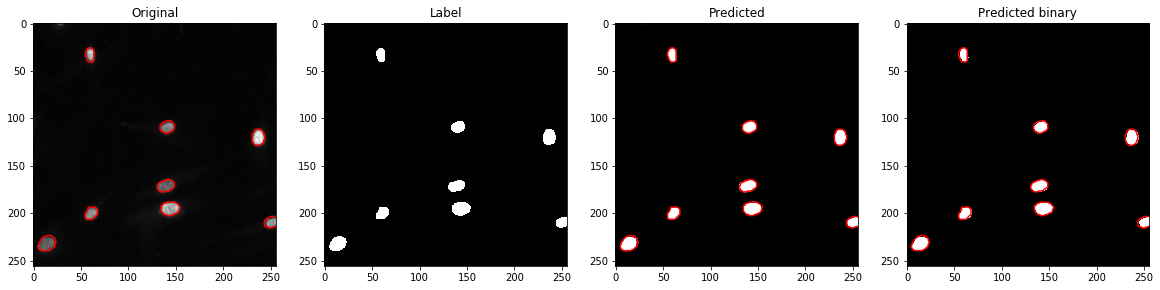

In [49]:
plot_sample(X_train[1:10,:,:,:], Y_train[1:10,:,:,:], preds_train, preds_train_t,ix=6)

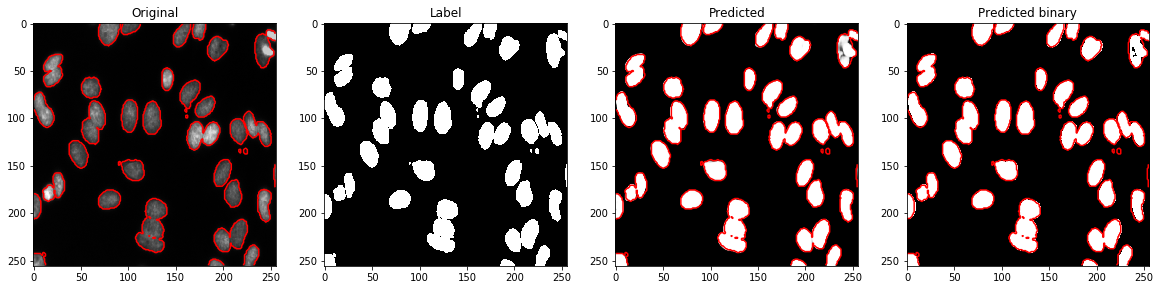

In [50]:
plot_sample(X_train[1:10,:,:,:], Y_train[1:10,:,:,:], preds_train, preds_train_t,ix=8)

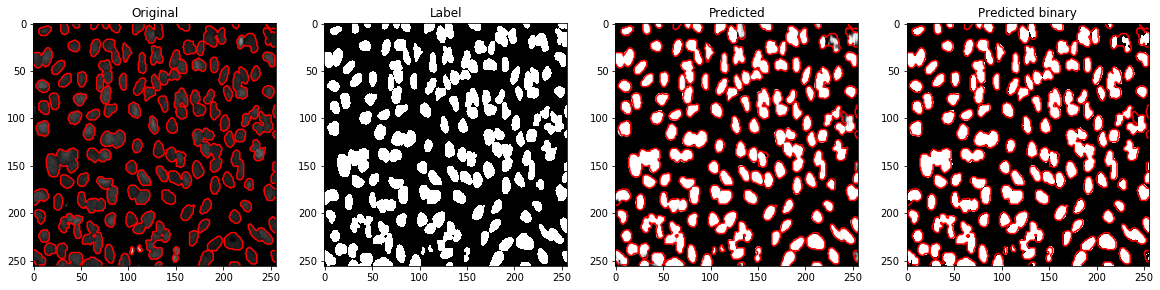

In [51]:
plot_sample(X_train[1:10,:,:,:], Y_train[1:10,:,:,:], preds_train, preds_train_t,ix=2)

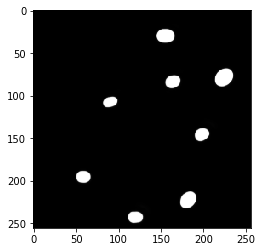

In [61]:
IM1 = preds_test[8,:,:,0]
plt.imshow(IM1,cmap='gray')
plt.show()